In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn 
import statsmodels

import sys
import os
import time

# Sparkling Dataset

In [2]:
df = pd.read_csv('Data/Rose.csv', parse_dates=True)
df.head()

YearMonth   Rose
0   1980-01  112.0
1   1980-02  118.0
2   1980-03  129.0
3   1980-04   99.0
4   1980-05  116.0

In [3]:
df['YearMonth'] = pd.to_datetime(df['YearMonth'],
                                 format='%Y-%m')
df.head()

YearMonth   Rose
0 1980-01-01  112.0
1 1980-02-01  118.0
2 1980-03-01  129.0
3 1980-04-01   99.0
4 1980-05-01  116.0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   YearMonth  187 non-null    datetime64[ns]
 1   Rose       185 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.0 KB


In [5]:
df = df.set_index('YearMonth')
df = df.asfreq('MS')
df.head()

Rose
YearMonth        
1980-01-01  112.0
1980-02-01  118.0
1980-03-01  129.0
1980-04-01   99.0
1980-05-01  116.0

In [6]:
df.shape

(187, 1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 187 entries, 1980-01-01 to 1995-07-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rose    185 non-null    float64
dtypes: float64(1)
memory usage: 2.9 KB


## EDA

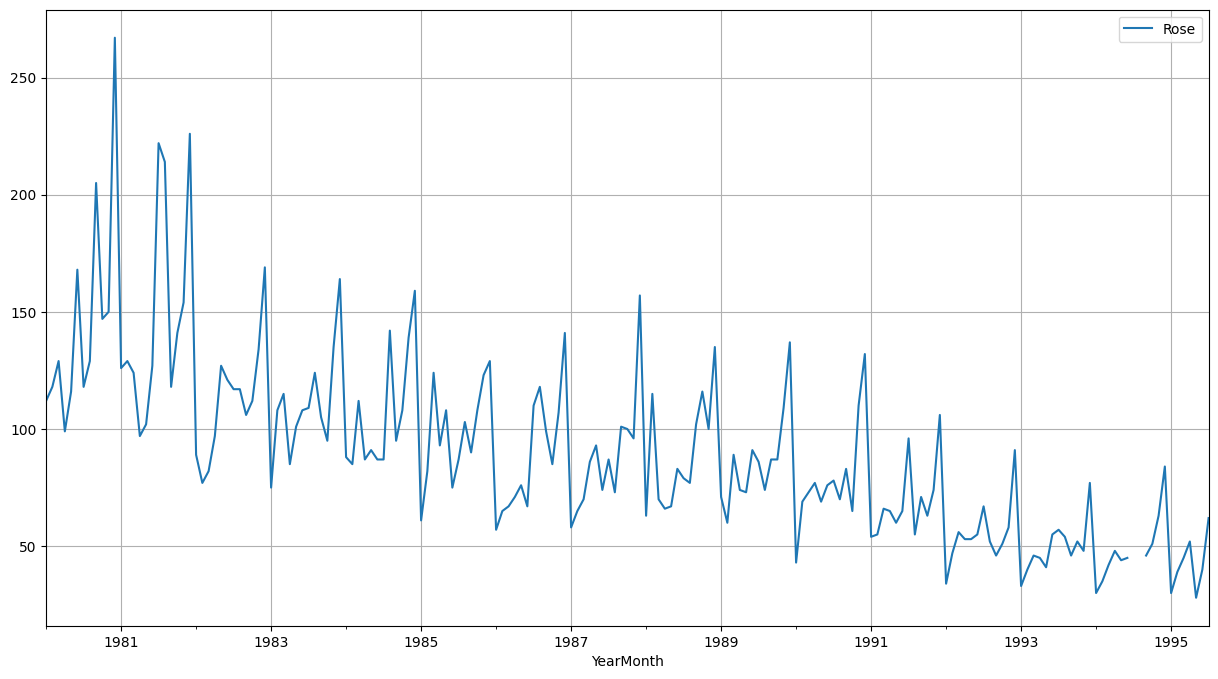

In [8]:
from pylab import rcParams

rcParams['figure.figsize'] = 15,8
df.plot();
plt.grid()
plt.savefig('tsl.png')

In [9]:
df.isnull().sum()

Rose    2
dtype: int64

In [10]:
df = df.interpolate(method='spline', order=1)

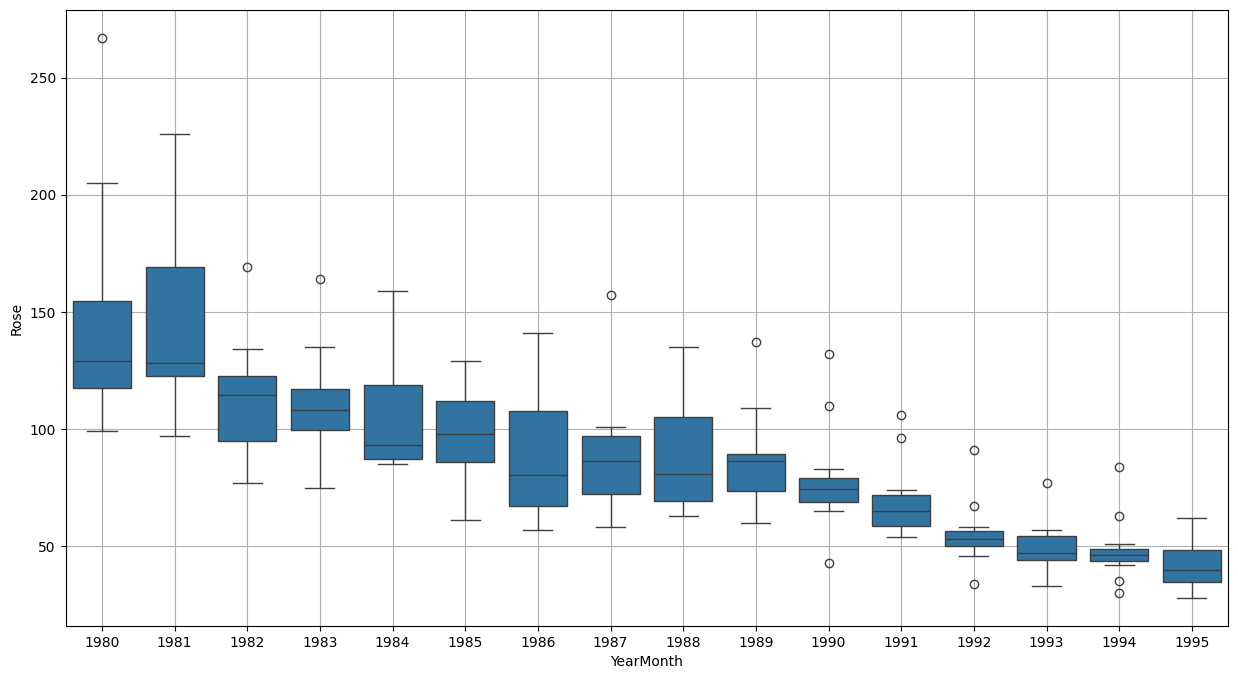

In [11]:
# Yearly Boxplot
sns.boxplot(x = df.index.year,y = df['Rose'])
plt.grid();

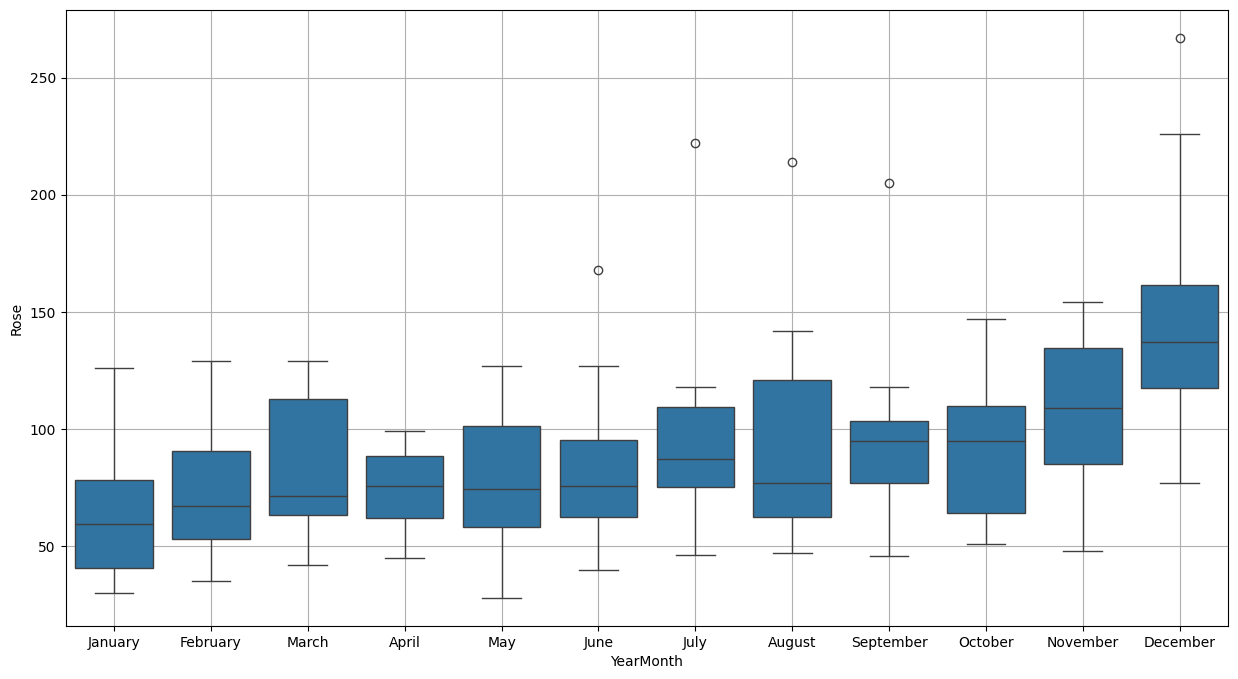

In [12]:
#Monthly Boxplot
sns.boxplot(x = df.index.month_name(),y = df['Rose'])
plt.grid();

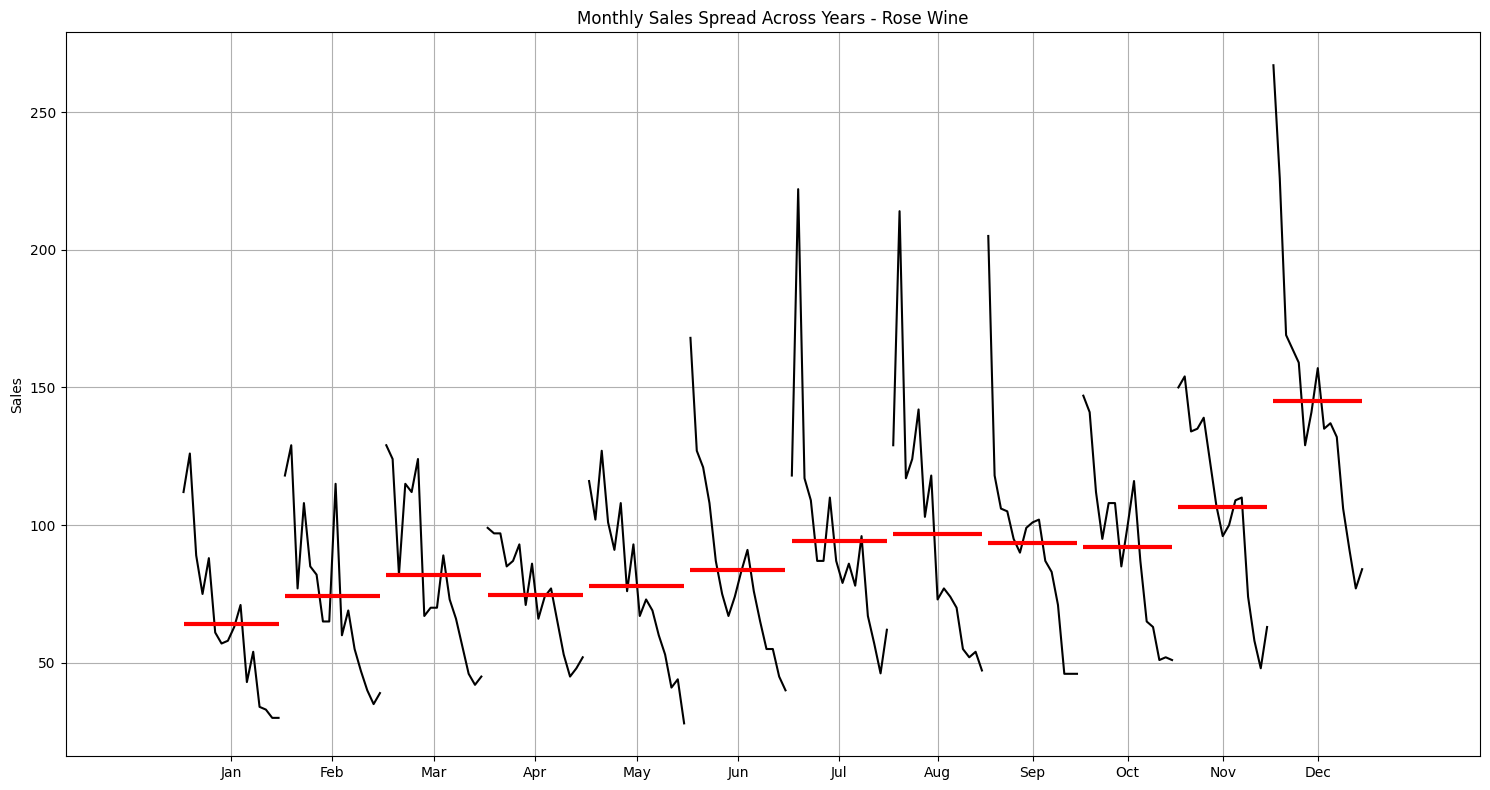

In [13]:
from statsmodels.graphics.tsaplots import month_plot

# Plot the month-wise breakdown across years
month_plot(df['Rose'], ylabel='Sales')
plt.grid(True)
plt.title("Monthly Sales Spread Across Years - Rose Wine")
plt.tight_layout()
plt.show()

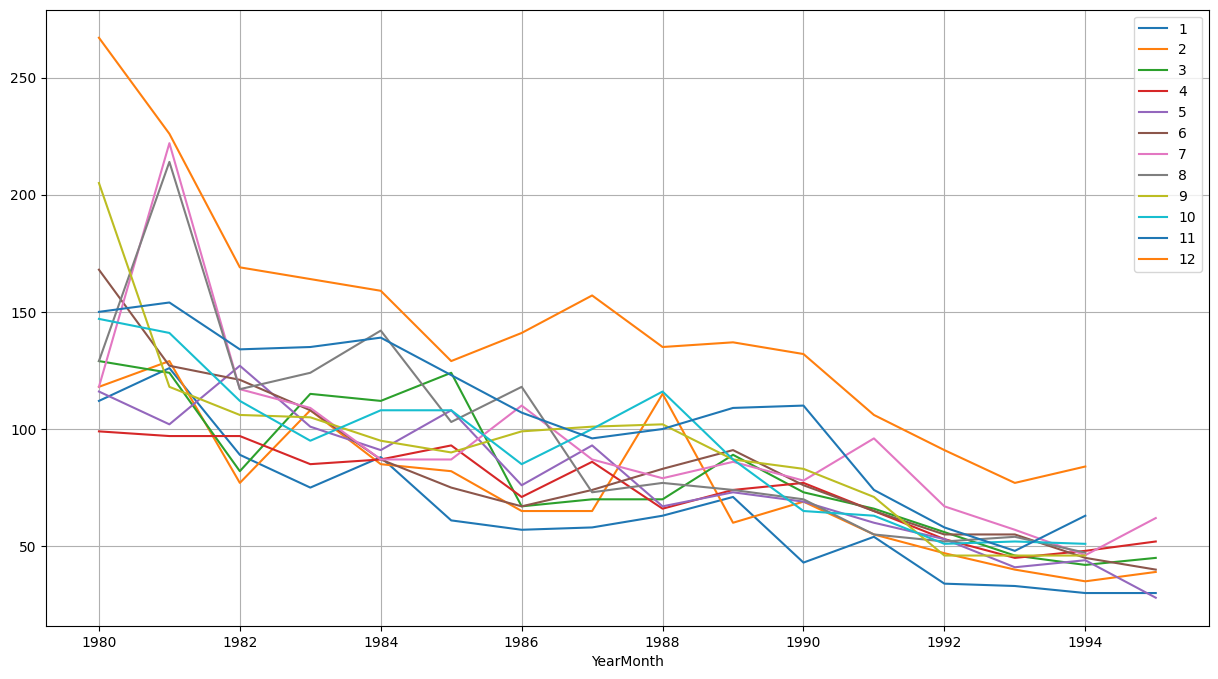

In [14]:
monthly_sales_across_years = pd.pivot_table(df,
                                            values = 'Rose',
                                            columns = df.index.month,
                                            index = df.index.year)
monthly_sales_across_years

monthly_sales_across_years.plot()
plt.grid()
plt.legend(loc='best');

In [15]:
df['Rose'].min()

np.float64(28.0)

In [16]:
df['Rose'].max()

np.float64(267.0)

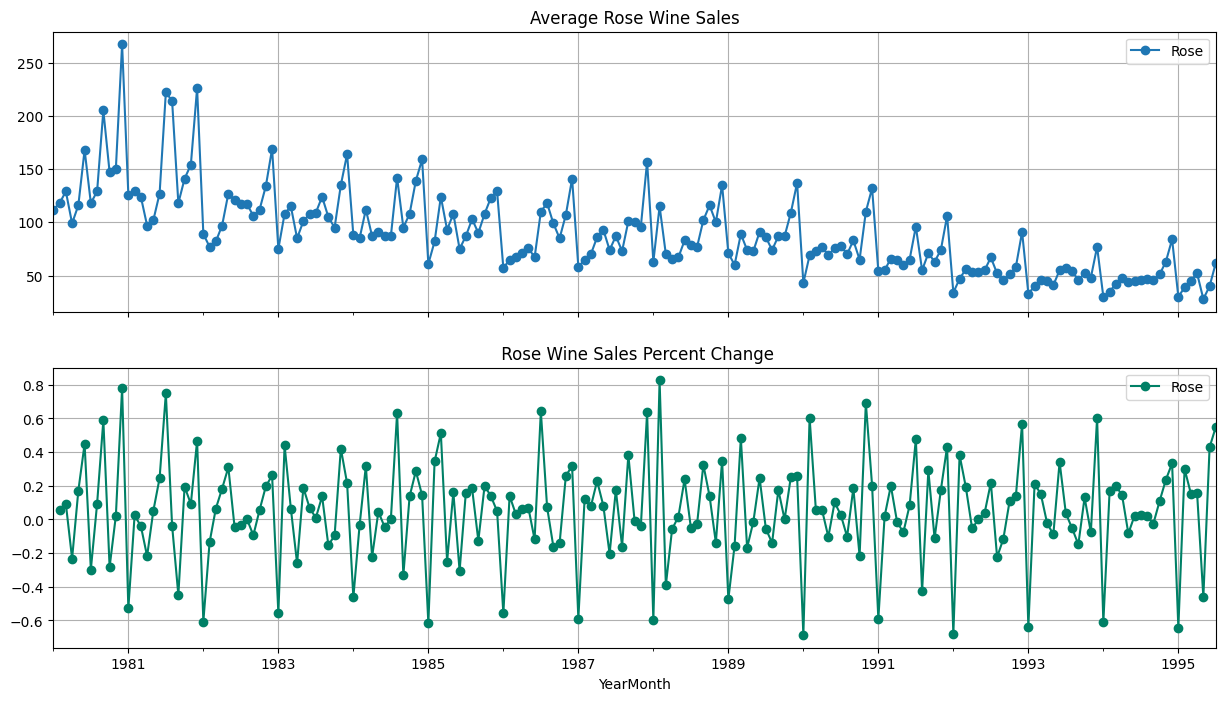

In [17]:
# Plot the average RetailSales per month and the month on month percentage change of RetailSales
# group by date and get average Sales, and precent change

average    = df.groupby(df.index)['Rose'].mean()
pct_change = df.groupby(df.index)['Rose'].sum().pct_change()

fig, (axis1,axis2) = plt.subplots(2,1,sharex=True,figsize=(15,8))

# plot average Sales over time(year-month)
ax1 = average.plot(legend=True,
                   ax=axis1,
                   marker='o',
                   title="Average Rose Wine Sales",
                   grid=True)
ax1.set_xticks(range(len(average)))
ax1.set_xticklabels(average.index.tolist())


# plot precent change for RetailSales over time(year-month)
ax2 = pct_change.plot(legend=True,
                      ax=axis2,
                      marker='o',
                      colormap="summer",
                      title=" Rose Wine Sales Percent Change",
                      grid=True)

In [18]:
# Decomposing The Time Series
from statsmodels.tsa.seasonal import seasonal_decompose

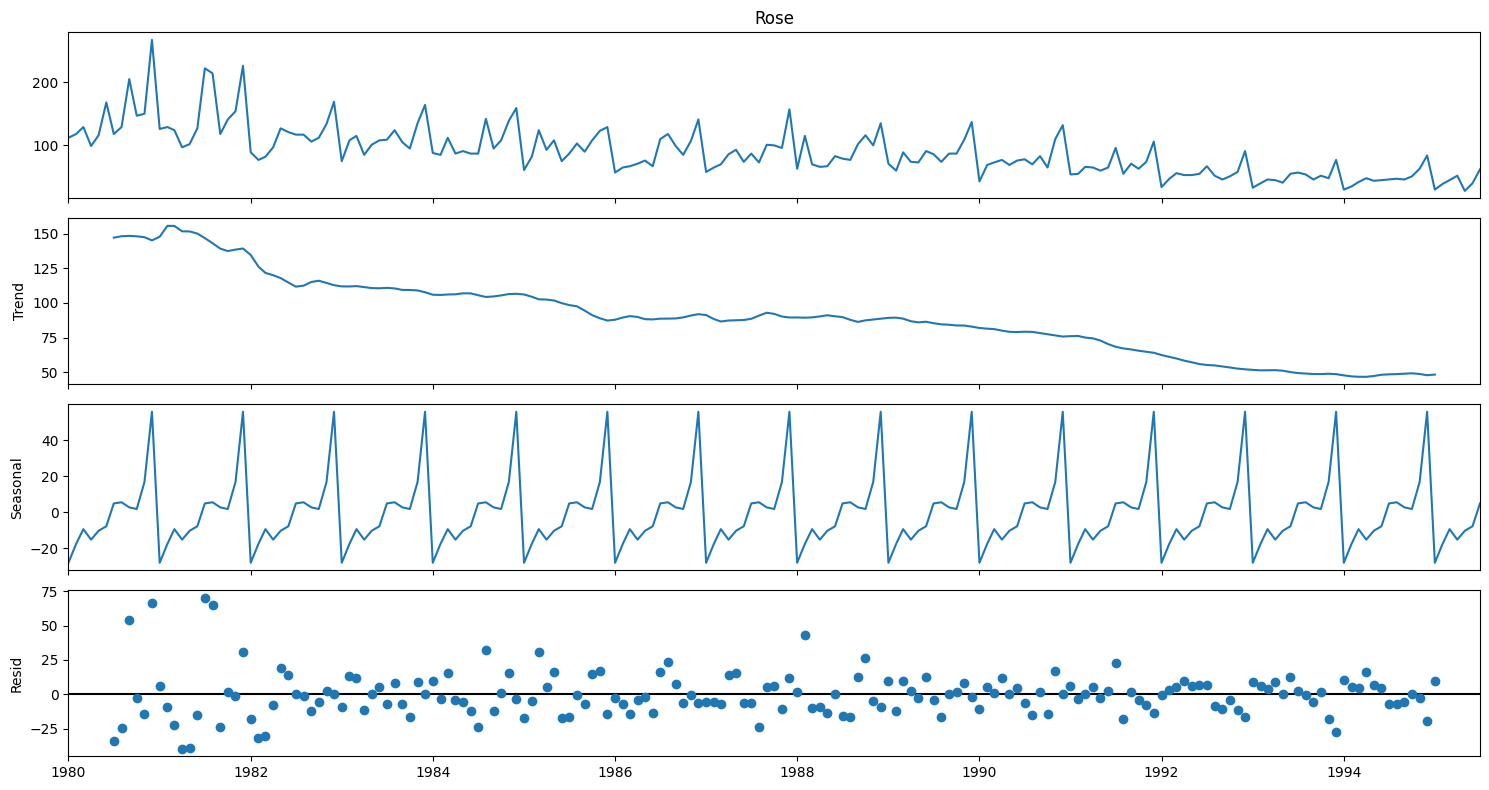

In [19]:
decomposition = seasonal_decompose(df['Rose'],model='additive')
decomposition.plot();

In [20]:
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

print('Trend','\n',trend.head(12),'\n')
print('Seasonality','\n',seasonality.head(12),'\n')
print('Residual','\n',residual.head(12),'\n')

Trend 
 YearMonth
1980-01-01           NaN
1980-02-01           NaN
1980-03-01           NaN
1980-04-01           NaN
1980-05-01           NaN
1980-06-01           NaN
1980-07-01    147.083333
1980-08-01    148.125000
1980-09-01    148.375000
1980-10-01    148.083333
1980-11-01    147.416667
1980-12-01    145.125000
Freq: MS, Name: trend, dtype: float64 

Seasonality 
 YearMonth
1980-01-01   -27.921780
1980-02-01   -17.445103
1980-03-01    -9.299901
1980-04-01   -15.112401
1980-05-01   -10.210615
1980-06-01    -7.692758
1980-07-01     4.938434
1980-08-01     5.589575
1980-09-01     2.761554
1980-10-01     1.858776
1980-11-01    16.833776
1980-12-01    55.700443
Freq: MS, Name: seasonal, dtype: float64 

Residual 
 YearMonth
1980-01-01          NaN
1980-02-01          NaN
1980-03-01          NaN
1980-04-01          NaN
1980-05-01          NaN
1980-06-01          NaN
1980-07-01   -34.021767
1980-08-01   -24.714575
1980-09-01    53.863446
1980-10-01    -2.942109
1980-11-01   -14.250443
19

## Stationarity Test

In [21]:
from statsmodels.tsa.stattools import adfuller


def test_stationarity(timeseries, window=6):
    # Rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std Dev')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.grid(True)
    plt.show()

    # Dickey-Fuller Test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=[
        'Test Statistic', 'p-value', '# Lags Used', 'Number of Observations Used'
    ])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    # print(dfoutput, '\n')

    # Decision
    if dftest[1] <= 0.05:
        print("The series is **stationary** (p-value <= 0.05)")
    else:
        print("The series is **not stationary** (p-value > 0.05)")
        
    return dfoutput

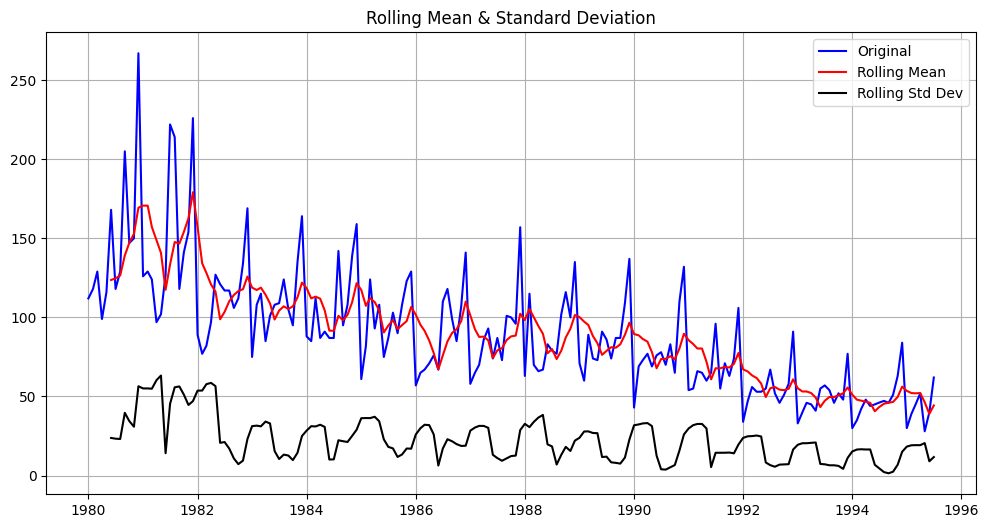

Results of Dickey-Fuller Test:
The series is **not stationary** (p-value > 0.05)


Test Statistic                  -1.880903
p-value                          0.341097
# Lags Used                     13.000000
Number of Observations Used    173.000000
Critical Value (1%)             -3.468726
Critical Value (5%)             -2.878396
Critical Value (10%)            -2.575756
dtype: float64

In [22]:
test_stationarity(df['Rose'])

### Retest after 1st differencing

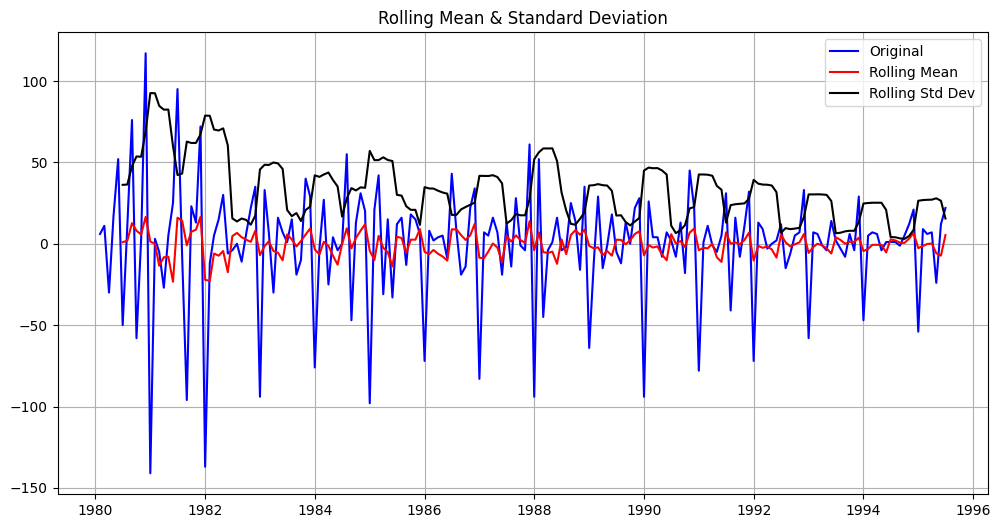

Results of Dickey-Fuller Test:
The series is **stationary** (p-value <= 0.05)


Test Statistic                -8.044819e+00
p-value                        1.806379e-12
# Lags Used                    1.200000e+01
Number of Observations Used    1.730000e+02
Critical Value (1%)           -3.468726e+00
Critical Value (5%)           -2.878396e+00
Critical Value (10%)          -2.575756e+00
dtype: float64

In [23]:
test_stationarity(df['Rose'].diff().dropna())

## AutoCorrelation Plot

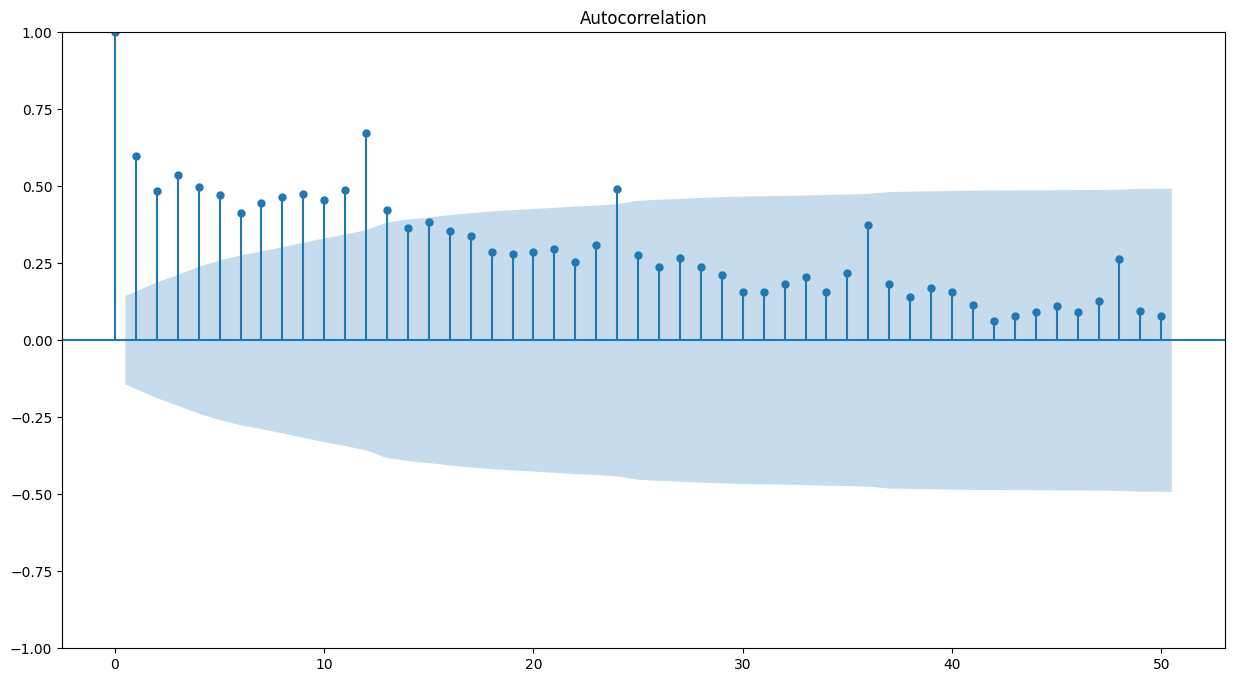

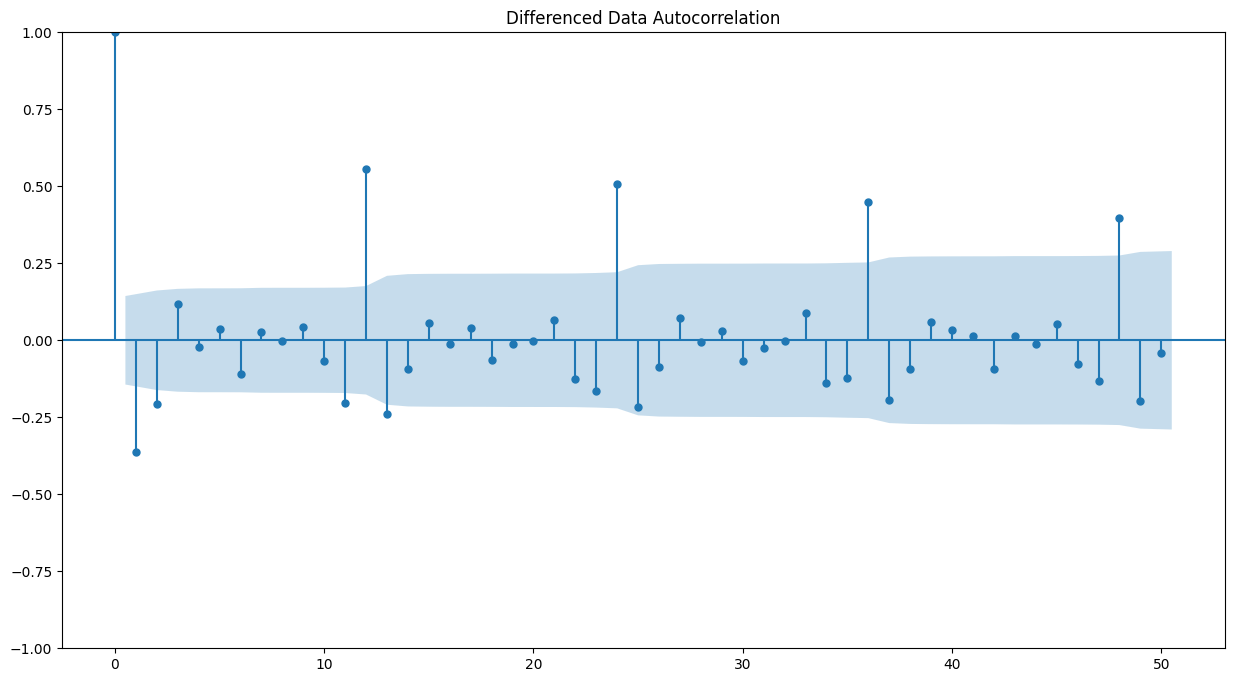

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plot_acf(df['Rose'],lags=50)
plot_acf(df['Rose'].diff(1).dropna(),lags=50,title='Differenced Data Autocorrelation')
plt.show()

## Partial AutoCorrelation Function

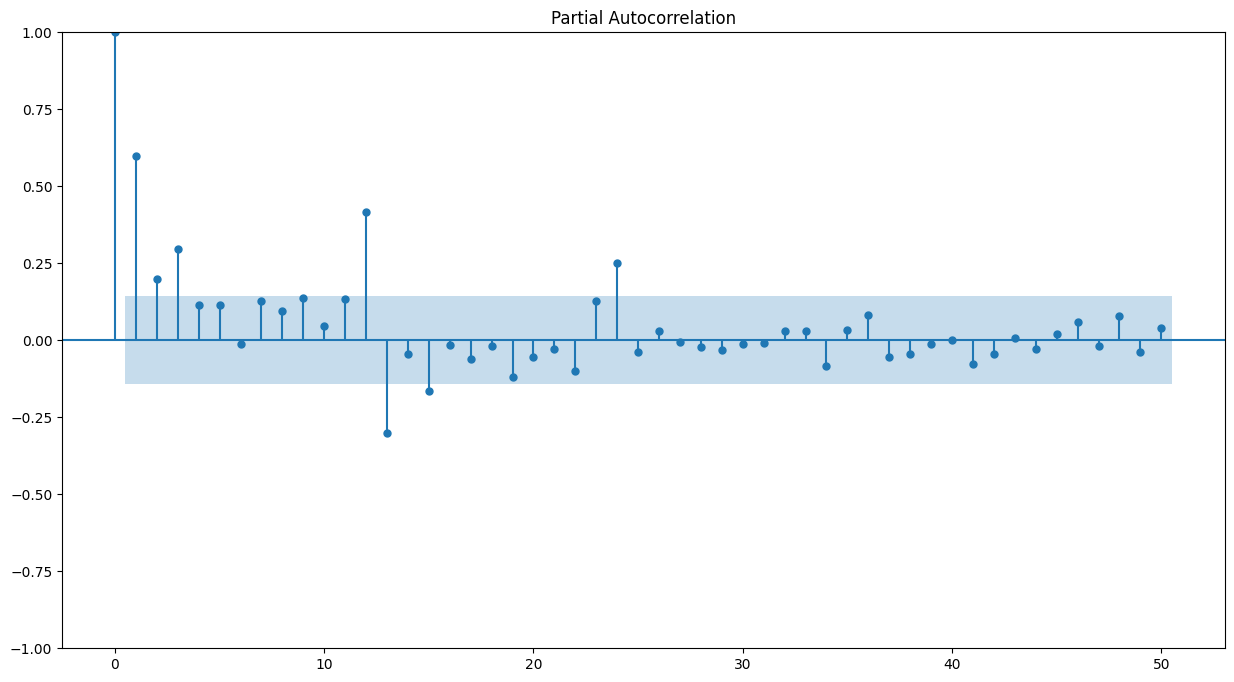

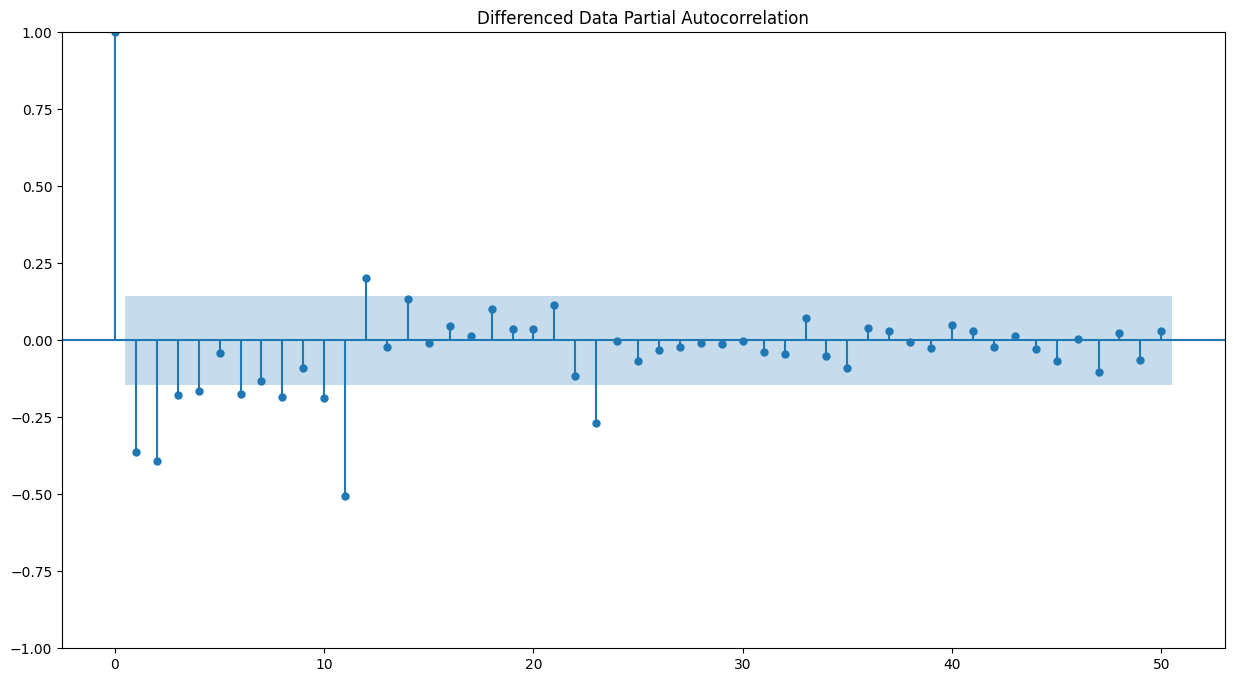

In [25]:
plot_pacf(df['Rose'],lags=50)
plot_pacf(df['Rose'].diff(1).dropna(),lags=50,title='Differenced Data Partial Autocorrelation')
plt.show()

## Train Test Split

In [26]:
# train-test on the original data
train = df[df.index.year < 1991]
test = df[df.index.year >= 1991]

In [27]:
differenced_df = df.copy()
differenced_df['Rose'] = df['Rose'].diff().dropna()
differenced_df = differenced_df.dropna()

In [28]:
# train-test sets on the differenced data
train_diff = differenced_df[differenced_df.index.year < 1991]
test_diff = differenced_df[differenced_df.index.year >= 1991]

In [29]:
DATASETS = {
    'original': (train, test),
    'differenced': (train_diff, test_diff)
}

In [30]:
print(train.shape)
print(test.shape)

(132, 1)
(55, 1)


In [31]:
print('First few rows of Training Data','\n',train.head(),'\n')
print('Last few rows of Training Data','\n',train.tail(),'\n')
print('First few rows of Test Data','\n',test.head(),'\n')
print('Last few rows of Test Data','\n',test.tail(),'\n')

First few rows of Training Data 
              Rose
YearMonth        
1980-01-01  112.0
1980-02-01  118.0
1980-03-01  129.0
1980-04-01   99.0
1980-05-01  116.0 

Last few rows of Training Data 
              Rose
YearMonth        
1990-08-01   70.0
1990-09-01   83.0
1990-10-01   65.0
1990-11-01  110.0
1990-12-01  132.0 

First few rows of Test Data 
             Rose
YearMonth       
1991-01-01  54.0
1991-02-01  55.0
1991-03-01  66.0
1991-04-01  65.0
1991-05-01  60.0 

Last few rows of Test Data 
             Rose
YearMonth       
1995-03-01  45.0
1995-04-01  52.0
1995-05-01  28.0
1995-06-01  40.0
1995-07-01  62.0 



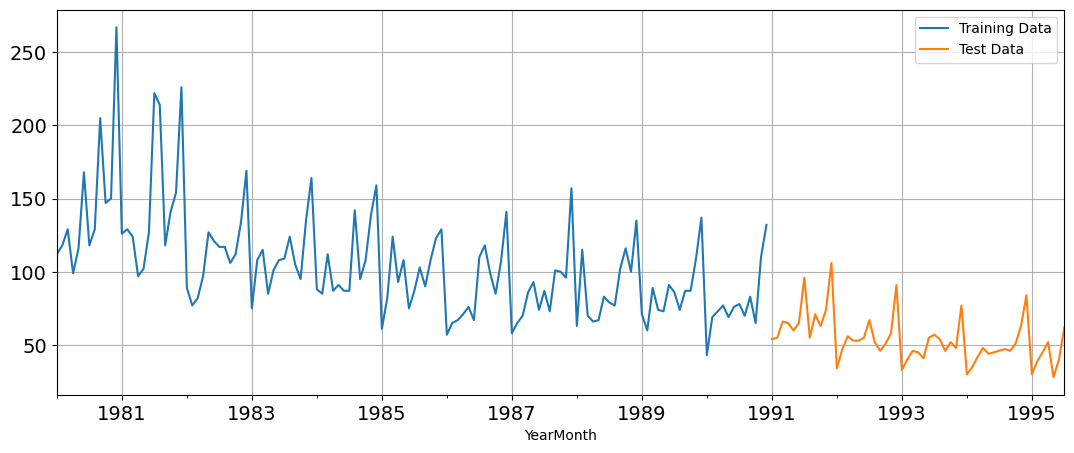

In [32]:
train['Rose'].plot(figsize=(13,5), fontsize=14)
test['Rose'].plot(figsize=(13,5), fontsize=14)
plt.grid()
plt.legend(['Training Data','Test Data'])
plt.show()

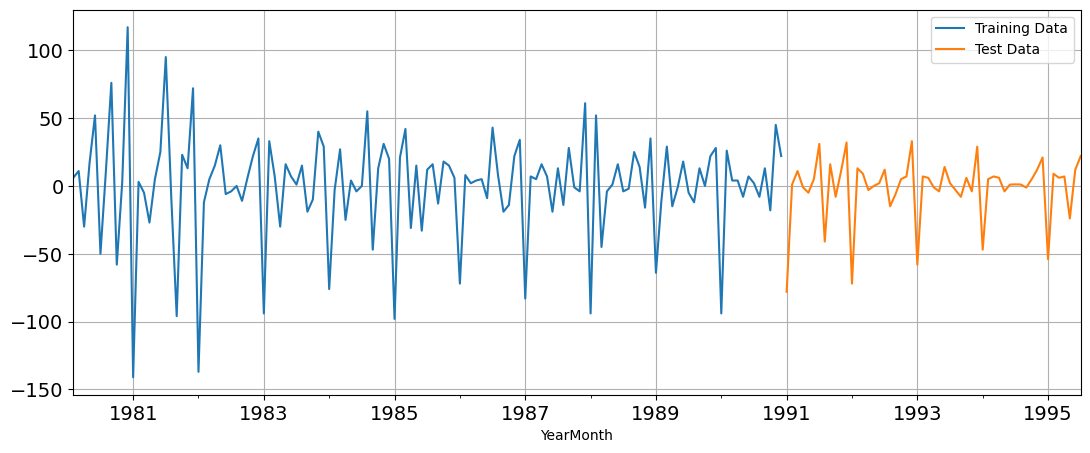

In [33]:
train_diff['Rose'].plot(figsize=(13,5), fontsize=14)
test_diff['Rose'].plot(figsize=(13,5), fontsize=14)
plt.grid()
plt.legend(['Training Data','Test Data'])
plt.show()

## 1. Regression Model

In [34]:
train_time = [i+1 for i in range(len(train))]
test_time = [i+43 for i in range(len(test))]
print('Training Time instance','\n',train_time)
print('\n')
print('Test Time instance','\n',test_time)

Training Time instance 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132]


Test Time instance 
 [43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97]


In [35]:
LinearRegression_train = train.copy()
LinearRegression_test = test.copy()

LinearRegression_train['time'] = train_time
LinearRegression_test['time'] = test_time

In [36]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(LinearRegression_train[['time']],
      LinearRegression_train['Rose'].values)


LinearRegression()

In [37]:
#predictions on train data
train_predictions_model1 = lr.predict(LinearRegression_train[['time']])
LinearRegression_train['RegOnTime'] = train_predictions_model1

#predictions on test data
test_predictions_model1 = lr.predict(LinearRegression_test[['time']])
LinearRegression_test['RegOnTime'] = test_predictions_model1

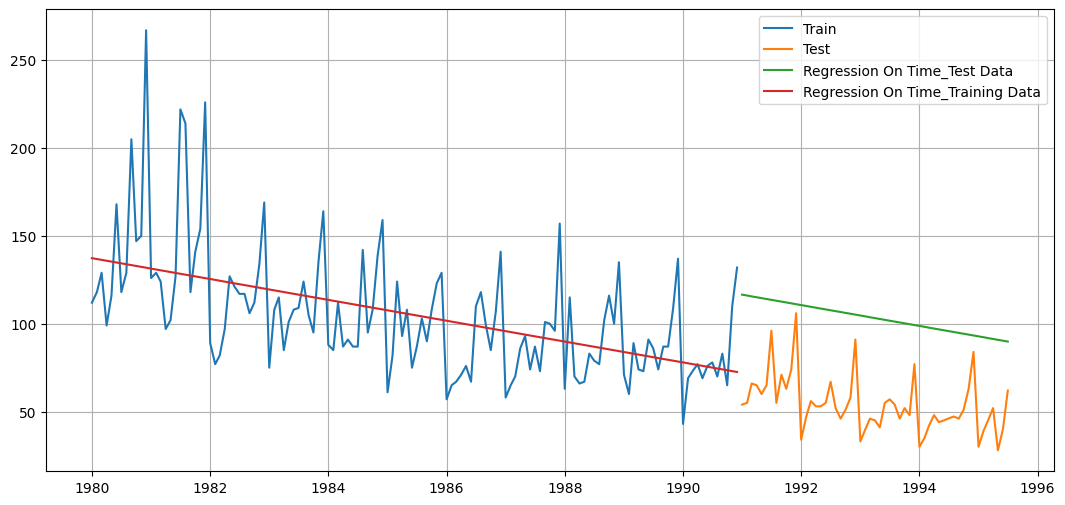

In [38]:
plt.figure(figsize=(13,6))
plt.plot( train['Rose'], label='Train')
plt.plot(test['Rose'], label='Test')
plt.plot(LinearRegression_test['RegOnTime'], label='Regression On Time_Test Data')
plt.plot(LinearRegression_train['RegOnTime'], label='Regression On Time_Training Data')
plt.legend(loc='best')
plt.grid();

In [39]:
from sklearn import metrics


# Custom RMSE function
def RMSE(y, yhat):
    y, yhat = np.array(y), np.array(yhat)
    try:
        rmse = round(np.sqrt(np.mean((y - yhat) ** 2)), 2)
    except:
        print("Observed values are empty or invalid")
        rmse = np.nan
    return rmse


# Custom MAPE function (your version)
def MAPE(y, yhat): 
    y, yhat = np.array(y), np.array(yhat)
    try:
        mape = round(np.sum(np.abs(yhat - y)) / np.sum(y) * 100, 2)
    except:
        print("Observed values are empty")
        mape = np.nan
    return mape

In [40]:
## MODEL1 - Training RMSE & MAPE
rmse_model1_train = RMSE(train['Rose'], train_predictions_model1)
mape_model1_train = MAPE(train['Rose'], train_predictions_model1)

print(f"For Model 1, Training RMSE is {rmse_model1_train} and MAPE is {mape_model1_train}")

For Model 1, Training RMSE is 30.72 and MAPE is 21.22


In [41]:
## MODEL1 - Testing RMSE & MAPE
rmse_model1_test = RMSE(test['Rose'], test_predictions_model1)
mape_model1_test = MAPE(test['Rose'], test_predictions_model1)

print(f"For Model 1, Testing RMSE is {rmse_model1_test} and MAPE is {mape_model1_test}")

For Model 1, Testing RMSE is 51.39 and MAPE is 91.49


In [42]:
resultsDF = pd.DataFrame({
    'Model': pd.Series(dtype='str'),
    'Train RMSE': pd.Series(dtype='float'),
    'Train MAPE': pd.Series(dtype='float'),
    'Test RMSE': pd.Series(dtype='float'),
    'Test MAPE': pd.Series(dtype='float')
})


# model logging function
def log_results(model, train_rmse, train_mape, test_rmse, test_mape, data_source):
    global resultsDF

    new_row = pd.DataFrame({
        'Model': [model],
        'Train RMSE': [train_rmse],
        'Train MAPE': [train_mape],
        'Test RMSE': [test_rmse],
        'Test MAPE': [test_mape],
        'Data Source': [data_source]  # <--- NEW COLUMN
    })

    resultsDF = pd.concat([resultsDF, new_row], ignore_index=True)

In [43]:
log_results(model="RegressionModel_Model1",
            train_rmse=rmse_model1_train,
            train_mape=mape_model1_train,
            test_rmse=rmse_model1_test,
            test_mape=mape_model1_test,
            data_source="original")

In [44]:
resultsDF

Model  Train RMSE  Train MAPE  Test RMSE  Test MAPE  \
0  RegressionModel_Model1       30.72       21.22      51.39      91.49   

  Data Source  
0    original

## 2. Naive Model

In [45]:
NaiveModel_train = train.copy()
NaiveModel_test = test.copy()

In [46]:
NaiveModel_train['naive'] = np.asarray(train['Rose'])[len(np.asarray(train['Rose']))-1]
NaiveModel_train['naive'].head()

YearMonth
1980-01-01    132.0
1980-02-01    132.0
1980-03-01    132.0
1980-04-01    132.0
1980-05-01    132.0
Freq: MS, Name: naive, dtype: float64

In [47]:
NaiveModel_test['naive'] = np.asarray(train['Rose'])[len(np.asarray(train['Rose']))-1]
NaiveModel_test['naive'].head()

YearMonth
1991-01-01    132.0
1991-02-01    132.0
1991-03-01    132.0
1991-04-01    132.0
1991-05-01    132.0
Freq: MS, Name: naive, dtype: float64

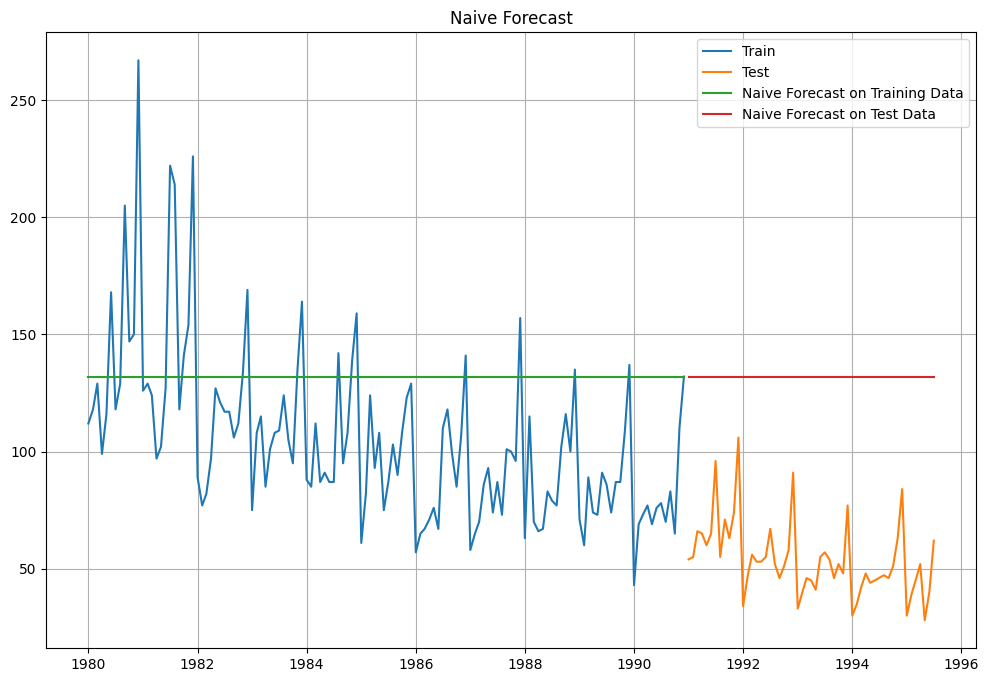

In [48]:
plt.figure(figsize=(12,8))
plt.plot(NaiveModel_train['Rose'], label='Train')
plt.plot(test['Rose'], label='Test')
plt.plot(NaiveModel_train['naive'], label='Naive Forecast on Training Data')
plt.plot(NaiveModel_test['naive'], label='Naive Forecast on Test Data')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.grid();

In [49]:
# MODEL2 - Evaluate Naive Model on training data
rmse_model2_train = RMSE(train['Rose'], NaiveModel_train['naive'])
mape_model2_train = MAPE(train['Rose'], NaiveModel_train['naive'])

print(f"For Model 2, Training RMSE is {rmse_model2_train} and MAPE is {mape_model2_train}")

For Model 2, Training RMSE is 45.06 and MAPE is 36.38


In [50]:
# MODEL2 -  Evaluate Naive Model on Testa Data
rmse_model2_test = RMSE(test['Rose'], NaiveModel_test['naive'])
mape_model2_test = MAPE(test['Rose'], NaiveModel_test['naive'])

print(f"For Model 2, Testing RMSE is {rmse_model2_test} and MAPE is {mape_model2_test}")

For Model 2, Testing RMSE is 79.67 and MAPE is 144.91


In [51]:
log_results(model = "Naive_Model2",
            train_rmse = rmse_model2_train,
            train_mape = mape_model2_train,
            test_rmse = rmse_model2_test,
            test_mape = mape_model2_test,
           data_source = "original")

resultsDF

Model  Train RMSE  Train MAPE  Test RMSE  Test MAPE  \
0  RegressionModel_Model1       30.72       21.22      51.39      91.49   
1            Naive_Model2       45.06       36.38      79.67     144.91   

  Data Source  
0    original  
1    original

## 3. Simple Average Model

In [52]:
SimpleAverage_train = train.copy()
SimpleAverage_test = test.copy()

In [53]:
SimpleAverage_train['mean_forecast'] = train['Rose'].mean()
SimpleAverage_train.head()

Rose  mean_forecast
YearMonth                       
1980-01-01  112.0     104.939394
1980-02-01  118.0     104.939394
1980-03-01  129.0     104.939394
1980-04-01   99.0     104.939394
1980-05-01  116.0     104.939394

In [54]:
SimpleAverage_test['mean_forecast'] = train['Rose'].mean()
SimpleAverage_test.head()

Rose  mean_forecast
YearMonth                      
1991-01-01  54.0     104.939394
1991-02-01  55.0     104.939394
1991-03-01  66.0     104.939394
1991-04-01  65.0     104.939394
1991-05-01  60.0     104.939394

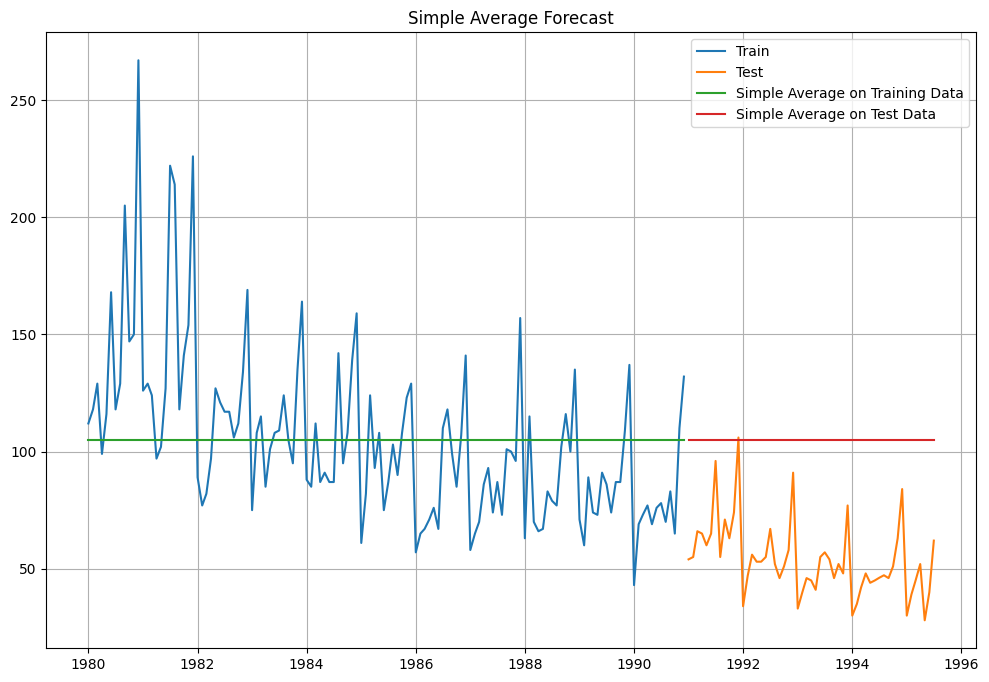

In [55]:
plt.figure(figsize=(12,8))
plt.plot(SimpleAverage_train['Rose'], label='Train')
plt.plot(SimpleAverage_test['Rose'], label='Test')
plt.plot(SimpleAverage_train['mean_forecast'], label='Simple Average on Training Data')
plt.plot(SimpleAverage_test['mean_forecast'], label='Simple Average on Test Data')
plt.legend(loc='best')
plt.title("Simple Average Forecast")
plt.grid();

In [56]:
# MODEL3 - Evaluate Simple Average Model on Training Data
rmse_model3_train = RMSE(train['Rose'], SimpleAverage_train['mean_forecast'])
mape_model3_train = MAPE(train['Rose'], SimpleAverage_train['mean_forecast'])

print(f"For Model 3, Training RMSE is {rmse_model3_train} and MAPE is {mape_model3_train}")

For Model 3, Training RMSE is 36.03 and MAPE is 25.39


In [57]:
# MODEL3 - Evaluate Simple Average Model on Training Data
rmse_model3_test = RMSE(test['Rose'], SimpleAverage_test['mean_forecast'])
mape_model3_test = MAPE(test['Rose'], SimpleAverage_test['mean_forecast'])

print(f"For Model 3, Test RMSE is {rmse_model3_test} and MAPE is {mape_model3_test}")

For Model 3, Test RMSE is 53.41 and MAPE is 94.77


In [58]:
log_results("SimpleAveraging_Model3",
            rmse_model3_train,
            mape_model3_train,
            rmse_model3_test,
            mape_model3_test,
           "original")

resultsDF

Model  Train RMSE  Train MAPE  Test RMSE  Test MAPE  \
0  RegressionModel_Model1       30.72       21.22      51.39      91.49   
1            Naive_Model2       45.06       36.38      79.67     144.91   
2  SimpleAveraging_Model3       36.03       25.39      53.41      94.77   

  Data Source  
0    original  
1    original  
2    original

## 4. Moving Average Model

In [59]:
MovingAverage = df.copy()

# Add trailing moving average columns
for w in [2, 4, 6, 9]:
    MovingAverage[f'Trailing_{w}'] = MovingAverage['Rose'].rolling(w).mean()

In [60]:
# Step 2: Train-Test Split
train_size = int(len(MovingAverage) * 0.71)
trailing_MA_train = MovingAverage.iloc[:train_size]
trailing_MA_test = MovingAverage.iloc[train_size:]

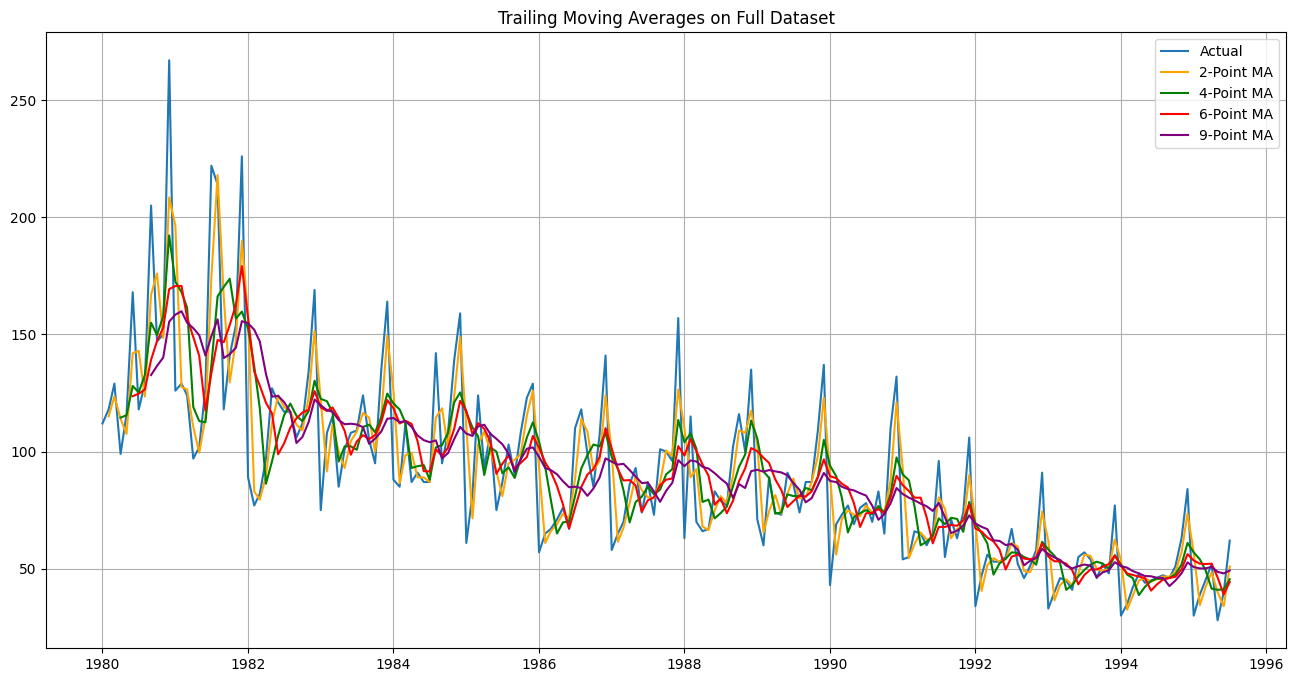

In [61]:
plt.figure(figsize=(16, 8))
plt.plot(MovingAverage['Rose'], label='Actual')

colors = ['orange', 'green', 'red', 'purple']
for w, c in zip([2, 4, 6, 9], colors):
    plt.plot(MovingAverage[f'Trailing_{w}'], label=f'{w}-Point MA', color=c)

plt.legend()
plt.title('Trailing Moving Averages on Full Dataset')
plt.grid(True)
plt.show()

In [62]:
# Step 4: Loop over MA windows and evaluate each
for w in [2, 4, 6, 9]:
    model_name = f'{w}-Point Trailing MA_Model4'

    # Drop NaNs from rolling to get valid forecast points
    train_ma = trailing_MA_train[f'Trailing_{w}'].dropna()
    test_ma = trailing_MA_test[f'Trailing_{w}'].dropna()

    # Align targets with available forecast indices
    train_true = train.loc[train_ma.index, 'Rose']
    test_true = test.loc[test_ma.index, 'Rose']

    # Evaluate
    train_rmse = RMSE(train_true, train_ma)
    train_mape = MAPE(train_true, train_ma)
    test_rmse = RMSE(test_true, test_ma)
    test_mape = MAPE(test_true, test_ma)

    # Print evaluation
    print(f"{model_name} → Train RMSE: {train_rmse}, MAPE: {train_mape}% | Test RMSE: {test_rmse}, MAPE: {test_mape}%")

    # Log results
    log_results(model_name, train_rmse, train_mape, test_rmse, test_mape, data_source="original")


2-Point Trailing MA_Model4 → Train RMSE: 19.47, MAPE: 12.47% | Test RMSE: 11.53, MAPE: 13.57%
4-Point Trailing MA_Model4 → Train RMSE: 25.97, MAPE: 18.03% | Test RMSE: 14.44, MAPE: 19.46%
6-Point Trailing MA_Model4 → Train RMSE: 28.46, MAPE: 20.41% | Test RMSE: 14.55, MAPE: 20.82%
9-Point Trailing MA_Model4 → Train RMSE: 30.23, MAPE: 22.06% | Test RMSE: 14.72, MAPE: 20.99%


In [63]:
resultsDF

Model  Train RMSE  Train MAPE  Test RMSE  Test MAPE  \
0      RegressionModel_Model1       30.72       21.22      51.39      91.49   
1                Naive_Model2       45.06       36.38      79.67     144.91   
2      SimpleAveraging_Model3       36.03       25.39      53.41      94.77   
3  2-Point Trailing MA_Model4       19.47       12.47      11.53      13.57   
4  4-Point Trailing MA_Model4       25.97       18.03      14.44      19.46   
5  6-Point Trailing MA_Model4       28.46       20.41      14.55      20.82   
6  9-Point Trailing MA_Model4       30.23       22.06      14.72      20.99   

  Data Source  
0    original  
1    original  
2    original  
3    original  
4    original  
5    original  
6    original

## Model 5: Simple Exponential Smoothing (Auto)

In [64]:
from statsmodels.tsa.api import SimpleExpSmoothing

# Fit Simple Exponential Smoothing 
model_SES = SimpleExpSmoothing(train['Rose'])
model_SES_fit = model_SES.fit(optimized=True)

In [65]:
print(model_SES_fit.summary())

                       SimpleExpSmoothing Model Results                       
Dep. Variable:                   Rose   No. Observations:                  132
Model:             SimpleExpSmoothing   SSE                         133294.850
Optimized:                       True   AIC                            917.112
Trend:                           None   BIC                            922.878
Seasonal:                        None   AICC                           917.427
Seasonal Periods:                None   Date:                 Sun, 13 Apr 2025
Box-Cox:                        False   Time:                         17:47:05
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.1236201                alpha                 True
initial_level              112.00000                

In [66]:
model_SES_fit.params

{'smoothing_level': np.float64(0.12362013466760018),
 'smoothing_trend': np.float64(nan),
 'smoothing_seasonal': np.float64(nan),
 'damping_trend': nan,
 'initial_level': np.float64(112.0),
 'initial_trend': np.float64(nan),
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [67]:
# Predictions
train_preds_SES = model_SES_fit.fittedvalues
test_preds_SES = model_SES_fit.forecast(steps=len(test))

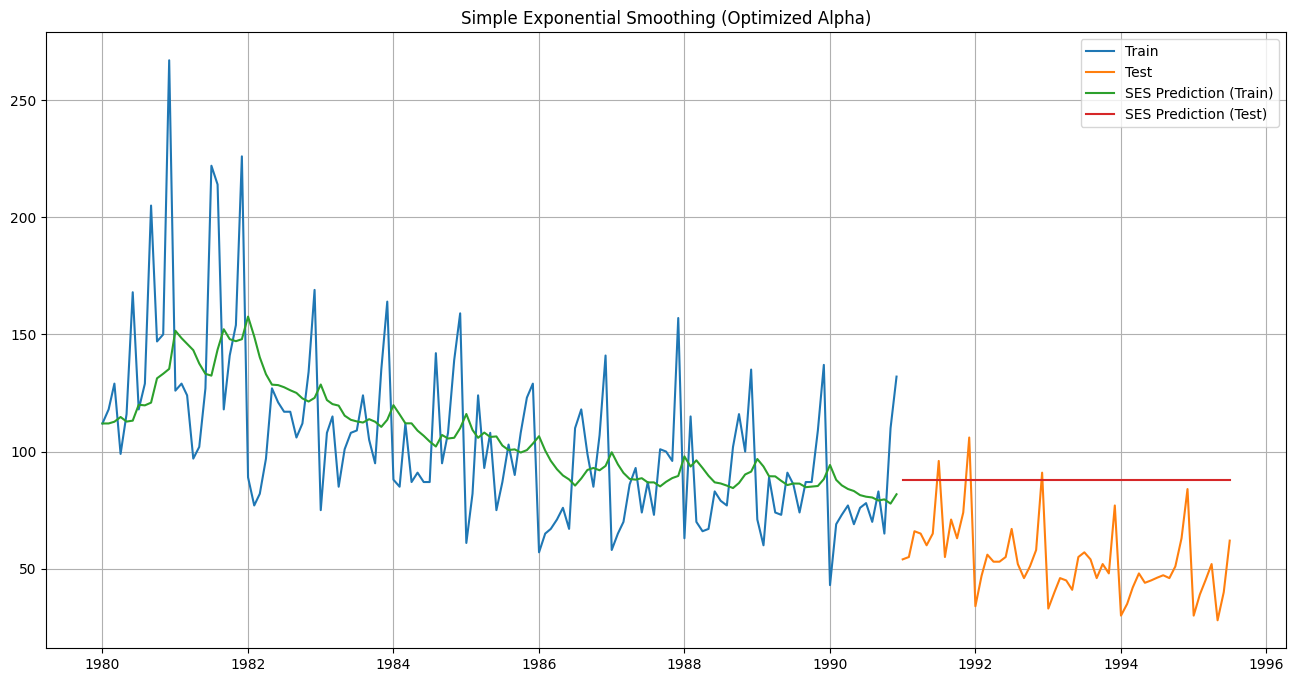

In [68]:
# Plot predictions
plt.figure(figsize=(16, 8))
plt.plot(train['Rose'], label='Train')
plt.plot(test['Rose'], label='Test')
plt.plot(train_preds_SES, label='SES Prediction (Train)')
plt.plot(test.index, test_preds_SES, label='SES Prediction (Test)')

plt.title('Simple Exponential Smoothing (Optimized Alpha)')
plt.legend()
plt.grid(True)
plt.show()

In [69]:
# Evaluate
rmse_model5_train = RMSE(train['Rose'], train_preds_SES)
mape_model5_train = MAPE(train['Rose'], train_preds_SES)

rmse_model5_test = RMSE(test['Rose'], test_preds_SES)
mape_model5_test = MAPE(test['Rose'], test_preds_SES)

print(f"Model5 Simple Exponential Smoothing - Train RMSE: {rmse_model5_train}, Train MAPE: {mape_model5_train}% | Test RMSE: {rmse_model5_test}, Test MAPE: {mape_model5_test}%")

Model5 Simple Exponential Smoothing - Train RMSE: 31.78, Train MAPE: 22.37% | Test RMSE: 37.54, Test MAPE: 65.2%


In [70]:
log_results(
    model="SimpleExpSmoothing_Model5",
    train_rmse=rmse_model5_train,
    train_mape=mape_model5_train,
    test_rmse=rmse_model5_test,
    test_mape=mape_model5_test,
    data_source="original"
)

In [71]:
resultsDF

Model  Train RMSE  Train MAPE  Test RMSE  Test MAPE  \
0      RegressionModel_Model1       30.72       21.22      51.39      91.49   
1                Naive_Model2       45.06       36.38      79.67     144.91   
2      SimpleAveraging_Model3       36.03       25.39      53.41      94.77   
3  2-Point Trailing MA_Model4       19.47       12.47      11.53      13.57   
4  4-Point Trailing MA_Model4       25.97       18.03      14.44      19.46   
5  6-Point Trailing MA_Model4       28.46       20.41      14.55      20.82   
6  9-Point Trailing MA_Model4       30.23       22.06      14.72      20.99   
7   SimpleExpSmoothing_Model5       31.78       22.37      37.54      65.20   

  Data Source  
0    original  
1    original  
2    original  
3    original  
4    original  
5    original  
6    original  
7    original

## Model 6: Simple Exponential Model with alpha in range of 0.01 to 0.1

In [72]:
resultsDf_6_model = pd.DataFrame(columns=[
    'Alpha', 'Train RMSE', 'Train MAPE', 'Test RMSE', 'Test MAPE'
])

In [73]:
from statsmodels.tsa.api import SimpleExpSmoothing

best_model = None
best_alpha = None
best_rmse = float('inf')

# Re-fit SES model each time with fixed alpha
for alpha in np.arange(0.01, 1.01, 0.01):
    model = SimpleExpSmoothing(train['Rose'], initialization_method='estimated')
    model_fit = model.fit(smoothing_level=alpha, optimized=False)  # disable optimization for fixed alpha

    train_preds = model_fit.fittedvalues
    test_preds = model_fit.forecast(steps=len(test))

    train_rmse = RMSE(train['Rose'], train_preds)
    train_mape = MAPE(train['Rose'], train_preds)

    test_rmse = RMSE(test['Rose'], test_preds)
    test_mape = MAPE(test['Rose'], test_preds)

    # Save results
    resultsDf_6_model.loc[len(resultsDf_6_model)] = [alpha, train_rmse, train_mape, test_rmse, test_mape]

    # Track best model
    if test_rmse < best_rmse:
        best_model = model_fit
        best_alpha = alpha
        best_train_preds = train_preds
        best_test_preds = test_preds
        best_rmse = test_rmse


In [74]:
resultsDf_6_model = resultsDf_6_model.sort_values(by='Test RMSE', ascending=True)
display(resultsDf_6_model.head())

Alpha  Train RMSE  Train MAPE  Test RMSE  Test MAPE
6   0.07       32.65       23.02      36.39      63.09
7   0.08       32.48       22.93      36.41      63.14
5   0.06       32.88       23.17      36.53      63.35
8   0.09       32.35       22.86      36.56      63.40
9   0.10       32.25       22.83      36.78      63.81

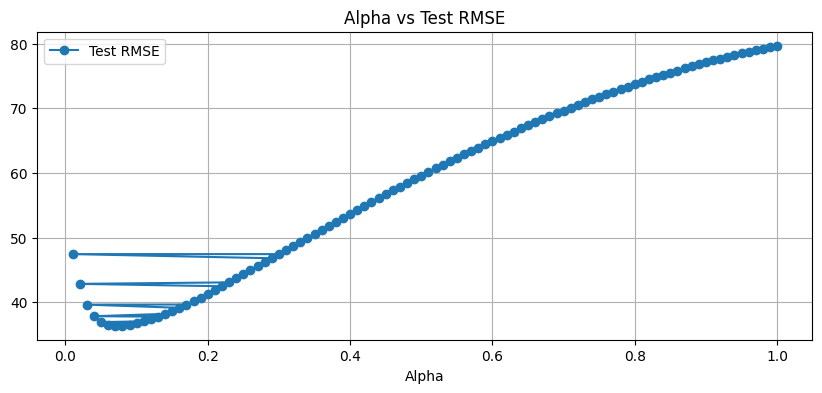

In [75]:
## View the Smoothing Effect (alpha vs RMSE plot)
resultsDf_6_model.plot(x='Alpha', y='Test RMSE', figsize=(10, 4), title="Alpha vs Test RMSE", marker='o')
plt.grid()
plt.show()

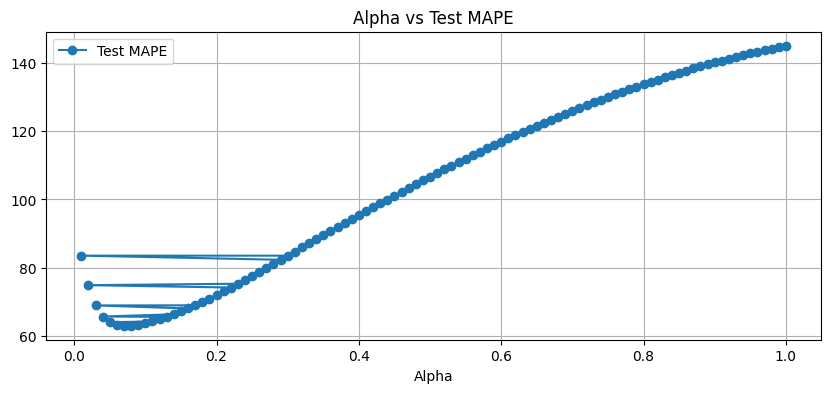

In [76]:
resultsDf_6_model.plot(x='Alpha', y='Test MAPE', figsize=(10, 4), title="Alpha vs Test MAPE", marker='o')
plt.grid()
plt.show()

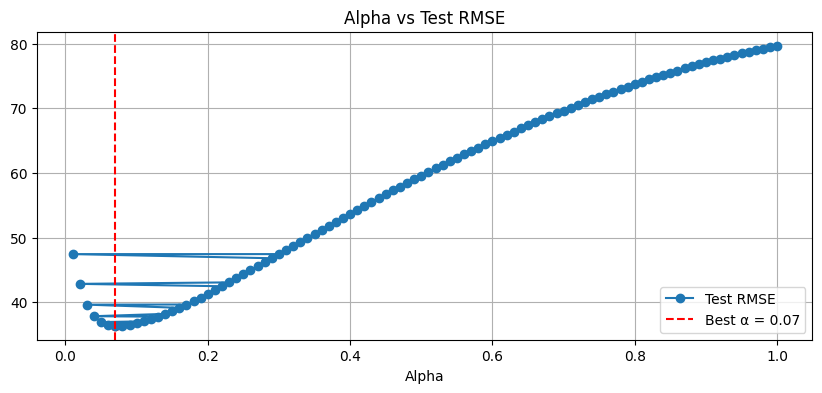

In [77]:
best_row = resultsDf_6_model.loc[resultsDf_6_model['Test RMSE'].idxmin()]
best_alpha = best_row['Alpha']
best_rmse = best_row['Test RMSE']

# Plot with marker for best alpha
ax = resultsDf_6_model.plot(x='Alpha', y='Test RMSE', figsize=(10, 4), title="Alpha vs Test RMSE", marker='o')
plt.axvline(best_alpha, color='red', linestyle='--', label=f'Best α = {best_alpha:.2f}')
plt.scatter(best_alpha, best_rmse, color='red')
plt.legend()
plt.grid()
plt.show()

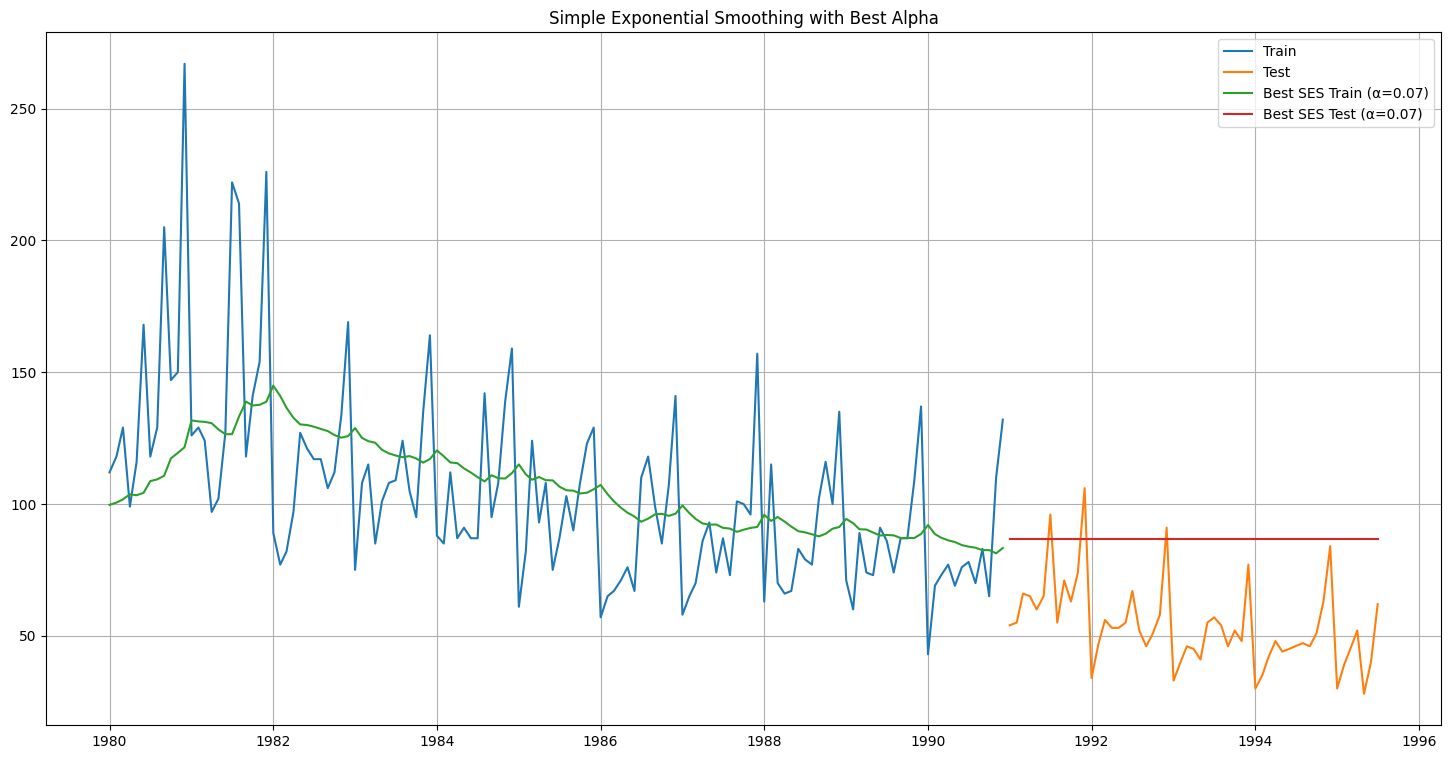

In [78]:
plt.figure(figsize=(18, 9))
plt.plot(train['Rose'], label='Train')
plt.plot(test['Rose'], label='Test')

plt.plot(best_train_preds, label=f'Best SES Train (α={best_alpha:.2f})')
plt.plot(test.index, best_test_preds, label=f'Best SES Test (α={best_alpha:.2f})')

plt.title('Simple Exponential Smoothing with Best Alpha')
plt.legend()
plt.grid()
plt.show()

In [79]:
log_results(
    f'SES_FixedAlpha={best_alpha:.2f}_Model6',
    RMSE(train['Rose'], best_train_preds),
    MAPE(train['Rose'], best_train_preds),
    RMSE(test['Rose'], best_test_preds),
    MAPE(test['Rose'], best_test_preds),
    data_source="original"
)

In [80]:
resultsDF

Model  Train RMSE  Train MAPE  Test RMSE  Test MAPE  \
0      RegressionModel_Model1       30.72       21.22      51.39      91.49   
1                Naive_Model2       45.06       36.38      79.67     144.91   
2      SimpleAveraging_Model3       36.03       25.39      53.41      94.77   
3  2-Point Trailing MA_Model4       19.47       12.47      11.53      13.57   
4  4-Point Trailing MA_Model4       25.97       18.03      14.44      19.46   
5  6-Point Trailing MA_Model4       28.46       20.41      14.55      20.82   
6  9-Point Trailing MA_Model4       30.23       22.06      14.72      20.99   
7   SimpleExpSmoothing_Model5       31.78       22.37      37.54      65.20   
8  SES_FixedAlpha=0.07_Model6       32.65       23.02      36.39      63.09   

  Data Source  
0    original  
1    original  
2    original  
3    original  
4    original  
5    original  
6    original  
7    original  
8    original

## Model 7: Double Exponential Smoothing (Auto)

In [81]:
from statsmodels.tsa.holtwinters import Holt

# Fitting the model with auto-optimized alpha & beta
model_DES = Holt(train['Rose'])
model_DES_fit = model_DES.fit(optimized=True, use_brute=True)

In [82]:
print(model_DES_fit.mle_retvals)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 144263.67284410365
       x: [ 1.621e-01  1.315e-01]
     nit: 7
     jac: [-6.445e-02 -1.172e-02]
    nfev: 26
    njev: 7


**Let's scale the time series and see if it converges**

In [83]:
from sklearn.preprocessing import MinMaxScaler

DES_train = train.copy()
DES_test = test.copy()

# Scale the 'Rose' column
scaler = MinMaxScaler()
DES_train['Sparkling_Scaled'] = scaler.fit_transform(DES_train[['Rose']])
DES_test['Sparkling_Scaled'] = scaler.transform(DES_test[['Rose']])

In [84]:
# Fit the Holt model
model_DES = Holt(DES_train['Sparkling_Scaled'], initialization_method='estimated')
model_DES_fit = model_DES.fit(optimized=True)

# Store alpha & beta
alpha = round(model_DES_fit.params['smoothing_level'], 2)
beta = round(model_DES_fit.params['smoothing_trend'], 2)
print(f" DES Model fitted on scaled data → α={alpha}, β={beta}")

 DES Model fitted on scaled data → α=0.0, β=0.0


In [85]:
print(model_DES_fit.summary())

                              Holt Model Results                              
Dep. Variable:       Sparkling_Scaled   No. Observations:                  132
Model:                           Holt   SSE                              2.482
Optimized:                       True   AIC                           -516.513
Trend:                       Additive   BIC                           -504.982
Seasonal:                        None   AICC                          -515.841
Seasonal Periods:                None   Date:                 Sun, 13 Apr 2025
Box-Cox:                        False   Time:                         17:47:07
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level           1.4901e-08                alpha                 True
smoothing_trend           5.4362e-09                

In [86]:
model_DES_fit.params_formatted

name         param  optimized
smoothing_level  alpha  1.490116e-08       True
smoothing_trend   beta  5.436237e-09       True
initial_level      l.0  4.233322e-01       True
initial_trend      b.0 -2.208032e-03       True

In [87]:
# Predictions In Scaled Form
DES_train['DES_Pred_Scaled'] = model_DES_fit.fittedvalues
DES_test['DES_Pred_Scaled'] = model_DES_fit.forecast(steps=len(DES_test))

In [88]:
# Inverse Transform the Predictions
DES_train['DES_Pred'] = scaler.inverse_transform(DES_train[['DES_Pred_Scaled']])
DES_test['DES_Pred'] = scaler.inverse_transform(DES_test[['DES_Pred_Scaled']])

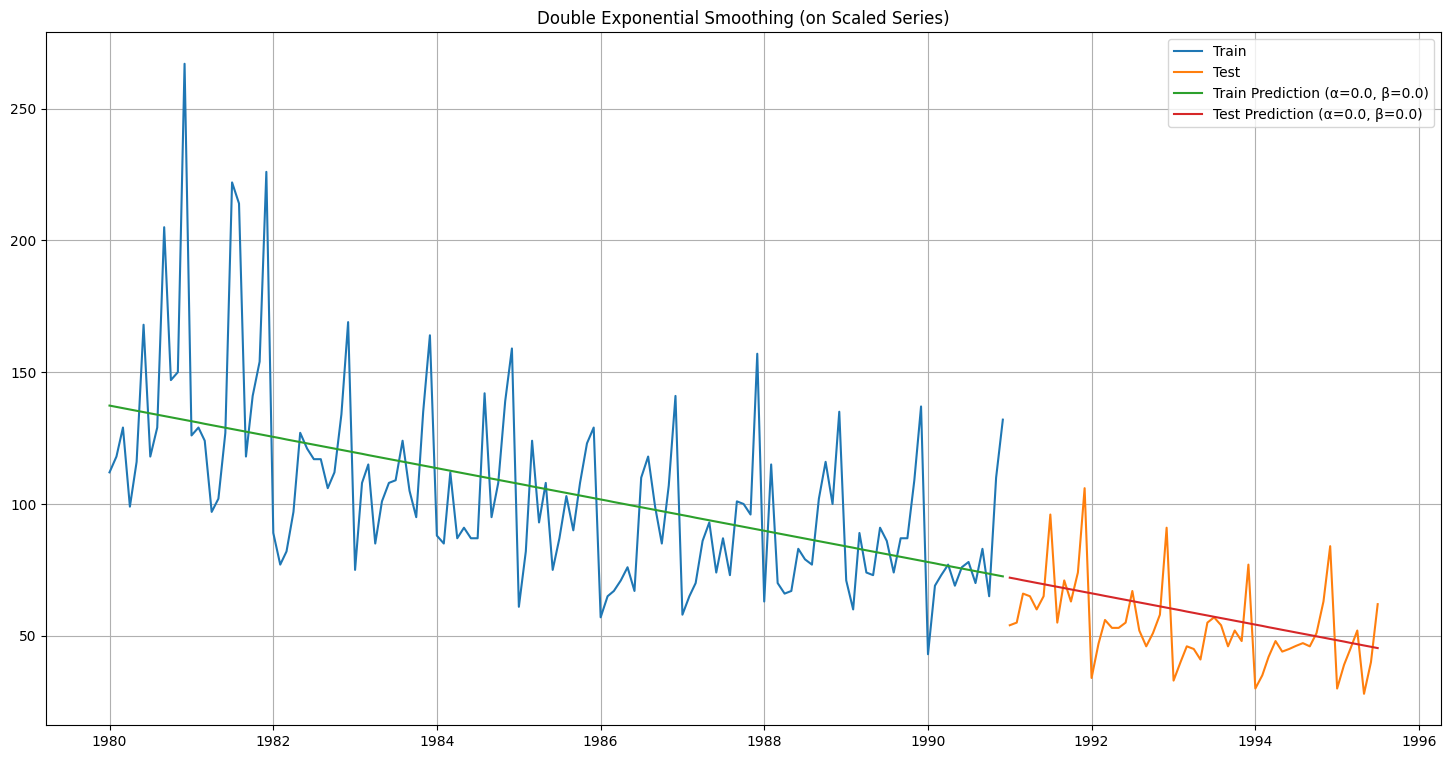

In [89]:
plt.figure(figsize=(18, 9))
plt.plot(DES_train['Rose'], label='Train')
plt.plot(DES_test['Rose'], label='Test')
plt.plot(DES_train['DES_Pred'], label=f'Train Prediction (α={alpha}, β={beta})')
plt.plot(DES_test['DES_Pred'], label=f'Test Prediction (α={alpha}, β={beta})')
plt.title('Double Exponential Smoothing (on Scaled Series)')
plt.legend()
plt.grid()
plt.show()

In [90]:
rmse_model7_train = RMSE(DES_train['Rose'], DES_train['DES_Pred'])
mape_model7_train = MAPE(DES_train['Rose'], DES_train['DES_Pred'])

rmse_model7_test = RMSE(DES_test['Rose'], DES_test['DES_Pred'])
mape_model7_test = MAPE(DES_test['Rose'], DES_test['DES_Pred'])

print(f"Model 7 (DES) - Train RMSE: {rmse_model7_train}, Train MAPE: {mape_model7_train}% | Test RMSE: {rmse_model7_test}, Test MAPE: {mape_model7_test}%")

Model 7 (DES) - Train RMSE: 30.72, Train MAPE: 21.22% | Test RMSE: 15.25, Test MAPE: 22.69%


In [91]:
log_results(
    f'DoubleExpSmoothing_Alpha={alpha}_Beta={beta}_Model7',
    rmse_model7_train, mape_model7_train,
    rmse_model7_test, mape_model7_test,
    data_source="original"
)

In [92]:
resultsDF

Model  Train RMSE  Train MAPE  \
0                        RegressionModel_Model1       30.72       21.22   
1                                  Naive_Model2       45.06       36.38   
2                        SimpleAveraging_Model3       36.03       25.39   
3                    2-Point Trailing MA_Model4       19.47       12.47   
4                    4-Point Trailing MA_Model4       25.97       18.03   
5                    6-Point Trailing MA_Model4       28.46       20.41   
6                    9-Point Trailing MA_Model4       30.23       22.06   
7                     SimpleExpSmoothing_Model5       31.78       22.37   
8                    SES_FixedAlpha=0.07_Model6       32.65       23.02   
9  DoubleExpSmoothing_Alpha=0.0_Beta=0.0_Model7       30.72       21.22   

   Test RMSE  Test MAPE Data Source  
0      51.39      91.49    original  
1      79.67     144.91    original  
2      53.41      94.77    original  
3      11.53      13.57    original  
4      14.44      19.46    original  
5      14.55      20.82    original  
6      14.72      20.99    original  
7      37.54      65.20    original  
8      36.39      63.09    original  
9      15.25      22.69    original

## Model 8: Double Exponential Smoothing Model (0.01 to 1)

In [93]:
## Getting the Scaled Dataset
DES_train = train.copy()
DES_test = test.copy()

# Scale 'Rose' column
scaler = MinMaxScaler()
DES_train['Rose_Scaled'] = scaler.fit_transform(DES_train[['Rose']])
DES_test['Rose_Scaled'] = scaler.transform(DES_test[['Rose']])

In [94]:
grid_results = []

best_rmse = float('inf')
best_model = None
best_alpha, best_beta = None, None
best_train_preds, best_test_preds = None, None

In [95]:
for alpha in np.arange(0.1, 1.1, 0.1):
    for beta in np.arange(0.1, 1.1, 0.1):
        try:
            model = Holt(DES_train['Rose_Scaled'], initialization_method='estimated')
            model_fit = model.fit(
                smoothing_level=alpha,
                smoothing_trend=beta,
                optimized=False
            )
            
            train_preds_scaled = model_fit.fittedvalues
            test_preds_scaled = model_fit.forecast(steps=len(DES_test))

            # Inverse transform predictions
            train_preds = scaler.inverse_transform(train_preds_scaled.to_frame())
            test_preds = scaler.inverse_transform(test_preds_scaled.to_frame())

            # Evaluate
            rmse_train = RMSE(DES_train['Rose'], train_preds.flatten())
            mape_train = MAPE(DES_train['Rose'], train_preds.flatten())
            rmse_test = RMSE(DES_test['Rose'], test_preds.flatten())
            mape_test = MAPE(DES_test['Rose'], test_preds.flatten())

            # Store results
            grid_results.append({
                'Alpha': alpha,
                'Beta': beta,
                'Train RMSE': rmse_train,
                'Train MAPE': mape_train,
                'Test RMSE': rmse_test,
                'Test MAPE': mape_test
            })

            # Track best model
            if rmse_test < best_rmse:
                best_rmse = rmse_test
                best_model = model_fit
                best_alpha, best_beta = alpha, beta
                best_train_preds = train_preds
                best_test_preds = test_preds

        except:
            continue

In [96]:
resultsDf_8 = pd.DataFrame(grid_results)
resultsDf_8 = resultsDf_8.sort_values(by='Test RMSE', ascending=True).reset_index(drop=True)
display(resultsDf_8.head())

Alpha  Beta  Train RMSE  Train MAPE  Test RMSE  Test MAPE
0    0.1   0.1       35.12       25.18      36.83      63.57
1    0.1   0.2       33.99       24.85      48.58      82.85
2    0.2   0.1       33.27       23.85      65.68     113.03
3    0.1   0.3       33.52       24.86      78.07     131.01
4    0.3   0.1       33.67       23.92      98.60     169.90

In [97]:
best_row = resultsDf_8.sort_values('Test RMSE').iloc[0]
best_alpha = best_row['Alpha']
best_beta = best_row['Beta']

print(f"Best Parameters from Grid Search - α: {best_alpha}, β: {best_beta}")

Best Parameters from Grid Search - α: 0.1, β: 0.1


In [98]:
final_model_DES = Holt(DES_train['Rose_Scaled'], initialization_method='estimated')
final_model_fit = final_model_DES.fit(
    smoothing_level=best_alpha,
    smoothing_trend=best_beta)

In [99]:
# Full summary
print(final_model_fit.summary())

                              Holt Model Results                              
Dep. Variable:            Rose_Scaled   No. Observations:                  132
Model:                           Holt   SSE                              2.698
Optimized:                       True   AIC                           -505.501
Trend:                       Additive   BIC                           -493.970
Seasonal:                        None   AICC                          -504.829
Seasonal Periods:                None   Date:                 Sun, 13 Apr 2025
Box-Cox:                        False   Time:                         17:47:08
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.1000000                alpha                False
smoothing_trend            0.1000000                

In [100]:
# Clean param printout
final_model_fit.params_formatted

name     param  optimized
smoothing_level  alpha  0.100000      False
smoothing_trend   beta  0.100000      False
initial_level      l.0  0.457796       True
initial_trend      b.0  0.001380       True

In [101]:
final_model_fit.sse

np.float64(2.6983521330172455)

In [102]:
# Scaled predictions
train_preds_scaled = final_model_fit.fittedvalues
test_preds_scaled = final_model_fit.forecast(steps=len(DES_test))

In [103]:
# Inverse transform
train_preds = scaler.inverse_transform(train_preds_scaled.to_frame())
test_preds = scaler.inverse_transform(test_preds_scaled.to_frame())

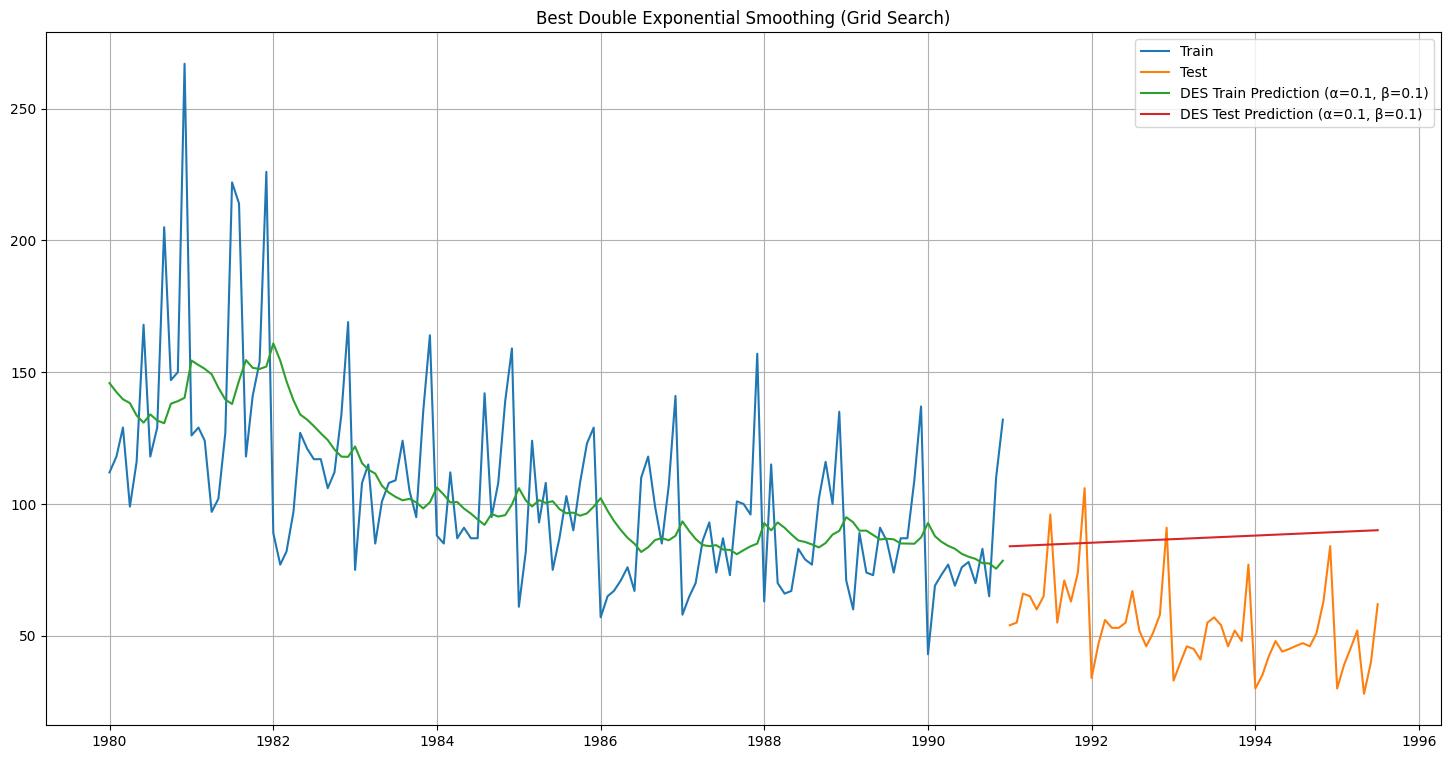

In [104]:
plt.figure(figsize=(18, 9))
plt.plot(DES_train['Rose'], label='Train')
plt.plot(DES_test['Rose'], label='Test')

plt.plot(DES_train.index, train_preds, label=f'DES Train Prediction (α={best_alpha}, β={best_beta})')
plt.plot(DES_test.index, test_preds, label=f'DES Test Prediction (α={best_alpha}, β={best_beta})')


plt.title('Best Double Exponential Smoothing (Grid Search)')
plt.legend()
plt.grid()
plt.show()

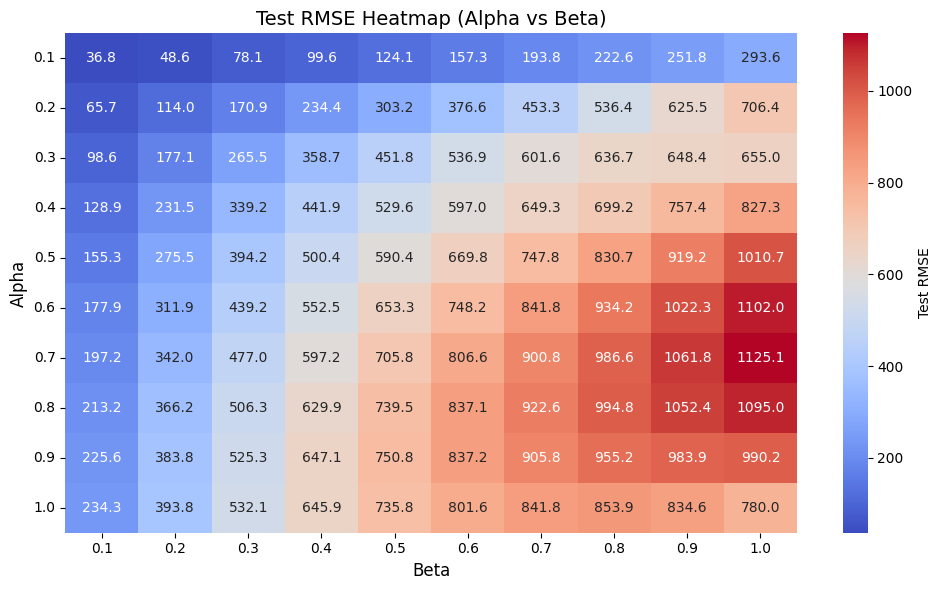

In [105]:
# Recreate pivot table from resultsDf_8
pivot_rmse = resultsDf_8.pivot(index='Alpha', columns='Beta', values='Test RMSE')
pivot_rmse.index = pivot_rmse.index.round(1)
pivot_rmse.columns = pivot_rmse.columns.round(1)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_rmse, annot=True, fmt='.1f', cmap='coolwarm', cbar_kws={'label': 'Test RMSE'})
plt.title('Test RMSE Heatmap (Alpha vs Beta)', fontsize=14)
plt.xlabel('Beta', fontsize=12)
plt.ylabel('Alpha', fontsize=12)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [106]:
log_results(
    f'DES_GridSearch_Alpha={best_alpha}_Beta={best_beta}_Model8',
    RMSE(DES_train['Rose'], train_preds.flatten()),
    MAPE(DES_train['Rose'], train_preds.flatten()),
    RMSE(DES_test['Rose'], test_preds.flatten()),
    MAPE(DES_test['Rose'], test_preds.flatten()),
    data_source="original" 
)

In [107]:
resultsDF

Model  Train RMSE  Train MAPE  \
0                         RegressionModel_Model1       30.72       21.22   
1                                   Naive_Model2       45.06       36.38   
2                         SimpleAveraging_Model3       36.03       25.39   
3                     2-Point Trailing MA_Model4       19.47       12.47   
4                     4-Point Trailing MA_Model4       25.97       18.03   
5                     6-Point Trailing MA_Model4       28.46       20.41   
6                     9-Point Trailing MA_Model4       30.23       22.06   
7                      SimpleExpSmoothing_Model5       31.78       22.37   
8                     SES_FixedAlpha=0.07_Model6       32.65       23.02   
9   DoubleExpSmoothing_Alpha=0.0_Beta=0.0_Model7       30.72       21.22   
10      DES_GridSearch_Alpha=0.1_Beta=0.1_Model8       32.03       22.78   

    Test RMSE  Test MAPE Data Source  
0       51.39      91.49    original  
1       79.67     144.91    original  
2       53.41      94.77    original  
3       11.53      13.57    original  
4       14.44      19.46    original  
5       14.55      20.82    original  
6       14.72      20.99    original  
7       37.54      65.20    original  
8       36.39      63.09    original  
9       15.25      22.69    original  
10      37.01      63.89    original

## Model 9: Triple Exponential Smoothing (Auto)

In [108]:
# scaling the train and test data
TES_train = train.copy()
TES_test = test.copy()

scaler = MinMaxScaler()
TES_train['Rose_Scaled'] = scaler.fit_transform(TES_train[['Rose']])
TES_test['Rose_Scaled'] = scaler.transform(TES_test[['Rose']])

In [109]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_TES = ExponentialSmoothing(
    TES_train['Rose_Scaled'],
    trend='add',
    seasonal='add',
    seasonal_periods=12,
    initialization_method='estimated'
)

model_TES_fit = model_TES.fit(optimized=True)

In [110]:
print(model_TES_fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:              Rose_Scaled   No. Observations:                  132
Model:             ExponentialSmoothing   SSE                              0.998
Optimized:                         True   AIC                           -612.820
Trend:                         Additive   BIC                           -566.695
Seasonal:                      Additive   AICC                          -606.767
Seasonal Periods:                    12   Date:                 Sun, 13 Apr 2025
Box-Cox:                          False   Time:                         17:47:08
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0886035                alpha                 True
smoothing_trend          

In [111]:
model_TES_fit.params

{'smoothing_level': np.float64(0.08860347896060028),
 'smoothing_trend': np.float64(1.3846039878166909e-15),
 'smoothing_seasonal': np.float64(6.010607521239577e-15),
 'damping_trend': nan,
 'initial_level': np.float64(0.4634309678801878),
 'initial_trend': np.float64(-0.0024505110451033566),
 'initial_seasons': array([-0.13919636, -0.08413952, -0.04825724, -0.09581623, -0.05636713,
        -0.0320767 ,  0.01213748,  0.03952385,  0.0215295 ,  0.01309122,
         0.09383065,  0.2825647 ]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [112]:
# get the predictions
train_preds_scaled = model_TES_fit.fittedvalues
test_preds_scaled = model_TES_fit.forecast(len(TES_test))

In [113]:
# Inverse transform predictions
train_preds_TES = scaler.inverse_transform(train_preds_scaled.to_frame())
test_preds_TES = scaler.inverse_transform(test_preds_scaled.to_frame())

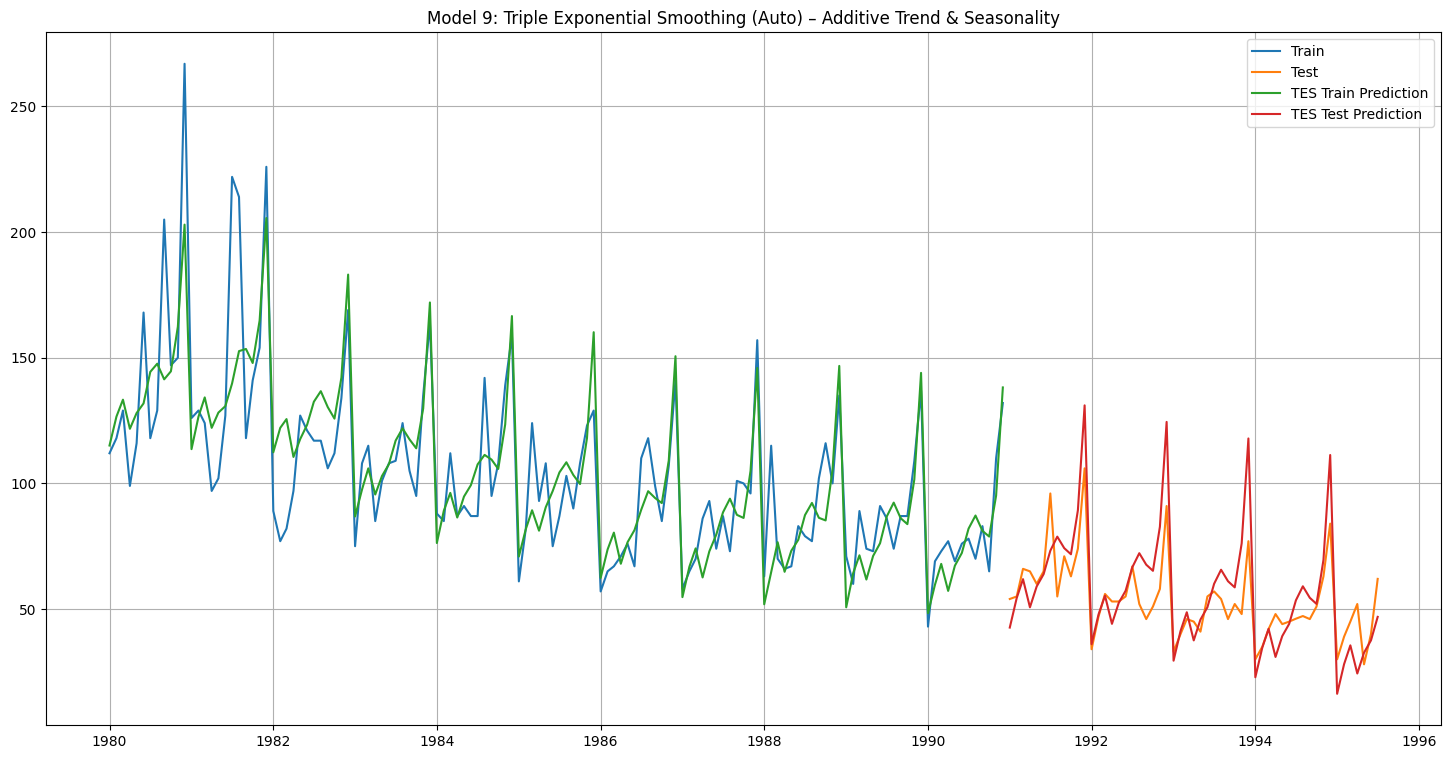

In [114]:
plt.figure(figsize=(18, 9))
plt.plot(TES_train.index, TES_train['Rose'], label='Train')
plt.plot(TES_test.index, TES_test['Rose'], label='Test')

plt.plot(TES_train.index, train_preds_TES, label='TES Train Prediction')
plt.plot(TES_test.index, test_preds_TES, label='TES Test Prediction')

plt.title('Model 9: Triple Exponential Smoothing (Auto) – Additive Trend & Seasonality')
plt.legend()
plt.grid()
plt.show()

In [115]:
rmse_model9_train = RMSE(TES_train['Rose'], train_preds_TES.flatten())
mape_model9_train = MAPE(TES_train['Rose'], train_preds_TES.flatten())

rmse_model9_test = RMSE(TES_test['Rose'], test_preds_TES.flatten())
mape_model9_test = MAPE(TES_test['Rose'], test_preds_TES.flatten())

print(f"Model 9 (TES Auto) - Train RMSE: {rmse_model9_train}, Train MAPE: {mape_model9_train}% | Test RMSE: {rmse_model9_test}, Test MAPE: {mape_model9_test}%")

Model 9 (TES Auto) - Train RMSE: 19.48, Train MAPE: 13.27% | Test RMSE: 14.23, Test MAPE: 19.16%


In [116]:
log_results(
    f'TES_Auto_AddTrend_AddSeasonality_Model9',
    rmse_model9_train, mape_model9_train,
    rmse_model9_test, mape_model9_test,
    data_source="original"
)

In [117]:
resultsDF

Model  Train RMSE  Train MAPE  \
0                         RegressionModel_Model1       30.72       21.22   
1                                   Naive_Model2       45.06       36.38   
2                         SimpleAveraging_Model3       36.03       25.39   
3                     2-Point Trailing MA_Model4       19.47       12.47   
4                     4-Point Trailing MA_Model4       25.97       18.03   
5                     6-Point Trailing MA_Model4       28.46       20.41   
6                     9-Point Trailing MA_Model4       30.23       22.06   
7                      SimpleExpSmoothing_Model5       31.78       22.37   
8                     SES_FixedAlpha=0.07_Model6       32.65       23.02   
9   DoubleExpSmoothing_Alpha=0.0_Beta=0.0_Model7       30.72       21.22   
10      DES_GridSearch_Alpha=0.1_Beta=0.1_Model8       32.03       22.78   
11       TES_Auto_AddTrend_AddSeasonality_Model9       19.48       13.27   

    Test RMSE  Test MAPE Data Source  
0       51.39      91.49    original  
1       79.67     144.91    original  
2       53.41      94.77    original  
3       11.53      13.57    original  
4       14.44      19.46    original  
5       14.55      20.82    original  
6       14.72      20.99    original  
7       37.54      65.20    original  
8       36.39      63.09    original  
9       15.25      22.69    original  
10      37.01      63.89    original  
11      14.23      19.16    original

## 10. Triple Exponential Smoothing (0.3 - 1.1)

In [118]:
# Create scaled train/test
TES_train = train.copy()
TES_test = test.copy()

scaler = MinMaxScaler()
TES_train['Rose_Scaled'] = scaler.fit_transform(TES_train[['Rose']])
TES_test['Rose_Scaled'] = scaler.transform(TES_test[['Rose']])

In [119]:
grid_results = []
best_rmse = float('inf')
best_model = None
best_params = {}

In [120]:
alphas = betas = gammas = np.arange(0.3, 1.1, 0.1)

for alpha in alphas:
    for beta in betas:
        for gamma in gammas:
            try:
                model = ExponentialSmoothing(
                    TES_train['Rose_Scaled'],
                    trend='add',
                    seasonal='add',
                    seasonal_periods=12,
                    initialization_method='estimated'
                )
                model_fit = model.fit(
                    smoothing_level=alpha,
                    smoothing_trend=beta,
                    smoothing_seasonal=gamma,
                    optimized=False
                )

                # Scaled predictions
                train_preds_scaled = model_fit.fittedvalues
                test_preds_scaled = model_fit.forecast(len(TES_test))

                # Inverse transform
                train_preds = scaler.inverse_transform(train_preds_scaled.to_frame())
                test_preds = scaler.inverse_transform(test_preds_scaled.to_frame())

                # Evaluate
                rmse_train = RMSE(TES_train['Rose'], train_preds.flatten())
                mape_train = MAPE(TES_train['Rose'], train_preds.flatten())
                rmse_test = RMSE(TES_test['Rose'], test_preds.flatten())
                mape_test = MAPE(TES_test['Rose'], test_preds.flatten())

                # Save result
                grid_results.append({
                    'Alpha': alpha, 'Beta': beta, 'Gamma': gamma,
                    'Train RMSE': rmse_train, 'Train MAPE': mape_train,
                    'Test RMSE': rmse_test, 'Test MAPE': mape_test
                })

                # Track best
                if rmse_test < best_rmse:
                    best_rmse = rmse_test
                    best_model = model_fit
                    best_params = {
                        'Alpha': alpha,
                        'Beta': beta,
                        'Gamma': gamma,
                        'train_preds': train_preds,
                        'test_preds': test_preds
                    }

            except Exception as e:
                continue

In [121]:
resultsDf_10 = pd.DataFrame(grid_results)
resultsDf_10 = resultsDf_10.sort_values(by='Test RMSE').reset_index(drop=True)
display(resultsDf_10.head())

Alpha  Beta  Gamma  Train RMSE  Train MAPE  Test RMSE  Test MAPE
0    0.3   0.3    0.4       25.31       18.48      12.74      17.01
1    0.3   0.3    0.3       24.28       17.78      12.95      17.47
2    0.4   0.3    0.3       25.45       18.15      13.32      18.61
3    0.5   0.3    0.4       27.93       19.54      17.96      26.23
4    0.6   0.4    0.3       29.46       20.60      23.46      36.31

In [122]:
# extract the best model params
best_row = resultsDf_10.iloc[0]
best_alpha = best_row['Alpha']
best_beta = best_row['Beta']
best_gamma = best_row['Gamma']

print(f"Best TES Grid Params - α={best_alpha}, β={best_beta}, γ={best_gamma}")

Best TES Grid Params - α=0.3, β=0.3, γ=0.4


In [123]:
# best model with optimized=False on scaled data
final_model_TES = ExponentialSmoothing(
    TES_train['Rose_Scaled'],
    trend='add',
    seasonal='add',
    seasonal_periods=12,
    initialization_method='estimated'
)


final_model_fit_TES = final_model_TES.fit(
    smoothing_level=best_alpha,
    smoothing_trend=best_beta,
    smoothing_seasonal=best_gamma,
    optimized=False
)

In [124]:
print(final_model_fit_TES.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:              Rose_Scaled   No. Observations:                  132
Model:             ExponentialSmoothing   SSE                              1.685
Optimized:                        False   AIC                           -543.652
Trend:                         Additive   BIC                           -497.527
Seasonal:                      Additive   AICC                          -537.599
Seasonal Periods:                    12   Date:                 Sun, 13 Apr 2025
Box-Cox:                          False   Time:                         17:47:12
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3000000                alpha                False
smoothing_trend          

In [125]:
final_model_fit_TES.params

{'smoothing_level': 0.3,
 'smoothing_trend': 0.3,
 'smoothing_seasonal': 0.4,
 'damping_trend': nan,
 'initial_level': np.float64(0.4565848214285711),
 'initial_trend': np.float64(0.0034124729437229814),
 'initial_seasons': array([-0.13609096, -0.11181641, -0.06935919, -0.13720703, -0.07349795,
        -0.04341053,  0.05554781,  0.07828776,  0.02480934, -0.01736886,
         0.07140532,  0.35870071]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [126]:
# model predictions
train_preds_scaled = final_model_fit_TES.fittedvalues
test_preds_scaled = final_model_fit_TES.forecast(len(TES_test))

In [127]:
# inverse predictions
train_preds = scaler.inverse_transform(train_preds_scaled.to_frame())
test_preds = scaler.inverse_transform(test_preds_scaled.to_frame())

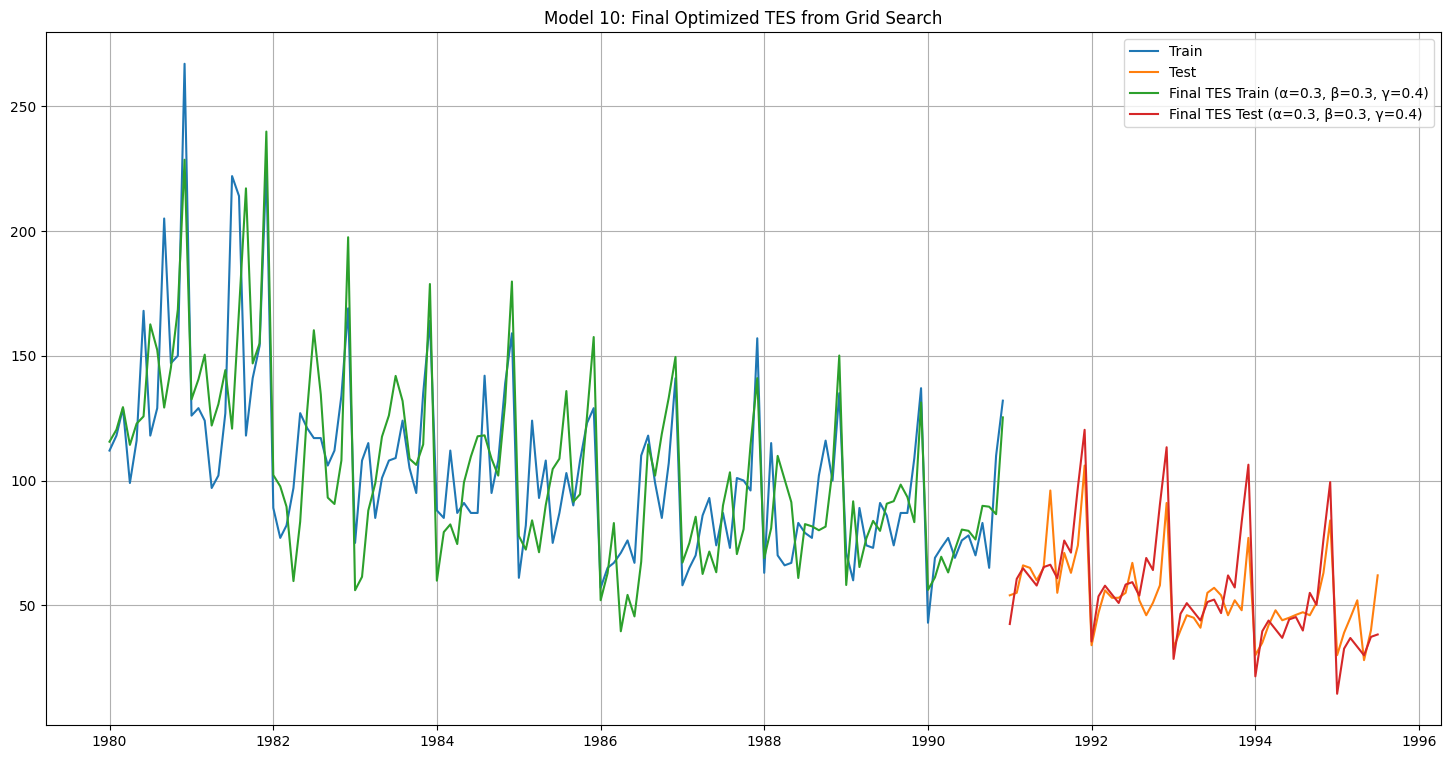

In [128]:
plt.figure(figsize=(18, 9))
plt.plot(TES_train.index, TES_train['Rose'], label='Train')
plt.plot(TES_test.index, TES_test['Rose'], label='Test')

plt.plot(TES_train.index, train_preds, label=f"Final TES Train (α={best_alpha}, β={best_beta}, γ={best_gamma})")
plt.plot(TES_test.index, test_preds, label=f"Final TES Test (α={best_alpha}, β={best_beta}, γ={best_gamma})")

plt.title('Model 10: Final Optimized TES from Grid Search')
plt.legend()
plt.grid()
plt.show()

In [129]:
rmse_model10_train = RMSE(TES_train['Rose'], train_preds.flatten())
mape_model10_train = MAPE(TES_train['Rose'], train_preds.flatten())

rmse_model10_test = RMSE(TES_test['Rose'], test_preds.flatten())
mape_model10_test = MAPE(TES_test['Rose'], test_preds.flatten())

In [130]:
print(f"Model 10 (Final TES) - Train RMSE: {rmse_model10_train}, MAPE: {mape_model10_train}%")
print(f"Model 10 (Final TES) - Test RMSE: {rmse_model10_test}, MAPE: {mape_model10_test}%")

log_results(
    f"TES_Final_Alpha={best_alpha}_Beta={best_beta}_Gamma={best_gamma}_Model10",
    rmse_model10_train, mape_model10_train,
    rmse_model10_test, mape_model10_test,
    data_source = "original"
)

Model 10 (Final TES) - Train RMSE: 25.31, MAPE: 18.48%
Model 10 (Final TES) - Test RMSE: 12.74, MAPE: 17.01%


In [131]:
resultsDF

Model  Train RMSE  Train MAPE  \
0                           RegressionModel_Model1       30.72       21.22   
1                                     Naive_Model2       45.06       36.38   
2                           SimpleAveraging_Model3       36.03       25.39   
3                       2-Point Trailing MA_Model4       19.47       12.47   
4                       4-Point Trailing MA_Model4       25.97       18.03   
5                       6-Point Trailing MA_Model4       28.46       20.41   
6                       9-Point Trailing MA_Model4       30.23       22.06   
7                        SimpleExpSmoothing_Model5       31.78       22.37   
8                       SES_FixedAlpha=0.07_Model6       32.65       23.02   
9     DoubleExpSmoothing_Alpha=0.0_Beta=0.0_Model7       30.72       21.22   
10        DES_GridSearch_Alpha=0.1_Beta=0.1_Model8       32.03       22.78   
11         TES_Auto_AddTrend_AddSeasonality_Model9       19.48       13.27   
12  TES_Final_Alpha=0.3_Beta=0.3_Gamma=0.4_Model10       25.31       18.48   

    Test RMSE  Test MAPE Data Source  
0       51.39      91.49    original  
1       79.67     144.91    original  
2       53.41      94.77    original  
3       11.53      13.57    original  
4       14.44      19.46    original  
5       14.55      20.82    original  
6       14.72      20.99    original  
7       37.54      65.20    original  
8       36.39      63.09    original  
9       15.25      22.69    original  
10      37.01      63.89    original  
11      14.23      19.16    original  
12      12.74      17.01    original

## 11. ARIMA Model based on AIC Optimization

In [132]:
p = q = range(0,4)
d = [1]

# combinations
import itertools
pdq = list(itertools.product(p,d,q))
print(f"Total ARIMA combinations to evaluate: {len(pdq)}")

Total ARIMA combinations to evaluate: 16


In [133]:
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm  # Progress bar

ARIMA_AIC = pd.DataFrame(columns=['param', 'AIC'])

for param in tqdm(pdq):
    try:
        model = ARIMA(train['Rose'], order=param)
        model_fit = model.fit()
        ARIMA_AIC.loc[len(ARIMA_AIC)] = [param, model_fit.aic]
    except:
        continue

# Sort by AIC
ARIMA_AIC = ARIMA_AIC.sort_values(by='AIC').reset_index(drop=True)
ARIMA_AIC

 69%|█████████████████████████████▌             | 11/16 [00:00<00:00, 22.40it/s]/home/anmol/miniconda3/envs/timeseries/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 88%|█████████████████████████████████████▋     | 14/16 [00:00<00:00, 16.47it/s]/home/anmol/miniconda3/envs/timeseries/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/anmol/miniconda3/envs/timeseries/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/anmol/miniconda3/envs/timeseries/lib/python3.10/s

param          AIC
0   (2, 1, 3)  1274.694834
1   (3, 1, 3)  1278.667025
2   (0, 1, 2)  1279.671529
3   (1, 1, 2)  1279.870723
4   (0, 1, 3)  1280.545376
5   (1, 1, 1)  1280.574230
6   (2, 1, 1)  1281.507862
7   (2, 1, 2)  1281.870722
8   (1, 1, 3)  1281.870722
9   (0, 1, 1)  1282.309832
10  (3, 1, 1)  1282.419278
11  (3, 1, 2)  1283.720741
12  (3, 1, 0)  1297.481092
13  (2, 1, 0)  1298.611034
14  (1, 1, 0)  1317.350311
15  (0, 1, 0)  1333.154673

In [134]:
best_order = ARIMA_AIC.iloc[0]['param']
print(f"Best ARIMA order based on AIC: {best_order}")

Best ARIMA order based on AIC: (2, 1, 3)


In [135]:
from statsmodels.tsa.arima.model import ARIMA

final_arima_model = ARIMA(train['Rose'], order=best_order)
final_arima_fit = final_arima_model.fit(method_kwargs={"maxiter": 2000})

In [136]:
final_arima_fit.mle_retvals

{'fopt': np.float64(4.782925826946459),
 'gopt': array([ 2.38395970e-06,  9.35447275e-06,  4.09460910e-05, -3.97015754e-08,
        -1.33679734e-06, -9.44666567e-07]),
 'fcalls': 595,
 'warnflag': 0,
 'converged': True,
 'iterations': 73}

In [137]:
print(final_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   Rose   No. Observations:                  132
Model:                 ARIMA(2, 1, 3)   Log Likelihood                -631.346
Date:                Sun, 13 Apr 2025   AIC                           1274.692
Time:                        17:47:14   BIC                           1291.944
Sample:                    01-01-1980   HQIC                          1281.702
                         - 12-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6779      0.084    -20.031      0.000      -1.842      -1.514
ar.L2         -0.7287      0.084     -8.698      0.000      -0.893      -0.564
ma.L1          1.0469      9.400      0.111      0.9

In [138]:
print(final_arima_fit.params)

ar.L1      -1.677869
ar.L2      -0.728658
ma.L1       1.046853
ma.L2      -0.771577
ma.L3      -0.906601
sigma2    857.583316
dtype: float64


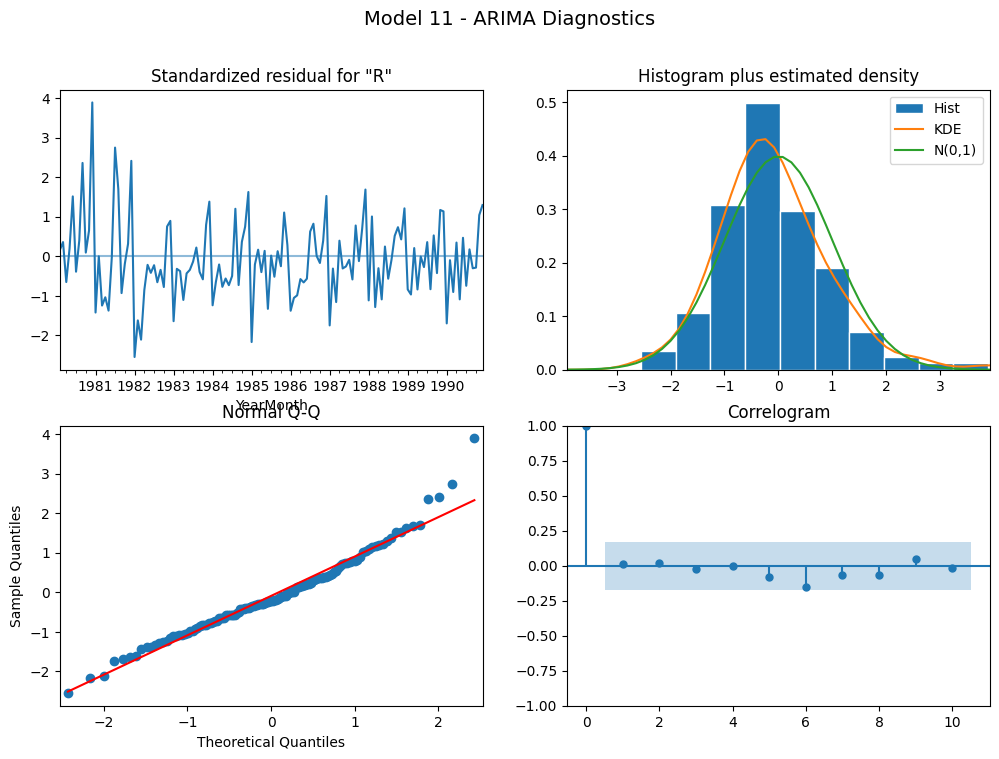

In [139]:
final_arima_fit.plot_diagnostics(figsize=(12, 8))
plt.suptitle("Model 11 - ARIMA Diagnostics", fontsize=14)
plt.show()

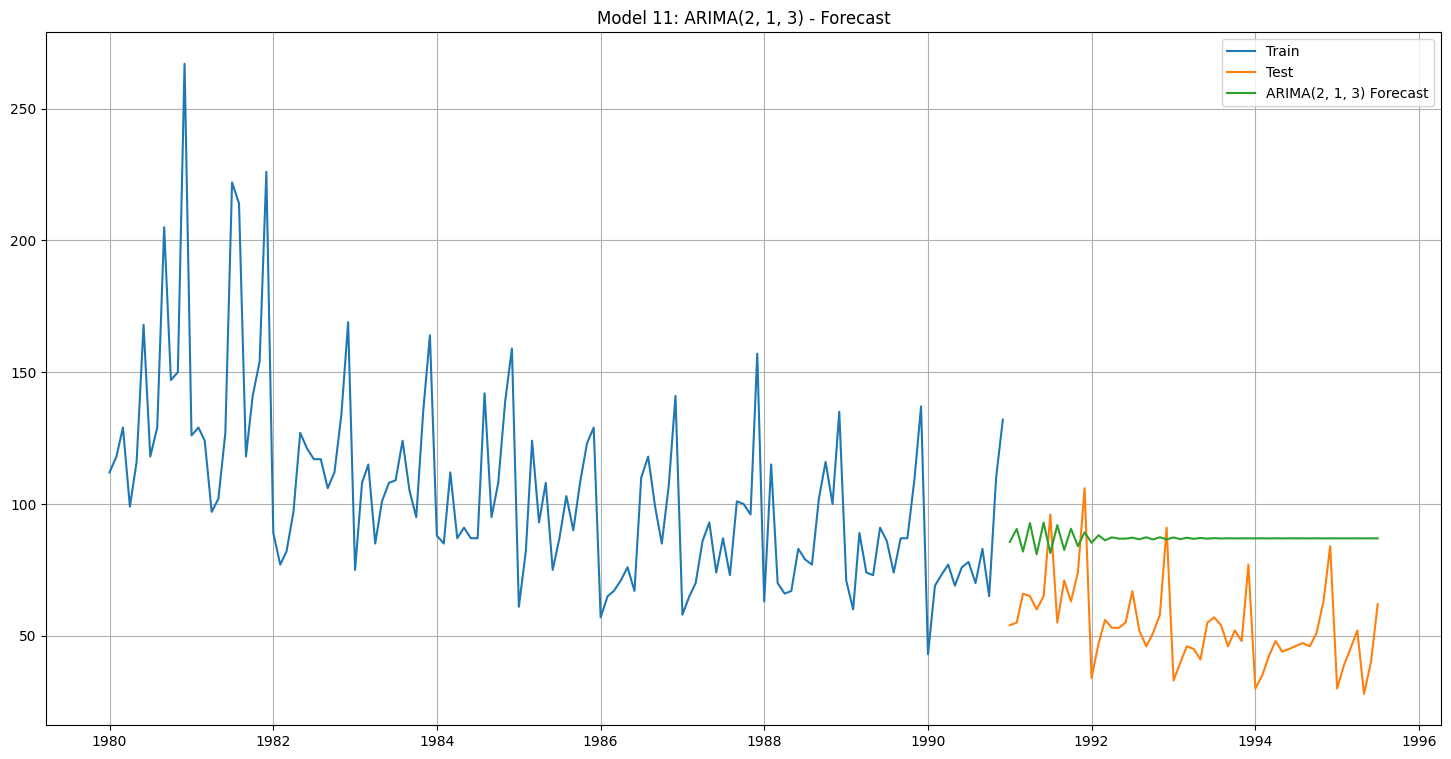

In [140]:
predicted_autoARIMA = final_arima_fit.forecast(steps=len(test))

plt.figure(figsize=(18, 9))
plt.plot(train['Rose'], label='Train')
plt.plot(test['Rose'], label='Test')
plt.plot(test.index, predicted_autoARIMA, label=f"ARIMA{best_order} Forecast")

plt.title(f"Model 11: ARIMA{best_order} - Forecast")
plt.legend()
plt.grid()
plt.show()

In [141]:
# Get in-sample predictions (on training data)
train_preds_arima = final_arima_fit.predict(start=train.index[0], end=train.index[-1])

# Evaluate
rmse_arima_train = RMSE(train['Rose'], train_preds_arima)
mape_arima_train = MAPE(train['Rose'], train_preds_arima)

print(f"Model 11 ARIMA - Train RMSE: {rmse_arima_train}, MAPE: {mape_arima_train}%")

Model 11 ARIMA - Train RMSE: 31.54, MAPE: 22.62%


In [142]:
rmse_arima_test = RMSE(test['Rose'], predicted_autoARIMA)
mape_arima_test = MAPE(test['Rose'], predicted_autoARIMA)

print(f"Model 11 (ARIMA{best_order}) - RMSE: {rmse_arima_test}, MAPE: {mape_arima_test}%")

Model 11 (ARIMA(2, 1, 3)) - RMSE: 36.77, MAPE: 63.77%


In [143]:
log_results(
    f'ARIMA_{best_order}_Model11',
    rmse_arima_train, mape_arima_train, 
    rmse_arima_test, mape_arima_test,
    data_source='original data | 1st diff in Model' 
)

In [144]:
resultsDF

Model  Train RMSE  Train MAPE  \
0                           RegressionModel_Model1       30.72       21.22   
1                                     Naive_Model2       45.06       36.38   
2                           SimpleAveraging_Model3       36.03       25.39   
3                       2-Point Trailing MA_Model4       19.47       12.47   
4                       4-Point Trailing MA_Model4       25.97       18.03   
5                       6-Point Trailing MA_Model4       28.46       20.41   
6                       9-Point Trailing MA_Model4       30.23       22.06   
7                        SimpleExpSmoothing_Model5       31.78       22.37   
8                       SES_FixedAlpha=0.07_Model6       32.65       23.02   
9     DoubleExpSmoothing_Alpha=0.0_Beta=0.0_Model7       30.72       21.22   
10        DES_GridSearch_Alpha=0.1_Beta=0.1_Model8       32.03       22.78   
11         TES_Auto_AddTrend_AddSeasonality_Model9       19.48       13.27   
12  TES_Final_Alpha=0.3_Beta=0.3_Gamma=0.4_Model10       25.31       18.48   
13                         ARIMA_(2, 1, 3)_Model11       31.54       22.62   

    Test RMSE  Test MAPE                        Data Source  
0       51.39      91.49                           original  
1       79.67     144.91                           original  
2       53.41      94.77                           original  
3       11.53      13.57                           original  
4       14.44      19.46                           original  
5       14.55      20.82                           original  
6       14.72      20.99                           original  
7       37.54      65.20                           original  
8       36.39      63.09                           original  
9       15.25      22.69                           original  
10      37.01      63.89                           original  
11      14.23      19.16                           original  
12      12.74      17.01                           original  
13      36.77      63.77  original data | 1st diff in Model

## Automated SARIMA model (seasonality of 12)

In [145]:
p = q = range(0, 3)
d = [1]  # will turn the data to 1st differencing internally in model
P = Q = range(0, 3)
D = [0] # we are not doing seasonal stationarity
s = 12  # seasonal period

# all combinations
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q))

print(f"Total combinations: {len(pdq) * len(seasonal_pdq)}")

Total combinations: 81


In [146]:
import warnings
import statsmodels.api as sm

SARIMA_AIC = pd.DataFrame(columns=['param', 'seasonal', 'AIC'])

for param in tqdm(pdq):
    for seasonal in seasonal_pdq:
        seasonal_order = (seasonal[0], seasonal[1], seasonal[2], s)
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                model = sm.tsa.statespace.SARIMAX(train['Rose'],
                                                  order=param,
                                                  seasonal_order=seasonal_order,
                                                  enforce_stationarity=False,
                                                  enforce_invertibility=False)
                model_fit = model.fit(disp=False)
                SARIMA_AIC.loc[len(SARIMA_AIC)] = [param, seasonal_order, model_fit.aic]
        except Exception as e:
            print(f"Failed for {param} x {seasonal_order} → {e}")

SARIMA_AIC = SARIMA_AIC.sort_values(by='AIC').reset_index(drop=True)
display(SARIMA_AIC.head())

100%|█████████████████████████████████████████████| 9/9 [00:20<00:00,  2.23s/it]


param       seasonal         AIC
0  (0, 1, 2)  (2, 0, 2, 12)  887.937509
1  (2, 1, 2)  (2, 0, 2, 12)  890.668798
2  (2, 1, 1)  (2, 0, 0, 12)  896.518161
3  (2, 1, 2)  (2, 0, 0, 12)  897.346444
4  (2, 1, 1)  (2, 0, 1, 12)  897.639957

In [147]:
best_order = SARIMA_AIC.iloc[0]['param']
best_seasonal = SARIMA_AIC.iloc[0]['seasonal']

print(f"Best SARIMA Order: {best_order} x {best_seasonal}")

final_sarima = sm.tsa.statespace.SARIMAX(train['Rose'],
                                         order=best_order,
                                         seasonal_order=best_seasonal,
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)
final_sarima_fit = final_sarima.fit(maxiter=2000)

Best SARIMA Order: (0, 1, 2) x (2, 0, 2, 12)


In [148]:
final_sarima_fit.mle_retvals

{'fopt': np.float64(3.3103693506364418),
 'gopt': array([-1.27415856e-05, -2.34141595e-05,  4.33413305e-06,  1.54907642e-05,
        -3.72515352e-06,  6.08944006e-06,  4.21263024e-07]),
 'fcalls': 272,
 'warnflag': 0,
 'converged': True,
 'iterations': 27}

In [149]:
print(final_sarima_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               Rose   No. Observations:                  132
Model:             SARIMAX(0, 1, 2)x(2, 0, 2, 12)   Log Likelihood                -436.969
Date:                            Sun, 13 Apr 2025   AIC                            887.938
Time:                                    17:47:35   BIC                            906.448
Sample:                                01-01-1980   HQIC                           895.437
                                     - 12-01-1990                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8427    189.939     -0.004      0.996    -373.117     371.431
ma.L2         -0.1573     29.840   

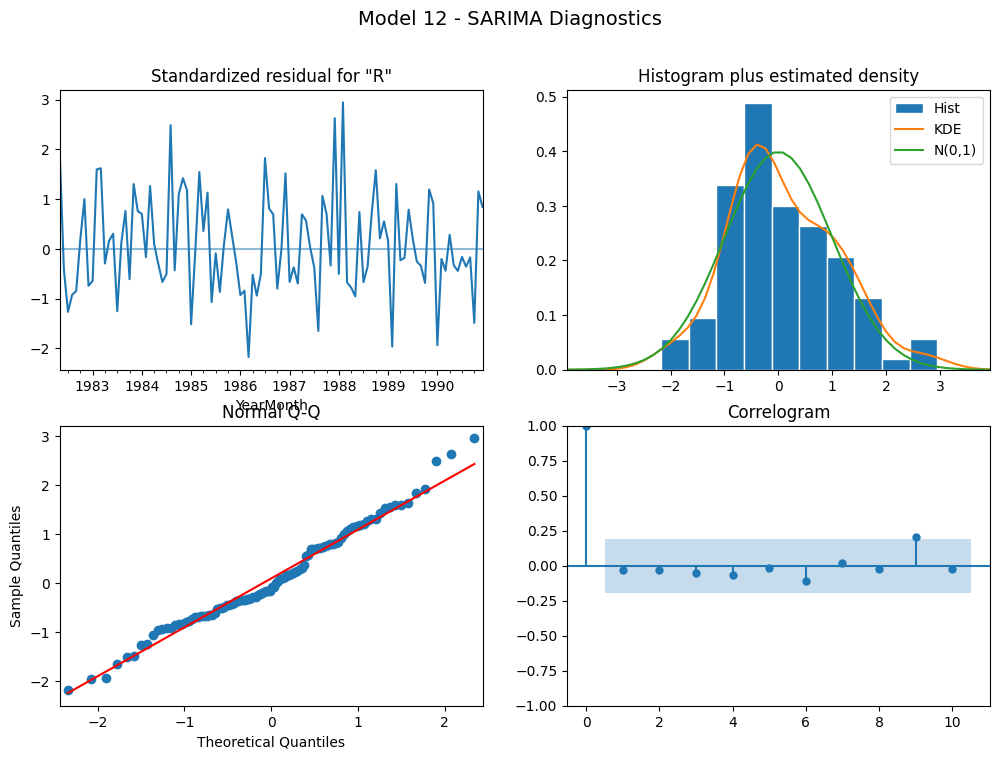

In [150]:
final_sarima_fit.plot_diagnostics(figsize=(12, 8))
plt.suptitle("Model 12 - SARIMA Diagnostics", fontsize=14)
plt.show()

In [151]:
# get the predictions
train_preds_sarima = final_sarima_fit.predict(start=train.index[0], end=train.index[-1], typ='levels')
test_preds_sarima = final_sarima_fit.forecast(steps=len(test))

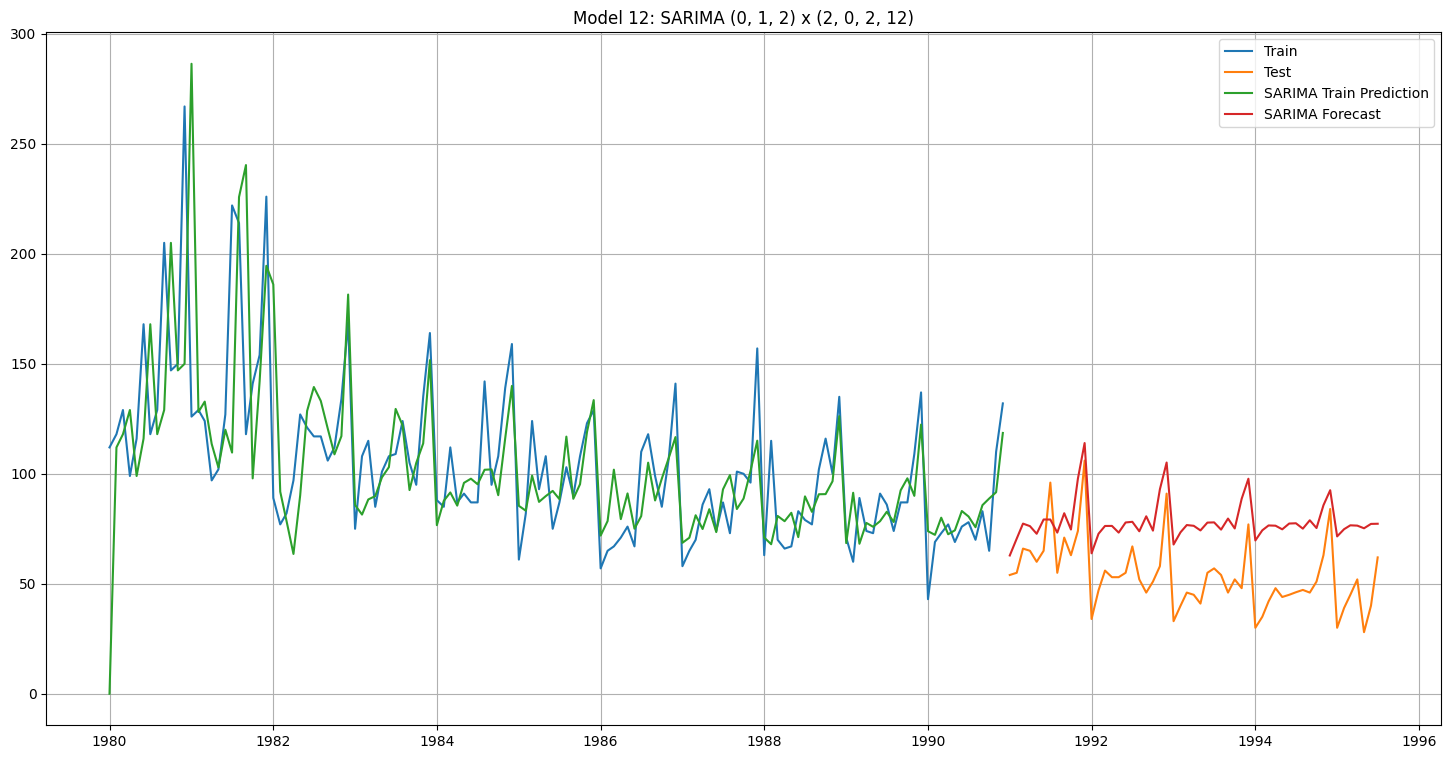

In [152]:
plt.figure(figsize=(18, 9))
plt.plot(train['Rose'], label='Train')
plt.plot(test['Rose'], label='Test')

plt.plot(train.index, train_preds_sarima, label='SARIMA Train Prediction')
plt.plot(test.index, test_preds_sarima, label='SARIMA Forecast')

plt.title(f"Model 12: SARIMA {best_order} x {best_seasonal}")
plt.legend()
plt.grid()
plt.show()

In [153]:
rmse_sarima_train = RMSE(train['Rose'], train_preds_sarima)
mape_sarima_train = MAPE(train['Rose'], train_preds_sarima)

rmse_sarima_test = RMSE(test['Rose'], test_preds_sarima)
mape_sarima_test = MAPE(test['Rose'], test_preds_sarima)

print(f"Model 12 (SARIMA) - Train RMSE: {rmse_sarima_train}, MAPE: {mape_sarima_train}%")
print(f"Model 12 (SARIMA) - Test RMSE: {rmse_sarima_test}, MAPE: {mape_sarima_test}%")

Model 12 (SARIMA) - Train RMSE: 32.23, MAPE: 18.55%
Model 12 (SARIMA) - Test RMSE: 26.88, MAPE: 46.48%


In [154]:
log_results(
    f"SARIMA_{best_order}_x_{best_seasonal}_Model12",
    rmse_sarima_train, mape_sarima_train,
    rmse_sarima_test, mape_sarima_test,
    data_source = "original data | 1st diff Model"
)

In [155]:
resultsDF

Model  Train RMSE  Train MAPE  \
0                           RegressionModel_Model1       30.72       21.22   
1                                     Naive_Model2       45.06       36.38   
2                           SimpleAveraging_Model3       36.03       25.39   
3                       2-Point Trailing MA_Model4       19.47       12.47   
4                       4-Point Trailing MA_Model4       25.97       18.03   
5                       6-Point Trailing MA_Model4       28.46       20.41   
6                       9-Point Trailing MA_Model4       30.23       22.06   
7                        SimpleExpSmoothing_Model5       31.78       22.37   
8                       SES_FixedAlpha=0.07_Model6       32.65       23.02   
9     DoubleExpSmoothing_Alpha=0.0_Beta=0.0_Model7       30.72       21.22   
10        DES_GridSearch_Alpha=0.1_Beta=0.1_Model8       32.03       22.78   
11         TES_Auto_AddTrend_AddSeasonality_Model9       19.48       13.27   
12  TES_Final_Alpha=0.3_Beta=0.3_Gamma=0.4_Model10       25.31       18.48   
13                         ARIMA_(2, 1, 3)_Model11       31.54       22.62   
14        SARIMA_(0, 1, 2)_x_(2, 0, 2, 12)_Model12       32.23       18.55   

    Test RMSE  Test MAPE                        Data Source  
0       51.39      91.49                           original  
1       79.67     144.91                           original  
2       53.41      94.77                           original  
3       11.53      13.57                           original  
4       14.44      19.46                           original  
5       14.55      20.82                           original  
6       14.72      20.99                           original  
7       37.54      65.20                           original  
8       36.39      63.09                           original  
9       15.25      22.69                           original  
10      37.01      63.89                           original  
11      14.23      19.16                           original  
12      12.74      17.01                           original  
13      36.77      63.77  original data | 1st diff in Model  
14      26.88      46.48     original data | 1st diff Model

## Model 13: ARIMA with params using ACF and PACF

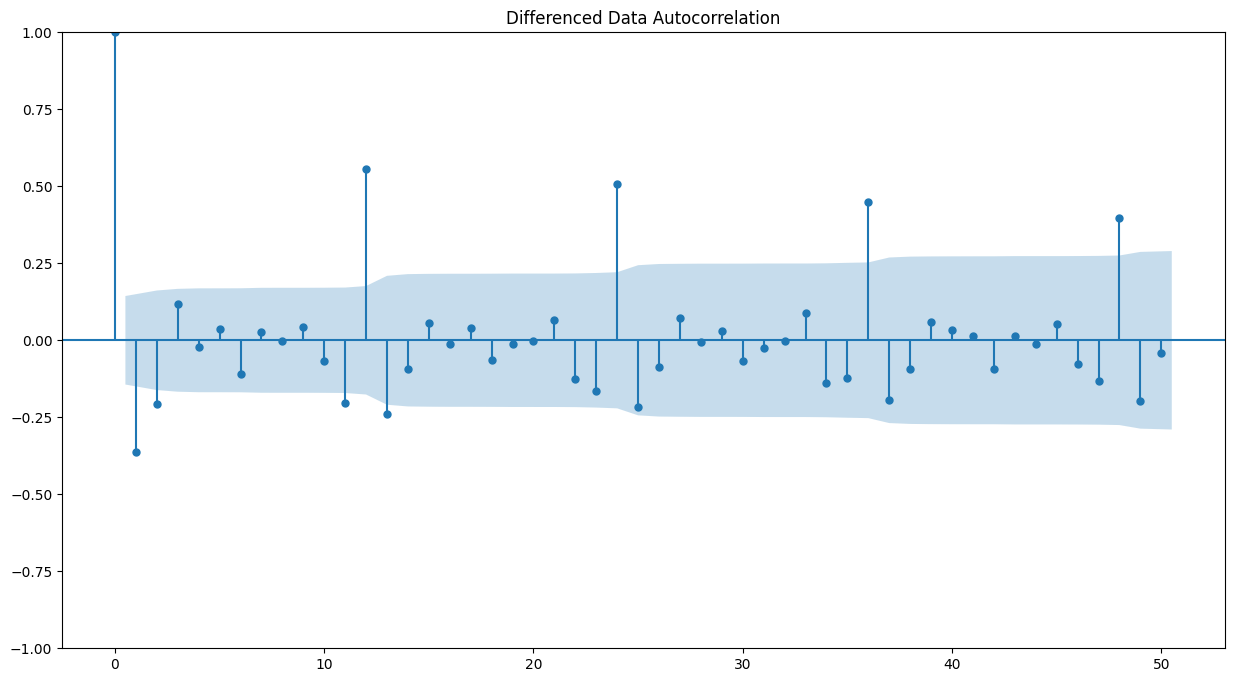

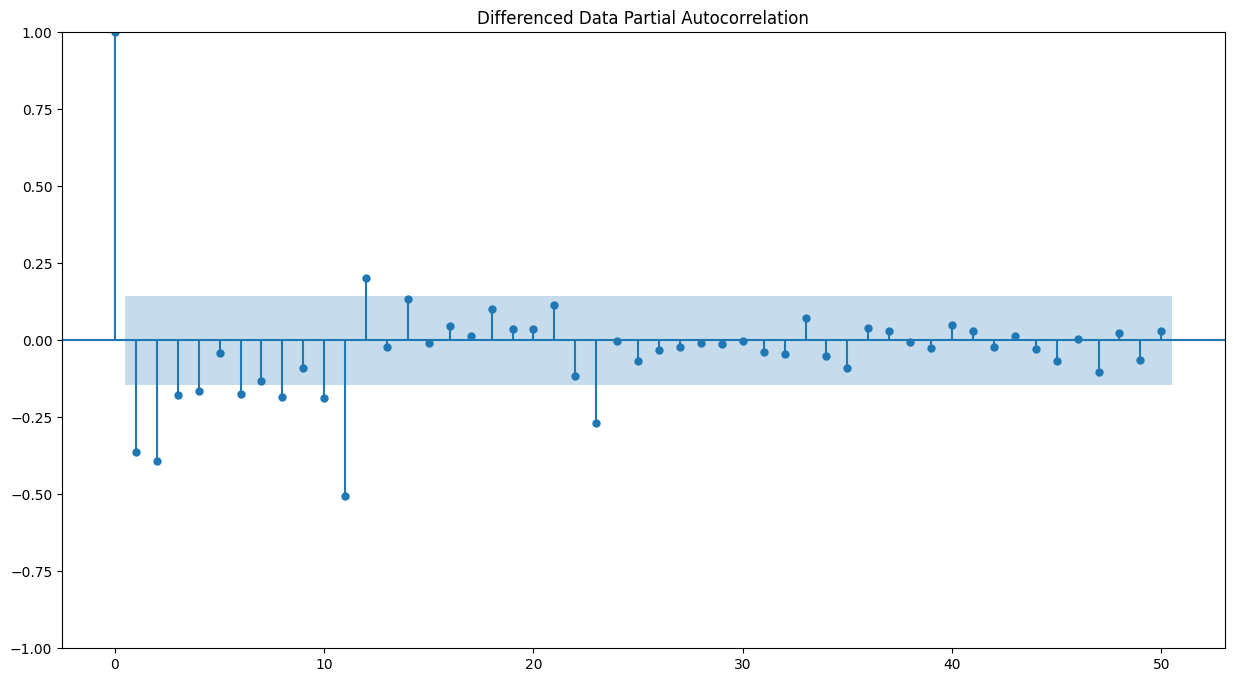

In [156]:
plot_acf(df['Rose'].diff(1).dropna(),lags=50,title='Differenced Data Autocorrelation')
plot_pacf(df['Rose'].diff(1).dropna(),lags=50,title='Differenced Data Partial Autocorrelation')
plt.show()

In [157]:
manual_train = df.iloc[:int(len(df)*0.71)]
manual_test = df.iloc[int(len(df)*0.71):]

In [158]:
def fit_and_evaluate_arima(order, model_name):
    from statsmodels.tsa.arima.model import ARIMA
    
    # Fit ARIMA on original (non-differenced) series
    model = ARIMA(df['Rose'], order=order) 
    model_fit = model.fit()

    print(f"Summary for {model_name}")
    print(model_fit.summary())
    model_fit.plot_diagnostics(figsize=(12, 8))
    plt.suptitle(f"{model_name} Diagnostics")
    plt.show()

    # model params
    print(model_fit.mle_retvals)
    print("\n")
    print(model_fit.params)
    
    # Train predictions
    train_preds = model_fit.predict(start=train.index[0], end=train.index[-1])
    
    # Test forecasts (aligned with test index)
    test_preds = model_fit.forecast(steps=len(test))
    test_preds.index = test.index  # force index match to align for plotting & metrics

    # Evaluation
    rmse_train = RMSE(train['Rose'], train_preds)
    mape_train = MAPE(train['Rose'], train_preds)

    rmse_test = RMSE(test['Rose'], test_preds)
    mape_test = MAPE(test['Rose'], test_preds)

    print(f"{model_name} → Train RMSE: {rmse_train}, MAPE: {mape_train}%")
    print(f"{model_name} → Test RMSE: {rmse_test}, MAPE: {mape_test}%")

    # Plot
    plt.figure(figsize=(18, 9))
    plt.plot(train['Rose'], label='Train')
    plt.plot(test['Rose'], label='Test')
    plt.plot(test_preds, label=f'{model_name} Forecast')
    plt.title(f"{model_name} on Original Series (Forecast Aligned)")
    plt.legend()
    plt.grid()
    plt.show()
    
    # Log results
    log_results(
        f"{model_name}",
        rmse_train, mape_train,
        rmse_test, mape_test,
        data_source = "original data | 1st diff in Model"
    )


Summary for Manual_ARIMA_(2,1,1)_Model13
                               SARIMAX Results                                
Dep. Variable:                   Rose   No. Observations:                  187
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -882.311
Date:                Sun, 13 Apr 2025   AIC                           1772.622
Time:                        17:47:36   BIC                           1785.525
Sample:                    01-01-1980   HQIC                          1777.851
                         - 07-01-1995                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1511      0.063      2.386      0.017       0.027       0.275
ar.L2         -0.1120      0.082     -1.366      0.172      -0.273       0.049
ma.L1      

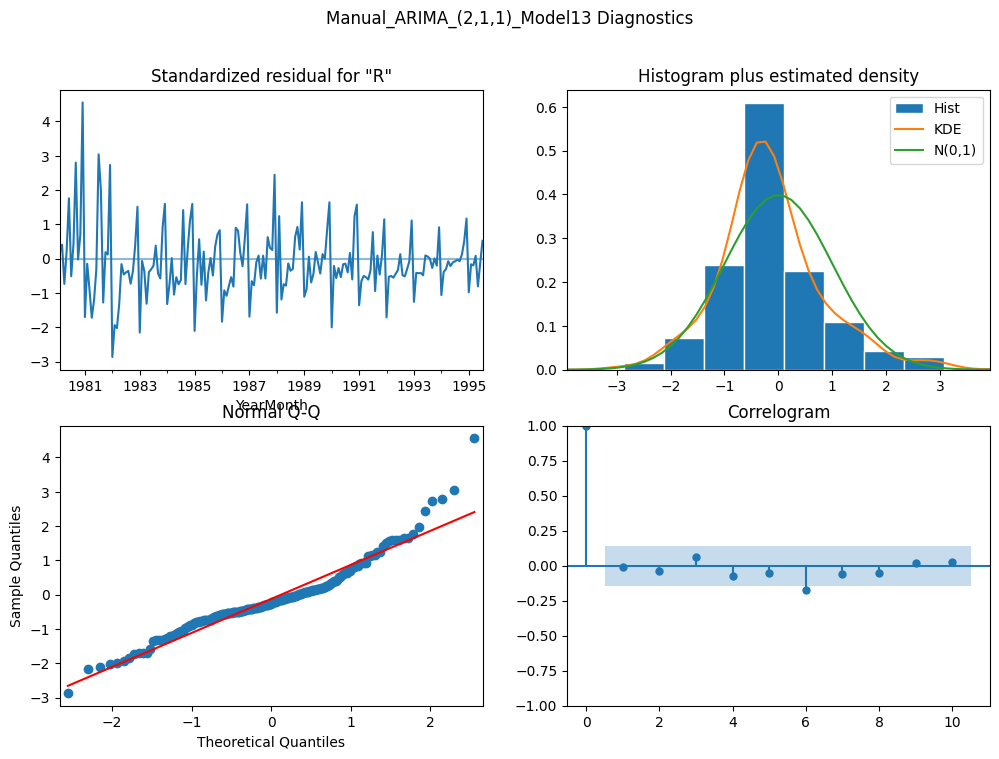

{'fopt': np.float64(4.718241656972626), 'gopt': array([ 2.90345525e-06,  1.35917944e-06,  3.81472631e-07, -4.65405492e-08]), 'fcalls': 95, 'warnflag': 0, 'converged': True, 'iterations': 17}


ar.L1       0.151115
ar.L2      -0.112021
ma.L1      -0.887594
sigma2    766.052096
dtype: float64
Manual_ARIMA_(2,1,1)_Model13 → Train RMSE: 32.6, MAPE: 22.88%
Manual_ARIMA_(2,1,1)_Model13 → Test RMSE: 16.76, MAPE: 21.69%


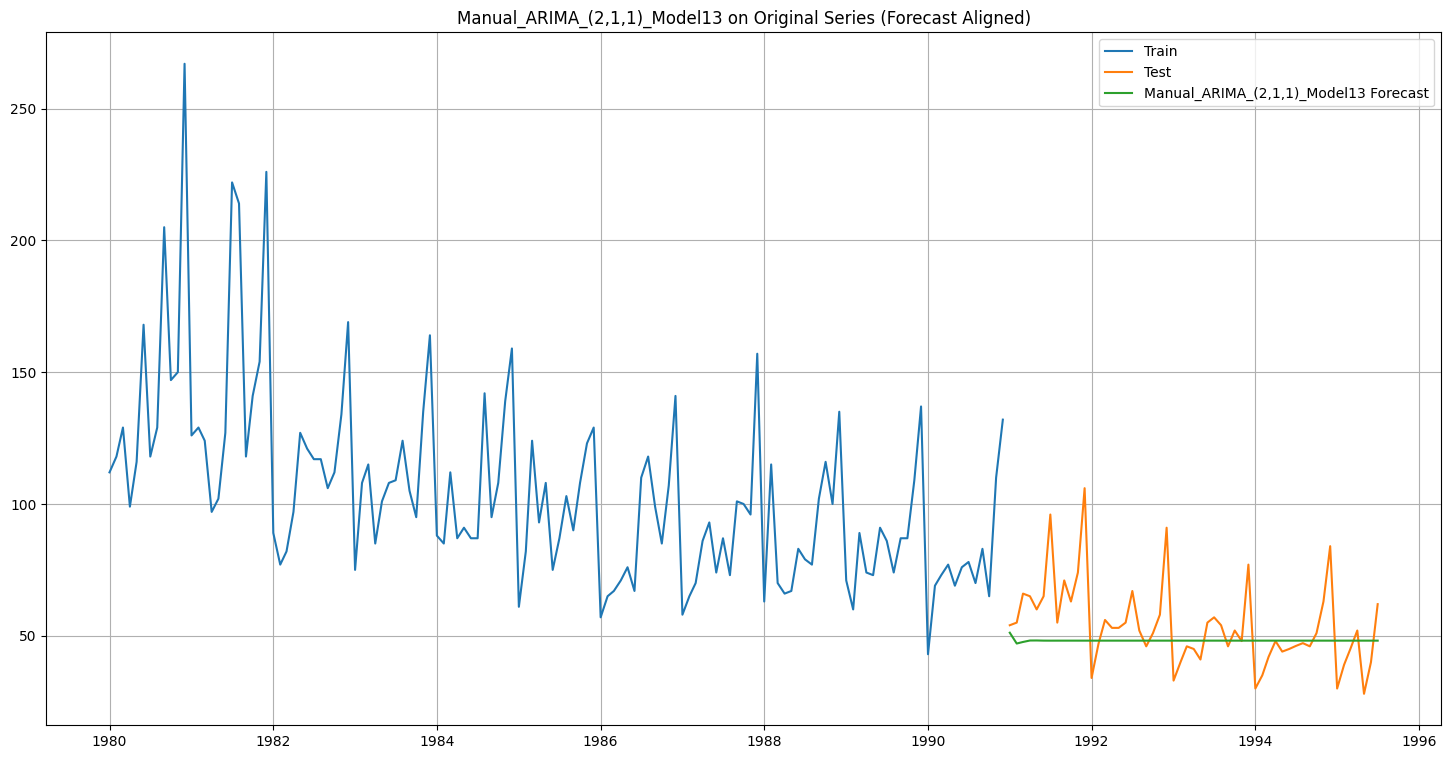

In [159]:
fit_and_evaluate_arima(order=(2,1,1), model_name='Manual_ARIMA_(2,1,1)_Model13')

Summary for Manual_ARIMA_(1,1,2)_Model13
                               SARIMAX Results                                
Dep. Variable:                   Rose   No. Observations:                  187
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -881.361
Date:                Sun, 13 Apr 2025   AIC                           1770.722
Time:                        17:47:36   BIC                           1783.625
Sample:                    01-01-1980   HQIC                          1775.950
                         - 07-01-1995                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4874      0.221     -2.204      0.027      -0.921      -0.054
ma.L1         -0.2267      0.206     -1.100      0.271      -0.631       0.177
ma.L2      

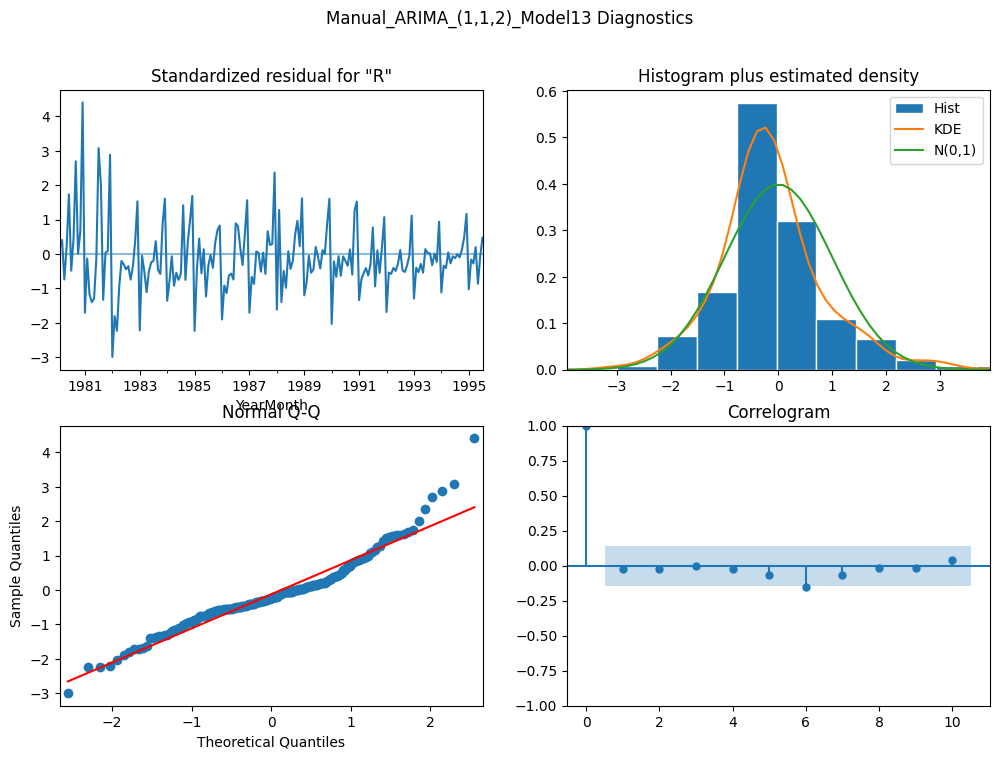

{'fopt': np.float64(4.713159447701585), 'gopt': array([ 7.98232591e-06, -3.24975602e-06,  2.65014677e-06, -1.62536651e-08]), 'fcalls': 95, 'warnflag': 0, 'converged': True, 'iterations': 16}


ar.L1      -0.487430
ma.L1      -0.226689
ma.L2      -0.600258
sigma2    758.316824
dtype: float64
Manual_ARIMA_(1,1,2)_Model13 → Train RMSE: 32.4, MAPE: 22.45%
Manual_ARIMA_(1,1,2)_Model13 → Test RMSE: 16.72, MAPE: 21.7%


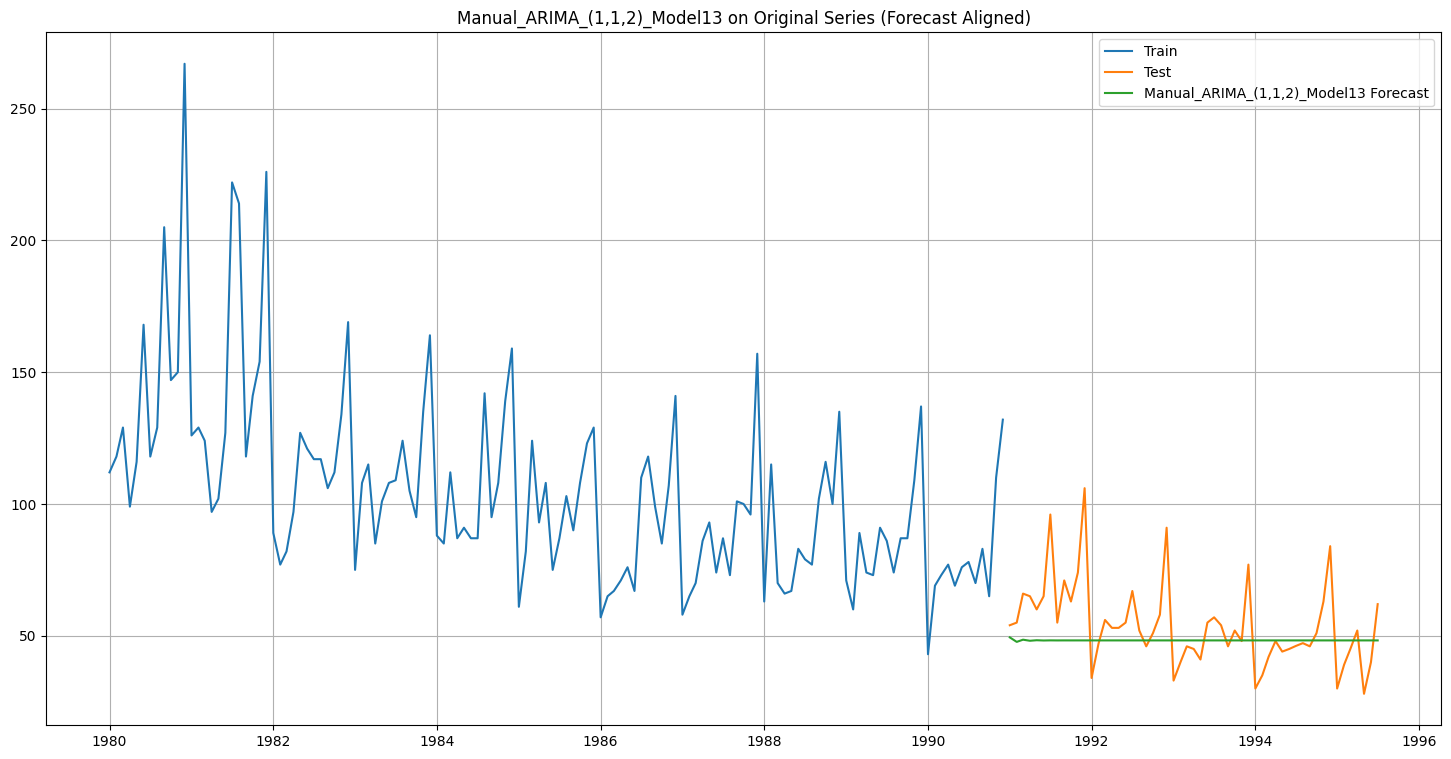

In [160]:
fit_and_evaluate_arima(order=(1,1,2), model_name='Manual_ARIMA_(1,1,2)_Model13')

In [161]:
resultsDF

Model  Train RMSE  Train MAPE  \
0                           RegressionModel_Model1       30.72       21.22   
1                                     Naive_Model2       45.06       36.38   
2                           SimpleAveraging_Model3       36.03       25.39   
3                       2-Point Trailing MA_Model4       19.47       12.47   
4                       4-Point Trailing MA_Model4       25.97       18.03   
5                       6-Point Trailing MA_Model4       28.46       20.41   
6                       9-Point Trailing MA_Model4       30.23       22.06   
7                        SimpleExpSmoothing_Model5       31.78       22.37   
8                       SES_FixedAlpha=0.07_Model6       32.65       23.02   
9     DoubleExpSmoothing_Alpha=0.0_Beta=0.0_Model7       30.72       21.22   
10        DES_GridSearch_Alpha=0.1_Beta=0.1_Model8       32.03       22.78   
11         TES_Auto_AddTrend_AddSeasonality_Model9       19.48       13.27   
12  TES_Final_Alpha=0.3_Beta=0.3_Gamma=0.4_Model10       25.31       18.48   
13                         ARIMA_(2, 1, 3)_Model11       31.54       22.62   
14        SARIMA_(0, 1, 2)_x_(2, 0, 2, 12)_Model12       32.23       18.55   
15                    Manual_ARIMA_(2,1,1)_Model13       32.60       22.88   
16                    Manual_ARIMA_(1,1,2)_Model13       32.40       22.45   

    Test RMSE  Test MAPE                        Data Source  
0       51.39      91.49                           original  
1       79.67     144.91                           original  
2       53.41      94.77                           original  
3       11.53      13.57                           original  
4       14.44      19.46                           original  
5       14.55      20.82                           original  
6       14.72      20.99                           original  
7       37.54      65.20                           original  
8       36.39      63.09                           original  
9       15.25      22.69                           original  
10      37.01      63.89                           original  
11      14.23      19.16                           original  
12      12.74      17.01                           original  
13      36.77      63.77  original data | 1st diff in Model  
14      26.88      46.48     original data | 1st diff Model  
15      16.76      21.69  original data | 1st diff in Model  
16      16.72      21.70  original data | 1st diff in Model

## Model 14: Manual SARIMA

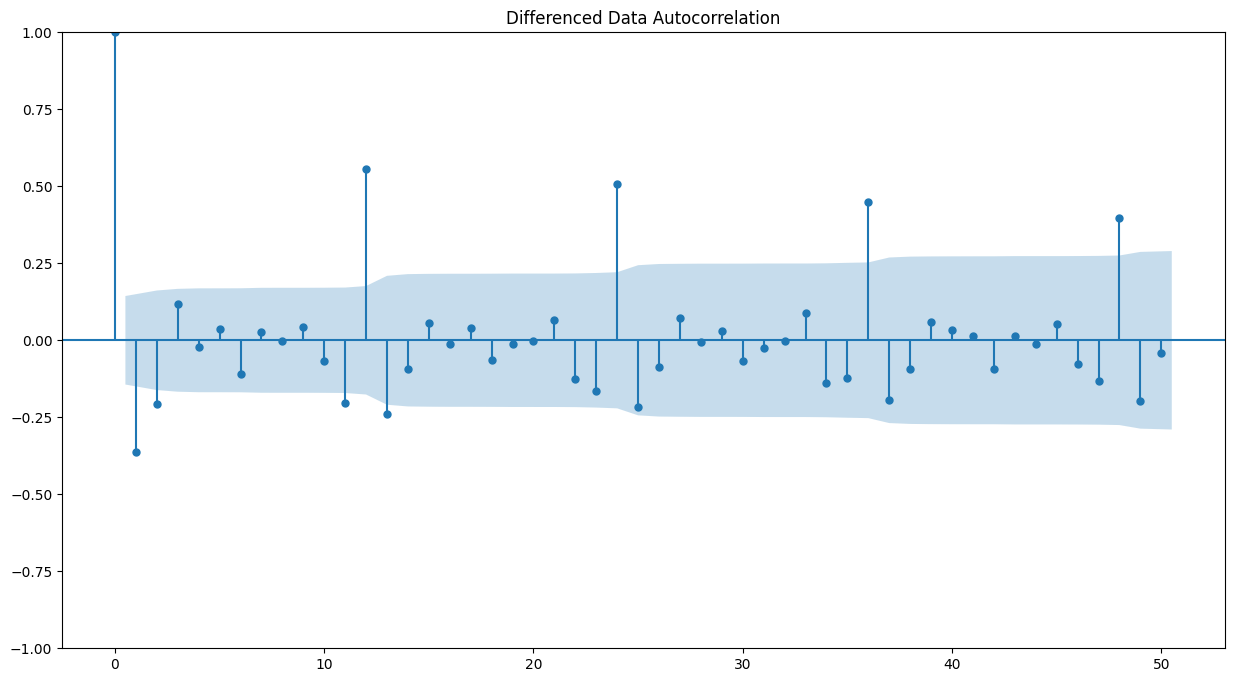

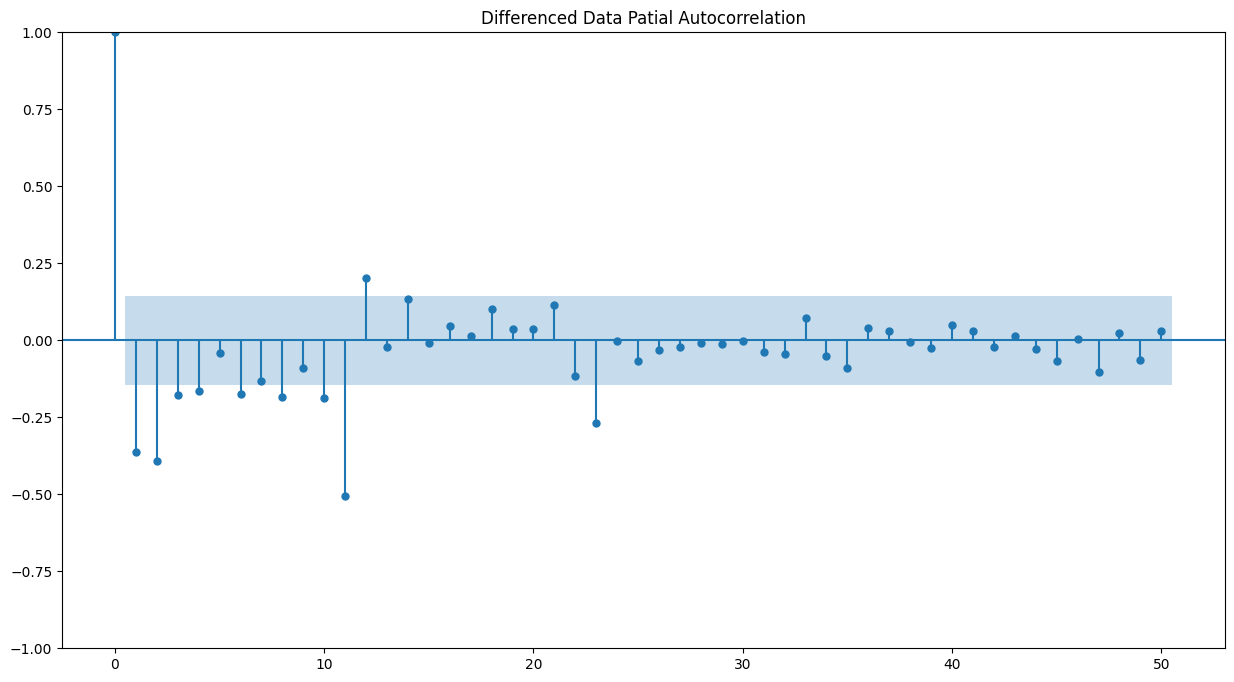

In [162]:
plot_acf(df['Rose'].diff().dropna(),lags=50,title='Differenced Data Autocorrelation')
plot_pacf(df['Rose'].diff().dropna(),lags=50,title='Differenced Data Patial Autocorrelation')
plt.show()

In [163]:
manual_SARIMA = sm.tsa.statespace.SARIMAX(
    train['Rose'],
    order=(3,1,2),
    seasonal_order=(3,1,2,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results_manual_SARIMA = manual_SARIMA.fit(maxiter=1000)

In [164]:
print(results_manual_SARIMA.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               Rose   No. Observations:                  132
Model:             SARIMAX(3, 1, 2)x(3, 1, 2, 12)   Log Likelihood                -331.007
Date:                            Sun, 13 Apr 2025   AIC                            684.014
Time:                                    17:47:42   BIC                            710.216
Sample:                                01-01-1980   HQIC                           694.519
                                     - 12-01-1990                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8542      0.184     -4.637      0.000      -1.215      -0.493
ar.L2          0.0008      0.195   

In [165]:
print(results_manual_SARIMA.params)

ar.L1        -0.854228
ar.L2         0.000793
ar.L3         0.031223
ma.L1        -0.036187
ma.L2        -0.934524
ar.S.L12     -0.055347
ar.S.L24      0.019882
ar.S.L36      0.000188
ma.S.L12     -0.787583
ma.S.L24     -0.212329
sigma2      179.699500
dtype: float64


In [166]:
results_manual_SARIMA.mle_retvals

{'fopt': np.float64(2.5076295201944405),
 'gopt': array([-7.94547095e-05, -5.88012750e-05,  1.63301817e-05, -6.77777834e-06,
         2.44086529e-05,  5.54813528e-05,  2.17176055e-05,  4.77233719e-04,
        -3.37969208e-05,  4.34008385e-06,  5.79349901e-06]),
 'fcalls': 1068,
 'warnflag': 0,
 'converged': True,
 'iterations': 76}

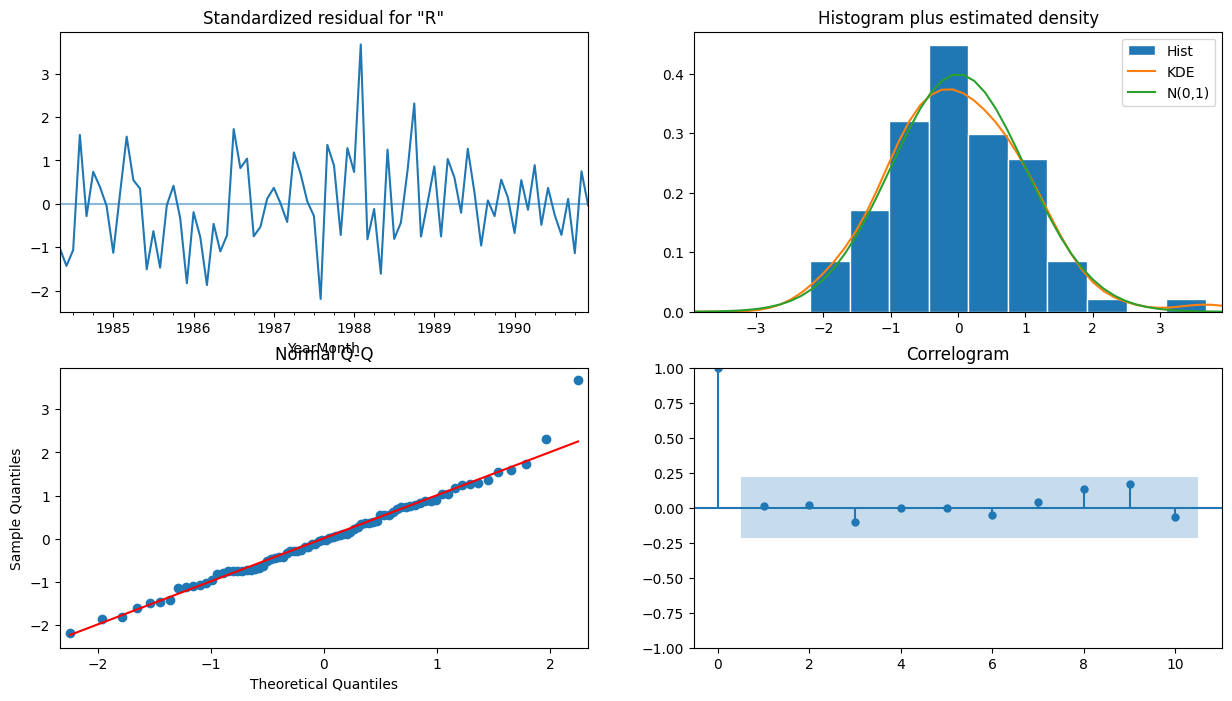

In [167]:
results_manual_SARIMA.plot_diagnostics();

In [168]:
# Predictions
train_preds_manual_sarima = results_manual_SARIMA.predict(start=train.index[0], end=train.index[-1])
test_preds_manual_sarima = results_manual_SARIMA.forecast(steps=len(test))
test_preds_manual_sarima.index = test.index  # align forecast index with test

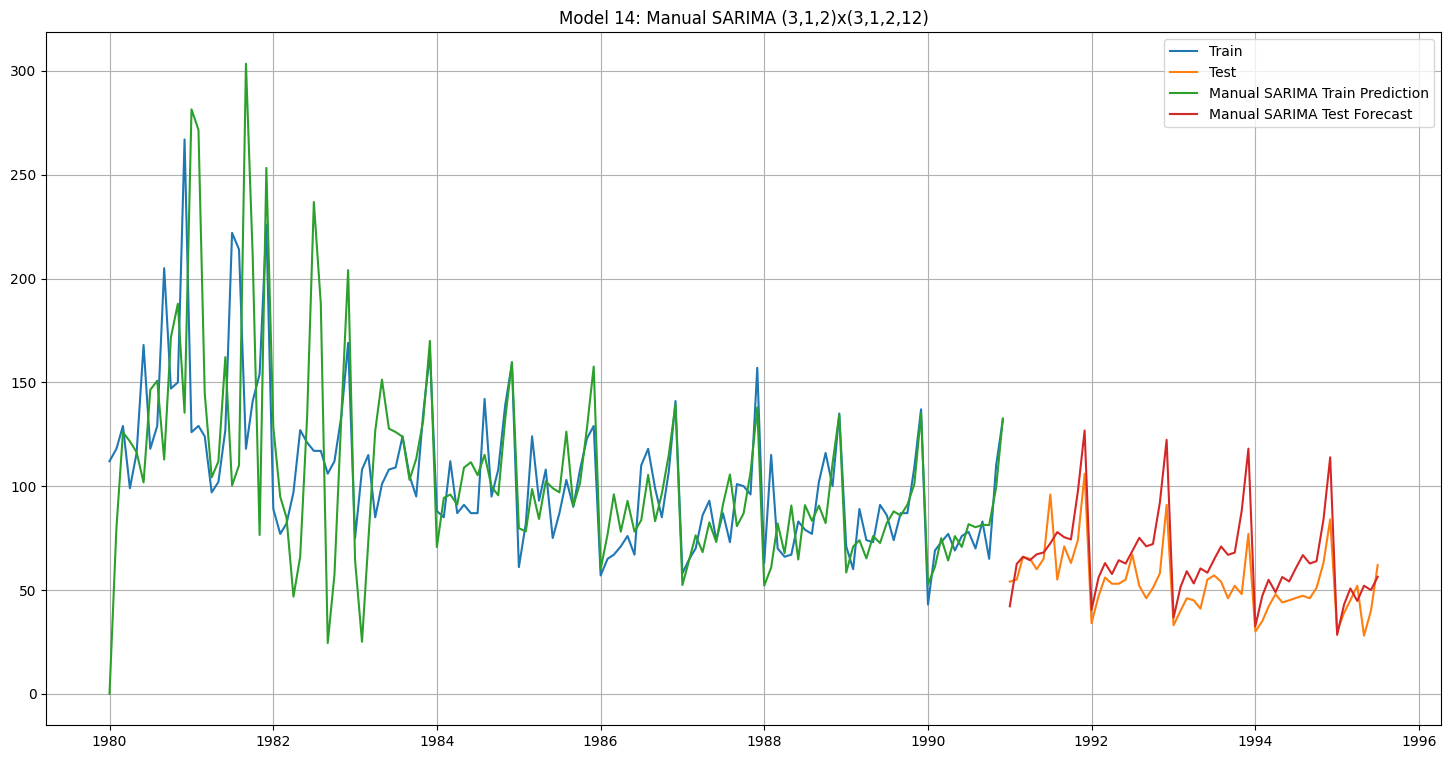

In [169]:
# Plotting
plt.figure(figsize=(18, 9))
plt.plot(train['Rose'], label='Train')
plt.plot(test['Rose'], label='Test')
plt.plot(train_preds_manual_sarima, label='Manual SARIMA Train Prediction')
plt.plot(test_preds_manual_sarima, label='Manual SARIMA Test Forecast')
plt.title('Model 14: Manual SARIMA (3,1,2)x(3,1,2,12)')
plt.legend()
plt.grid()
plt.show()

In [170]:
# Step 6: Metrics
rmse_train_manual_sarima = RMSE(train['Rose'], train_preds_manual_sarima)
mape_train_manual_sarima = MAPE(train['Rose'], train_preds_manual_sarima)

rmse_test_manual_sarima = RMSE(test['Rose'], test_preds_manual_sarima)
mape_test_manual_sarima = MAPE(test['Rose'], test_preds_manual_sarima)

print(f"Model 14 - Manual SARIMA Train → RMSE: {rmse_train_manual_sarima}, MAPE: {mape_train_manual_sarima}%")
print(f"Model 14 - Manual SARIMA Test  → RMSE: {rmse_test_manual_sarima}, MAPE: {mape_test_manual_sarima}%")

Model 14 - Manual SARIMA Train → RMSE: 42.46, MAPE: 24.38%
Model 14 - Manual SARIMA Test  → RMSE: 16.76, MAPE: 25.08%


In [171]:
# Step 7: Log Results
log_results(
    model="SARIMA_Manual_(3,1,2)(3,1,2,12)_Model14",
    train_rmse=rmse_train_manual_sarima,
    train_mape=mape_train_manual_sarima,
    test_rmse=rmse_test_manual_sarima,
    test_mape=mape_test_manual_sarima,
    data_source='original data | 1st diff model'
)

In [172]:
resultsDF

Model  Train RMSE  Train MAPE  \
0                           RegressionModel_Model1       30.72       21.22   
1                                     Naive_Model2       45.06       36.38   
2                           SimpleAveraging_Model3       36.03       25.39   
3                       2-Point Trailing MA_Model4       19.47       12.47   
4                       4-Point Trailing MA_Model4       25.97       18.03   
5                       6-Point Trailing MA_Model4       28.46       20.41   
6                       9-Point Trailing MA_Model4       30.23       22.06   
7                        SimpleExpSmoothing_Model5       31.78       22.37   
8                       SES_FixedAlpha=0.07_Model6       32.65       23.02   
9     DoubleExpSmoothing_Alpha=0.0_Beta=0.0_Model7       30.72       21.22   
10        DES_GridSearch_Alpha=0.1_Beta=0.1_Model8       32.03       22.78   
11         TES_Auto_AddTrend_AddSeasonality_Model9       19.48       13.27   
12  TES_Final_Alpha=0.3_Beta=0.3_Gamma=0.4_Model10       25.31       18.48   
13                         ARIMA_(2, 1, 3)_Model11       31.54       22.62   
14        SARIMA_(0, 1, 2)_x_(2, 0, 2, 12)_Model12       32.23       18.55   
15                    Manual_ARIMA_(2,1,1)_Model13       32.60       22.88   
16                    Manual_ARIMA_(1,1,2)_Model13       32.40       22.45   
17         SARIMA_Manual_(3,1,2)(3,1,2,12)_Model14       42.46       24.38   

    Test RMSE  Test MAPE                        Data Source  
0       51.39      91.49                           original  
1       79.67     144.91                           original  
2       53.41      94.77                           original  
3       11.53      13.57                           original  
4       14.44      19.46                           original  
5       14.55      20.82                           original  
6       14.72      20.99                           original  
7       37.54      65.20                           original  
8       36.39      63.09                           original  
9       15.25      22.69                           original  
10      37.01      63.89                           original  
11      14.23      19.16                           original  
12      12.74      17.01                           original  
13      36.77      63.77  original data | 1st diff in Model  
14      26.88      46.48     original data | 1st diff Model  
15      16.76      21.69  original data | 1st diff in Model  
16      16.72      21.70  original data | 1st diff in Model  
17      16.76      25.08     original data | 1st diff model

## Model 15: Prophet Implementation

In [173]:
from prophet import Prophet

# Reset the index and prepare the DataFrame for Prophet
prophet_df = df.copy().reset_index()
prophet_df = df.reset_index().rename(columns={'YearMonth': 'ds', 'Rose': 'y'})

prophet_df.head()

Importing plotly failed. Interactive plots will not work.


ds      y
0 1980-01-01  112.0
1 1980-02-01  118.0
2 1980-03-01  129.0
3 1980-04-01   99.0
4 1980-05-01  116.0

In [174]:
# split the data into train and test
train_prophet = prophet_df[prophet_df['ds'].dt.year < 1991]
test_prophet = prophet_df[prophet_df['ds'].dt.year >= 1991]

In [175]:
# fit the model
model = Prophet()
model.fit(train_prophet)

17:47:43 - cmdstanpy - INFO - Chain [1] start processing
17:47:43 - cmdstanpy - INFO - Chain [1] done processing


In [176]:
# Create a future dataframe for the test period
future = model.make_future_dataframe(periods=len(test_prophet), freq='MS') 
future['ds'] = pd.to_datetime(future['ds']) 

future.tail()

ds
182 1995-03-01
183 1995-04-01
184 1995-05-01
185 1995-06-01
186 1995-07-01

In [177]:
forecast = model.predict(future)
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast.head()

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 1980-01-01  148.023732   92.726887  139.728916   148.023732   148.023732   
1 1980-02-01  147.270299  106.932798  156.188076   147.270299   147.270299   
2 1980-03-01  146.565474  115.653692  162.453408   146.565474   146.565474   
3 1980-04-01  145.812041   99.150984  147.125987   145.812041   145.812041   
4 1980-05-01  145.082912  105.375565  152.963760   145.082912   145.082912   

   additive_terms  additive_terms_lower  additive_terms_upper     yearly  \
0      -32.232785            -32.232785            -32.232785 -32.232785   
1      -16.538790            -16.538790            -16.538790 -16.538790   
2       -8.788438             -8.788438             -8.788438  -8.788438   
3      -23.273061            -23.273061            -23.273061 -23.273061   
4      -15.705887            -15.705887            -15.705887 -15.705887   

   yearly_lower  yearly_upper  multiplicative_terms  \
0    -32.232785    -32.232785                   0.0   
1    -16.538790    -16.538790                   0.0   
2     -8.788438     -8.788438                   0.0   
3    -23.273061    -23.273061                   0.0   
4    -15.705887    -15.705887                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper        yhat  
0                         0.0                         0.0  115.790947  
1                         0.0                         0.0  130.731509  
2                         0.0                         0.0  137.777036  
3                         0.0                         0.0  122.538980  
4                         0.0                         0.0  129.377025

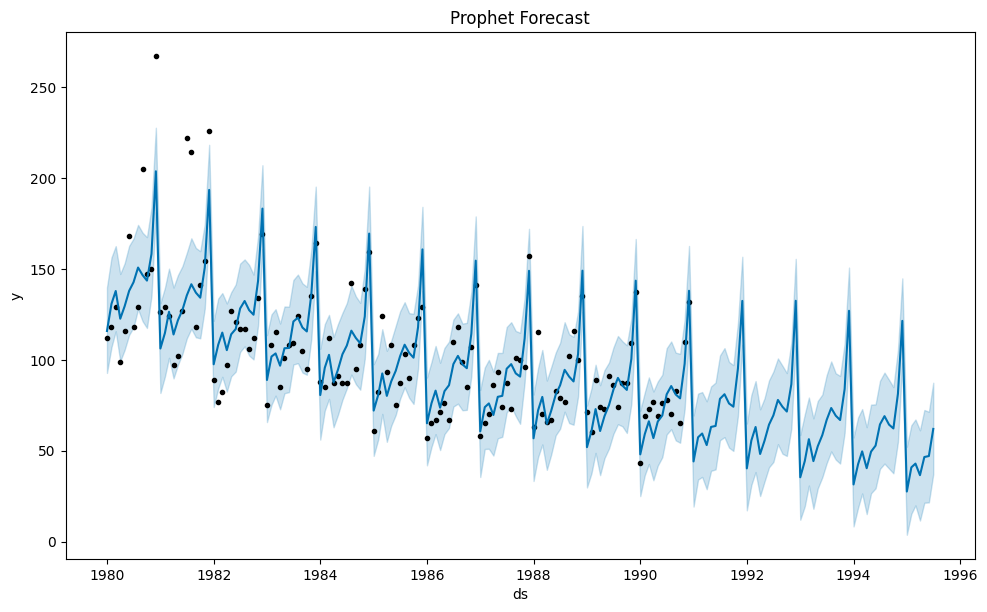

In [178]:
fig = model.plot(forecast)
plt.title("Prophet Forecast")
plt.grid()
plt.show()

In [179]:
## Evaluation
# Merge predictions with actuals
forecast['ds'] = pd.to_datetime(forecast['ds'])
test_prophet = test_prophet.copy()
test_prophet['ds'] = pd.to_datetime(test_prophet['ds'])

# Filter only matching test dates
forecast_test = forecast.set_index('ds').loc[test_prophet['ds']]
actuals_test = test_prophet.set_index('ds').loc[forecast_test.index]

# Compute Evaluation Metrics
rmse_prophet = RMSE(actuals_test['y'], forecast_test['yhat'])
mape_prophet = MAPE(actuals_test['y'], forecast_test['yhat'])

print(f"Model 13 (Prophet) - Test RMSE: {rmse_prophet}, MAPE: {mape_prophet}%")

Model 13 (Prophet) - Test RMSE: 17.3, MAPE: 24.42%


In [180]:
# STEP 5: Log Results
log_results(
    model="Prophet_Model15",
    train_rmse=None,
    train_mape=None,
    test_rmse=rmse_prophet,
    test_mape=mape_prophet,
    data_source="original | reindexed"
)

/tmp/ipykernel_22116/3891039026.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  resultsDF = pd.concat([resultsDF, new_row], ignore_index=True)


In [181]:
resultsDF

Model  Train RMSE  Train MAPE  \
0                           RegressionModel_Model1       30.72       21.22   
1                                     Naive_Model2       45.06       36.38   
2                           SimpleAveraging_Model3       36.03       25.39   
3                       2-Point Trailing MA_Model4       19.47       12.47   
4                       4-Point Trailing MA_Model4       25.97       18.03   
5                       6-Point Trailing MA_Model4       28.46       20.41   
6                       9-Point Trailing MA_Model4       30.23       22.06   
7                        SimpleExpSmoothing_Model5       31.78       22.37   
8                       SES_FixedAlpha=0.07_Model6       32.65       23.02   
9     DoubleExpSmoothing_Alpha=0.0_Beta=0.0_Model7       30.72       21.22   
10        DES_GridSearch_Alpha=0.1_Beta=0.1_Model8       32.03       22.78   
11         TES_Auto_AddTrend_AddSeasonality_Model9       19.48       13.27   
12  TES_Final_Alpha=0.3_Beta=0.3_Gamma=0.4_Model10       25.31       18.48   
13                         ARIMA_(2, 1, 3)_Model11       31.54       22.62   
14        SARIMA_(0, 1, 2)_x_(2, 0, 2, 12)_Model12       32.23       18.55   
15                    Manual_ARIMA_(2,1,1)_Model13       32.60       22.88   
16                    Manual_ARIMA_(1,1,2)_Model13       32.40       22.45   
17         SARIMA_Manual_(3,1,2)(3,1,2,12)_Model14       42.46       24.38   
18                                 Prophet_Model15         NaN         NaN   

    Test RMSE  Test MAPE                        Data Source  
0       51.39      91.49                           original  
1       79.67     144.91                           original  
2       53.41      94.77                           original  
3       11.53      13.57                           original  
4       14.44      19.46                           original  
5       14.55      20.82                           original  
6       14.72      20.99                           original  
7       37.54      65.20                           original  
8       36.39      63.09                           original  
9       15.25      22.69                           original  
10      37.01      63.89                           original  
11      14.23      19.16                           original  
12      12.74      17.01                           original  
13      36.77      63.77  original data | 1st diff in Model  
14      26.88      46.48     original data | 1st diff Model  
15      16.76      21.69  original data | 1st diff in Model  
16      16.72      21.70  original data | 1st diff in Model  
17      16.76      25.08     original data | 1st diff model  
18      17.30      24.42               original | reindexed

## Model 16: XGBoost Regressor

In [182]:
xgb_df = df.copy()
for lag in range(1, 13):  # Use 12 months of history
    xgb_df[f'lag_{lag}'] = xgb_df['Rose'].shift(lag)

# Drop rows with NaNs caused by lagging
xgb_df = xgb_df.dropna()

In [183]:
train_xgb = xgb_df[xgb_df.index.year < 1991]
test_xgb = xgb_df[xgb_df.index.year >= 1991]

X_train = train_xgb.drop(columns=['Rose'])
y_train = train_xgb['Rose']

X_test = test_xgb.drop(columns=['Rose'])
y_test = test_xgb['Rose']

In [184]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [185]:
train_preds = xgb_model.predict(X_train)
test_preds = xgb_model.predict(X_test)

rmse_train = RMSE(y_train, train_preds)
mape_train = MAPE(y_train, train_preds)

rmse_test = RMSE(y_test, test_preds)
mape_test = MAPE(y_test, test_preds)

print(f"XGBoost - Train RMSE: {rmse_train}, MAPE: {mape_train}%")
print(f"XGBoost - Test RMSE: {rmse_test}, MAPE: {mape_test}%")


XGBoost - Train RMSE: 4.97, MAPE: 3.78%
XGBoost - Test RMSE: 27.65, MAPE: 46.09%


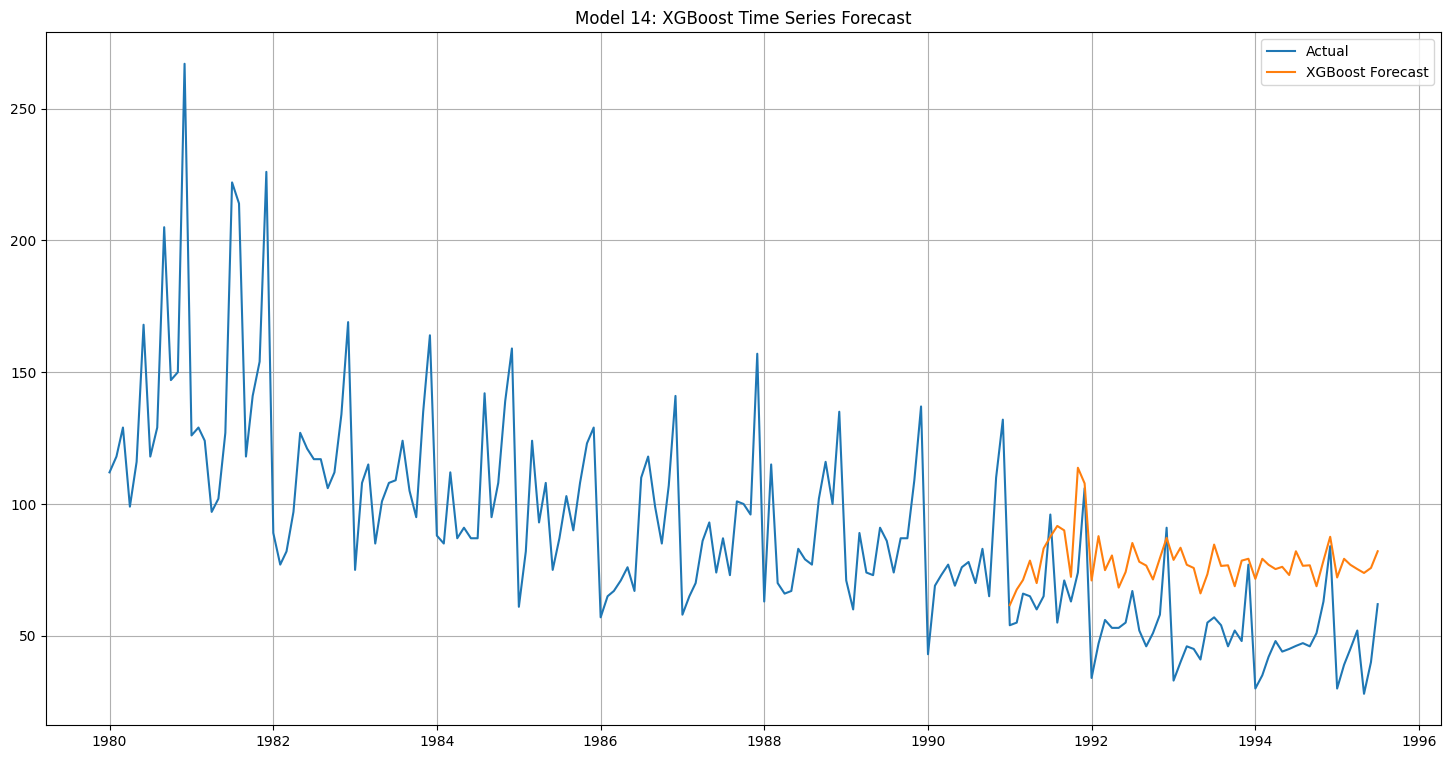

In [186]:
plt.figure(figsize=(18, 9))
plt.plot(df['Rose'], label='Actual')
plt.plot(test_xgb.index, test_preds, label='XGBoost Forecast')
plt.title('Model 14: XGBoost Time Series Forecast')
plt.legend()
plt.grid()
plt.show()

In [187]:
log_results(
    model='XGBoost_Model16',
    train_rmse=rmse_train,
    train_mape=mape_train,
    test_rmse=rmse_test,
    test_mape=mape_test,
    data_source='original | lag features'
)

## Model 17: Neural Network

In [188]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

2025-04-13 17:47:44.321556: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-13 17:47:44.324475: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-13 17:47:44.331790: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744584464.344996   22116 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744584464.349905   22116 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744584464.362970   22116 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [189]:
data = df[['Rose']].copy()

# Scaling
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [190]:
# Create Sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 12  # 12 months
X, y = create_sequences(data_scaled, window_size)

In [191]:
train_size = int(len(X) * 0.7)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Reshape for CNN-LSTM: (samples, timesteps, features)
# Here timesteps == window_size, features == 1
X_train = X_train.reshape((X_train.shape[0], window_size, 1))
X_test = X_test.reshape((X_test.shape[0], window_size, 1))

In [192]:
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(window_size, 1)),
    MaxPooling1D(pool_size=2),
    LSTM(50, activation='tanh'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

/home/anmol/miniconda3/envs/timeseries/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1744584465.801861   22116 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1744584465.802426   22116 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 11, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,243 (90.79 KB)

 Trainable params: 23,243 (90.79 KB)

 Non-trainable params: 0 (0.00 B)

In [193]:
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=1)

# ----- STEP 6: Predict & Inverse Scale -----
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_preds_inv = scaler.inverse_transform(train_preds)
y_train_inv = scaler.inverse_transform(y_train)

test_preds_inv = scaler.inverse_transform(test_preds)
y_test_inv = scaler.inverse_transform(y_test)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0922 - val_loss: 0.0094
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0203 - val_loss: 0.0200
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0237 - val_loss: 0.0105
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0173 - val_loss: 0.0093
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0203 - val_loss: 0.0092
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0209 - val_loss: 0.0114
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0184 - val_loss: 0.0124
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0171 - val_loss: 0.0102
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0158 - val_loss: 0.0111
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0131 - val_loss: 0.0104
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0168 - val_loss: 0.0092
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0151 - val_loss: 0.0110
Epoch 13/50

In [194]:
# TRAIN METRICS
rmse_train = RMSE(y_train_inv, train_preds_inv)
mape_train = MAPE(y_train_inv, train_preds_inv)

In [195]:
# TEST METRICS
rmse_test = RMSE(y_test_inv, test_preds_inv)
mape_test = MAPE(y_test_inv, test_preds_inv)

print(f"CNN-LSTM Train RMSE: {rmse_train:.2f}, MAPE: {mape_train:.2f}%")
print(f"CNN-LSTM Test RMSE: {rmse_test:.2f}, MAPE: {mape_test:.2f}%")

CNN-LSTM Train RMSE: 24.36, MAPE: 18.81%
CNN-LSTM Test RMSE: 22.15, MAPE: 38.12%


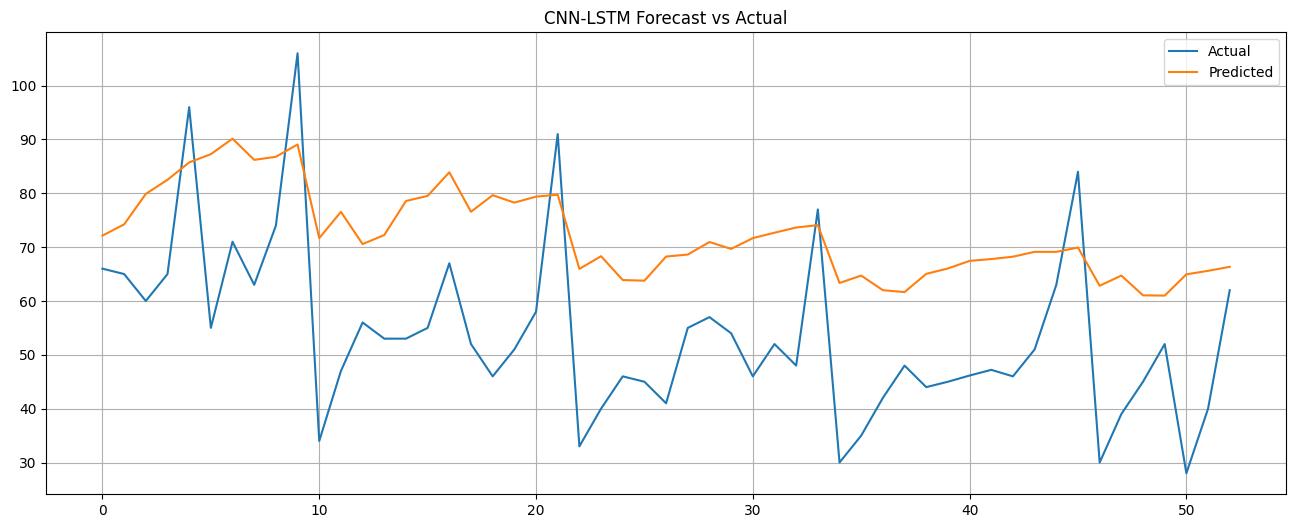

In [196]:
plt.figure(figsize=(16, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(test_preds_inv, label='Predicted')
plt.title("CNN-LSTM Forecast vs Actual")
plt.legend()
plt.grid(True)
plt.show()

In [197]:
log_results(
    model="CNN_LSTM_Model17",
    train_rmse=rmse_train,
    train_mape=mape_train,
    test_rmse=rmse_test,
    test_mape=mape_test,
    data_source="scaled + inverse"
)

In [198]:
resultsDF

Model  Train RMSE  Train MAPE  \
0                           RegressionModel_Model1       30.72       21.22   
1                                     Naive_Model2       45.06       36.38   
2                           SimpleAveraging_Model3       36.03       25.39   
3                       2-Point Trailing MA_Model4       19.47       12.47   
4                       4-Point Trailing MA_Model4       25.97       18.03   
5                       6-Point Trailing MA_Model4       28.46       20.41   
6                       9-Point Trailing MA_Model4       30.23       22.06   
7                        SimpleExpSmoothing_Model5       31.78       22.37   
8                       SES_FixedAlpha=0.07_Model6       32.65       23.02   
9     DoubleExpSmoothing_Alpha=0.0_Beta=0.0_Model7       30.72       21.22   
10        DES_GridSearch_Alpha=0.1_Beta=0.1_Model8       32.03       22.78   
11         TES_Auto_AddTrend_AddSeasonality_Model9       19.48       13.27   
12  TES_Final_Alpha=0.3_Beta=0.3_Gamma=0.4_Model10       25.31       18.48   
13                         ARIMA_(2, 1, 3)_Model11       31.54       22.62   
14        SARIMA_(0, 1, 2)_x_(2, 0, 2, 12)_Model12       32.23       18.55   
15                    Manual_ARIMA_(2,1,1)_Model13       32.60       22.88   
16                    Manual_ARIMA_(1,1,2)_Model13       32.40       22.45   
17         SARIMA_Manual_(3,1,2)(3,1,2,12)_Model14       42.46       24.38   
18                                 Prophet_Model15         NaN         NaN   
19                                 XGBoost_Model16        4.97        3.78   
20                                CNN_LSTM_Model17       24.36       18.81   

    Test RMSE  Test MAPE                        Data Source  
0       51.39      91.49                           original  
1       79.67     144.91                           original  
2       53.41      94.77                           original  
3       11.53      13.57                           original  
4       14.44      19.46                           original  
5       14.55      20.82                           original  
6       14.72      20.99                           original  
7       37.54      65.20                           original  
8       36.39      63.09                           original  
9       15.25      22.69                           original  
10      37.01      63.89                           original  
11      14.23      19.16                           original  
12      12.74      17.01                           original  
13      36.77      63.77  original data | 1st diff in Model  
14      26.88      46.48     original data | 1st diff Model  
15      16.76      21.69  original data | 1st diff in Model  
16      16.72      21.70  original data | 1st diff in Model  
17      16.76      25.08     original data | 1st diff model  
18      17.30      24.42               original | reindexed  
19      27.65      46.09            original | lag features  
20      22.15      38.12                   scaled + inverse

In [211]:
# Export the ResultsDF to File
excel_path = "wine_modeling_results.xlsx"

# Use ExcelWriter safely
with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a' if os.path.exists(excel_path) else 'w') as writer:
    resultsDF.to_excel(writer, sheet_name='Rose', index=False)

## Results

In [200]:
resultsDF.sort_values(by='Test RMSE').style.highlight_min(color='lightgreen', subset=['Test RMSE'])

In [201]:
best_model = resultsDF.loc[resultsDF['Test RMSE'].idxmin()]
print(best_model)

Model          2-Point Trailing MA_Model4
Train RMSE                          19.47
Train MAPE                          12.47
Test RMSE                           11.53
Test MAPE                           13.57
Data Source                      original
Name: 3, dtype: object


## Best Model on Complete Data And Forecast for the Next 12 months

In [202]:
order = (3, 1, 2)
seasonal_order = (3, 1, 2, 12)

full_data_model = sm.tsa.statespace.SARIMAX(df['Rose'],
                                order=(3,1,2),
                                seasonal_order=(3, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_full_data_model = full_data_model.fit(maxiter=1000)

In [203]:
print(results_full_data_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               Rose   No. Observations:                  187
Model:             SARIMAX(3, 1, 2)x(3, 1, 2, 12)   Log Likelihood                -538.837
Date:                            Sun, 13 Apr 2025   AIC                           1099.673
Time:                                    17:48:02   BIC                           1131.631
Sample:                                01-01-1980   HQIC                          1112.660
                                     - 07-01-1995                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7995      0.265      3.018      0.003       0.280       1.319
ar.L2         -0.0967      0.127   

In [204]:
print(results_full_data_model.params)

ar.L1         0.799479
ar.L2        -0.096729
ar.L3        -0.098733
ma.L1        -1.653085
ma.L2         0.713562
ar.S.L12     -0.123070
ar.S.L24      0.031705
ar.S.L36     -0.001706
ma.S.L12     -0.544121
ma.S.L24     -0.210101
sigma2      165.123168
dtype: float64


### Forecasting

In [205]:
predicted_manual_SARIMA_full_data = results_full_data_model.get_forecast(steps=12)

In [206]:
predicted_manual_SARIMA_full_data.summary_frame(alpha=0.05).head()

Rose             mean    mean_se  mean_ci_lower  mean_ci_upper
1995-08-01  47.008288  12.857239      21.808564      72.208013
1995-09-01  46.813005  12.994335      21.344577      72.281433
1995-10-01  48.052933  13.035762      22.503308      73.602558
1995-11-01  60.501975  13.036623      34.950664      86.053286
1995-12-01  88.436835  13.051140      62.857070     114.016599

In [207]:
# Step 4: Evaluate model on full data (in-sample fit)
rmse_full = RMSE(df['Rose'], results_full_data_model.fittedvalues)
print(f"In-sample RMSE on full data: {rmse_full}")

In-sample RMSE on full data: 41.04


In [208]:
forecast_df = predicted_manual_SARIMA_full_data.summary_frame(alpha=0.05)

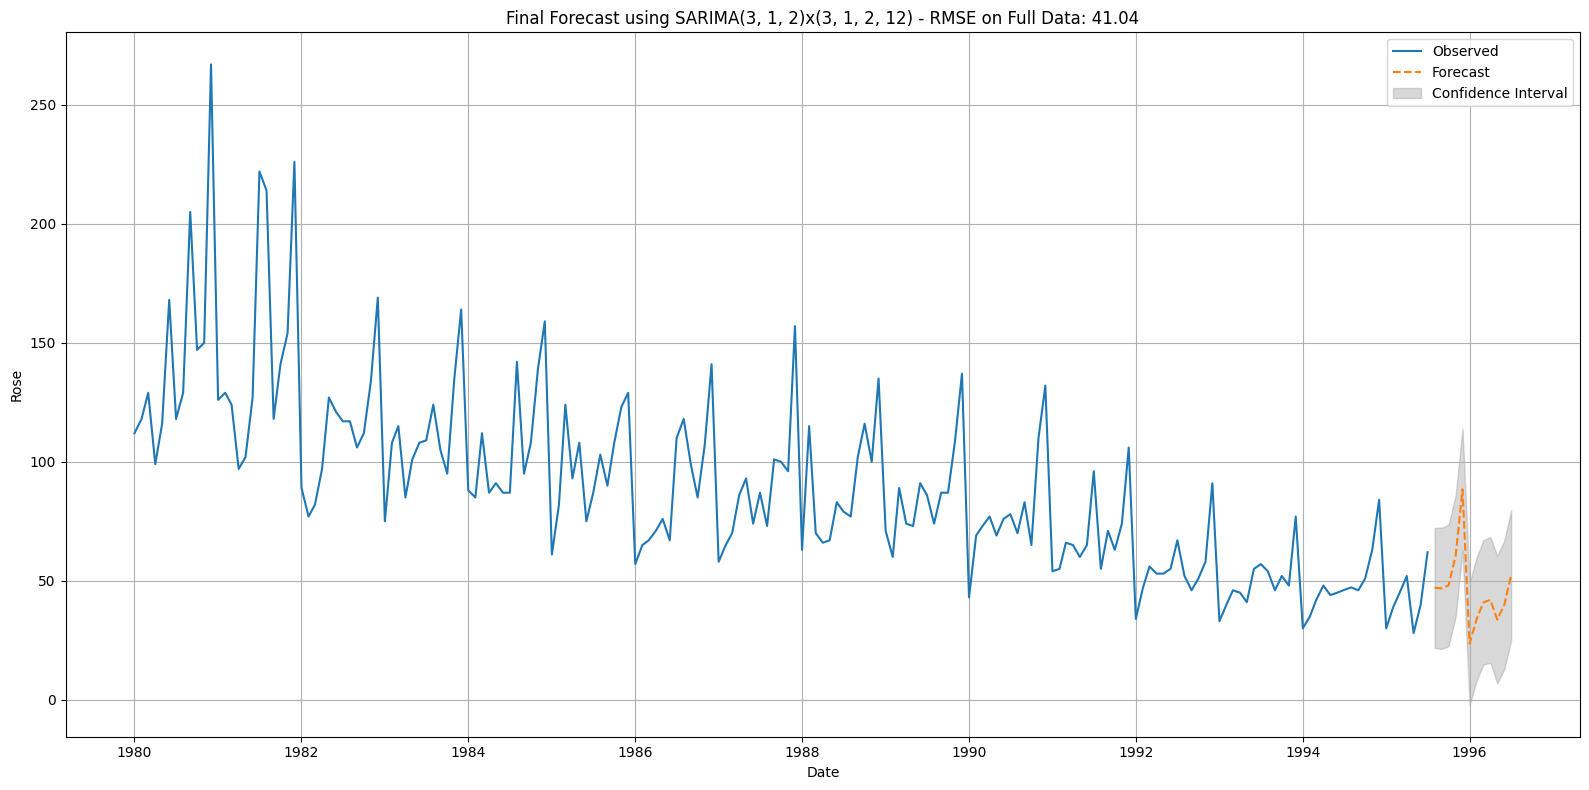

In [209]:
plt.figure(figsize=(16, 8))
plt.plot(df['Rose'], label='Observed')
plt.plot(forecast_df['mean'], label='Forecast', linestyle='--')
plt.fill_between(forecast_df.index, 
                 forecast_df['mean_ci_lower'], 
                 forecast_df['mean_ci_upper'], 
                 color='gray', alpha=0.3, label='Confidence Interval')
plt.title(f'Final Forecast using SARIMA{order}x{seasonal_order} - RMSE on Full Data: {rmse_full:.2f}')
plt.xlabel('Date')
plt.ylabel('Rose')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [212]:
import joblib

joblib.dump(results_full_data_model, 'rose_sarima_model.pkl')

['rose_sarima_model.pkl']